# Titanic Survival Prediction
This notebook implements the prediction of titanic survivors. A training dataset `train.csv` with 891 passengers is used to learn a prediction function for the survival status. A test set `test.csv` contains 418 passengers and will be used to predict their survival. Only the train set contains the survival status as additional column.

Your results must be reproducible - please **don't overlook the rules for `random_state`** in the body of this notebook to obtain full credit for your work.

Execute the below line to install the xgboost library. 

In [1]:
#pip install xgboost

Execute the line below for the OneHotEncoder to work. 

In [2]:
#pip install category_encoders

In [3]:
#pip install imbalanced-learn

In [4]:
import pandas as pd
print('pandas', pd.__version__)
import numpy as np
print('numpy', np.__version__)
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
import string
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.precision', 3)
import warnings 
warnings.simplefilter("ignore", category=DeprecationWarning) 

pandas 2.2.2
numpy 1.26.4


### Define random state

Challenge rules: results must be reproducible, i.e., multiple runs must result in the same result.

All `random_state` parameters (for models, data splitting, etc.) must be fixed - for reproducibility - based on your **personal random ID** in `RandomID.csv`. 

Used both, random_id & random_state, because most of the times random_state was fine to use, once for the DecisionTreeClassifier, I had to use random_id. 

In [5]:
random_id = 43
np.random.seed(random_id)

random_state = np.random.RandomState(random_id)
#random_state = random_id

## Obtain and explore

#### Load the data

In [6]:
data_path = Path.cwd()

def read_file(file): 
    df = pd.read_csv(data_path/file, index_col=0)
    return df

In [7]:
train_df_init = read_file('train.csv')
train_df_init[:3]

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.250,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.283,C85,C
3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.925,NaN,S


In [8]:
train_df_init.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


##### Feature Description 
- `PassengerId` - Unique row identifier
- `Survived` - Target label, indicates whether a passenger survived or died
    - 1: Survived
    - 0: Died
- `Pclass`: Passenger Class, indicates which class the passenger was travelling in, with 1 - 3 and 1 being the first class and thus the most expensive one
  - 1: First Class
  - 2: Second Class
  - 3: Third Class
- `Name`: Passenger Name, contains Titles which may indicate the sex of a passenger
- `Age`: Passenger age
- `SipSp`: Siblings and spouse the passenger was travelling with (number)
- `Parch`: A passengers number of parents and children
- `Ticket`: A passengers ticket number
- `Fare`: How much a passenger paid for one or more tickets
- `Cabin`: The cabin a passenger was travelling in, e.g. (C85), can contain more than one cabin for families
- `Embarked`: The port a passenger embarked in (C, Q, S)
    - C: Cherbourg
    - Q: Queenstown
    - S: Southampton

In [9]:
# load the test data
test_df_init = pd.read_csv(data_path/'test.csv', index_col=0)
test_df_init.head(3)

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
892,3,"Kelly, Mr. James",34.5,0,0,330911,7.829,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.000,NaN,S
894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.688,NaN,Q


In [10]:
X_test_Passenger = test_df_init.index.values

In [11]:
test_df_init.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Ticket    418 non-null    object 
 6   Fare      417 non-null    float64
 7   Cabin     91 non-null     object 
 8   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 32.7+ KB


Concatenate test and train for further manipulation - note that some manipulation can be done on the complete data set, while for other, the data set will be split up again in order to avoid leakage. 


In [12]:
def combine_dfs(train, test): 
    combined = pd.concat([train, test], sort=True).reset_index(drop=True)
    combined.index = combined.index + 1
    return combined

In [13]:
combined_df = combine_dfs(train_df_init, test_df_init)

In [14]:
combined_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,SibSp,Survived,Ticket
1,22.0,NaN,S,7.250,"Braund, Mr. Owen Harris",0,3,1,0.0,A/5 21171
2,38.0,C85,C,71.283,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,1,1.0,PC 17599
3,26.0,NaN,S,7.925,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.100,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,1,1.0,113803
5,35.0,NaN,S,8.050,"Allen, Mr. William Henry",0,3,0,0.0,373450


### Handle missing values

In [15]:
def plot_binned_distribution_for(feature, df): 
    fig, axs = plt.subplots(figsize=(22, 9))
    sns.countplot(x=feature, hue='Survived', data=df)
    
    plt.xlabel(feature, size=15, labelpad=20)
    plt.ylabel('Passenger Count', size=15, labelpad=20)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
    plt.title('Survival Counts in {} Feature'.format(feature), size=15, y=1.05)
    
    plt.show()

##### Check for missing values

In [16]:
train_df_init.isnull().sum()

Survived      0
Pclass        0
Name          0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [17]:
test_df_init.isnull().sum()

Pclass        0
Name          0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

#### Assign Sex and Title for Passengers
Start with imputing the sex for each person based on titles, titles endings and common sense (taking the time at which the accident happened into account - i.e., women doctors were more likely than only men doctors, however at the time, colonels or majors were male).
This is done, since sex is a high indicator of survival, if we consider 'Women and Children first' in such scenarios. 

In [18]:
def get_person_title_from_name(df): 
    df['Title']=df['Name'].str.split(", ",expand=True)[1].str.split(".",expand=True)[0]
    print("Original Titles existing:")
    print(df['Title'].value_counts())
    print()

    # take four most common titles, otherwise use category Rare to not splitter data too much
    common_titles = df['Title'].value_counts()[:4]
    df['Title'] = df['Title'].apply(lambda x: x if x in common_titles else 'Rare')
    print("Reduced Titles exisiting:")
    print(df['Title'].value_counts())

In [19]:
get_person_title_from_name(combined_df)

Original Titles existing:
Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

Reduced Titles exisiting:
Title
Mr        757
Miss      260
Mrs       197
Master     61
Rare       34
Name: count, dtype: int64


Assign the sex based on title values with special handling of Dr., as it does not imply a sex. 
- 1: male
- 0: female

In [20]:
# 1 male, 0 female
def assign_sex(row):
    # add handling of Dr, does not imply a gender, after looking at columns with value 2 --> 
    # based on common practice to add maiden names for women, which was added within brackets
    # assumption is made, that if that part exists, passenger is female
    title = row["Title"]
    
    if 'Dr' in title: 
        if "(" in title: 
            return 0 
        else: 
            return 1
    
    if title.endswith('s'):
        return 0
    elif title.endswith('r'):
        return 1

    # special handling for rare titles
    elif title.endswith('e'): 
        title_from_name = row["Name"].split(", ")[1].split(".")[0]
        women_endings=['s', 'a', 'e', 'y']

        # due to the time at which the accident happened, it is assumed, that Reverends, Colonels, 
        # Majors and the like were all male 
        men_endings=['r', 'n', 'o', 'n', 't', 'v', 'l']
        if any(title_from_name.endswith(suffix) for suffix in women_endings):
            return 0
        if any(title_from_name.endswith(suffix) for suffix in men_endings):
            return 1


def assign_sex_in_df(df): 
    df.loc[:, 'Sex'] = df.apply(assign_sex, axis=1).astype(int)
    print(df['Sex'].value_counts())


In [21]:
assign_sex_in_df(combined_df)

Sex
1    844
0    465
Name: count, dtype: int64


In [22]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 1 to 1309
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       1046 non-null   float64
 1   Cabin     295 non-null    object 
 2   Embarked  1307 non-null   object 
 3   Fare      1308 non-null   float64
 4   Name      1309 non-null   object 
 5   Parch     1309 non-null   int64  
 6   Pclass    1309 non-null   int64  
 7   SibSp     1309 non-null   int64  
 8   Survived  891 non-null    float64
 9   Ticket    1309 non-null   object 
 10  Title     1309 non-null   object 
 11  Sex       1309 non-null   int32  
dtypes: float64(3), int32(1), int64(3), object(5)
memory usage: 117.7+ KB


#### Is Married Status 
Whether a person is married or not might be influental on survival - especially, if the person is male. 

In [23]:
def extract_name_parts(name):
    # Regular expression to capture Last Name and First Name(s)
    match = re.match(r'([^,]+),\s*[^ ]+\s+([A-Za-z\s]+)', name)
    if match:
        last_name = match.group(1)
        first_names = match.group(2).strip()
        return last_name, first_names
    return None, None

combined_df['Last_Name'], combined_df['First_Name'] = zip(*combined_df['Name'].apply(extract_name_parts))
combined_df[['Name', 'Last_Name', 'First_Name']].head()

,Name,Last_Name,First_Name
1,"Braund, Mr. Owen Harris",Braund,Owen Harris
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,John Bradley
3,"Heikkinen, Miss. Laina",Heikkinen,Laina
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Jacques Heath
5,"Allen, Mr. William Henry",Allen,William Henry


In [24]:
combined_df['Is_Married'] = 0
combined_df.loc[combined_df['Title'] == 'Mrs', 'Is_Married'] = 1
combined_df['Is_Married'].value_counts()

Is_Married
0    1112
1     197
Name: count, dtype: int64

##### Assign is married status 
Split the data in order to avoid leakage. 

In [25]:
train_df, test_df = combined_df.loc[:891].copy(), combined_df.loc[892:].copy()

In [26]:
women_with_mrs_train = train_df[train_df['Is_Married'] == 1]

# Find potential husbands (same last name and first name in the name, it was the time when women where mrs insert husband name here and male) 
potential_husbands_train = train_df[(train_df['Sex'] == 1) & train_df['Last_Name'].isin(women_with_mrs_train['Last_Name']) & (train_df['First_Name'].isin(women_with_mrs_train['First_Name']))]
print(potential_husbands_train.shape)
potential_husbands_train.head(2)

(45, 15)


,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,SibSp,Survived,Ticket,Title,Sex,Last_Name,First_Name,Is_Married
14,39.0,NaN,S,31.275,"Andersson, Mr. Anders Johan",5,3,1,0.0,347082,Mr,1,Andersson,Anders Johan,0
35,28.0,NaN,C,82.171,"Meyer, Mr. Edgar Joseph",0,1,1,0.0,PC 17604,Mr,1,Meyer,Edgar Joseph,0


In [27]:
women_with_mrs_test = test_df[test_df['Is_Married'] == 1]

potential_husbands_test = test_df[(test_df['Sex'] == 1) & test_df['Last_Name'].isin(women_with_mrs_test['Last_Name']) & (test_df['First_Name'].isin(women_with_mrs_test['First_Name']))]
print(potential_husbands_test.shape)
potential_husbands_test.head(2)

(15, 15)


,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,SibSp,Survived,Ticket,Title,Sex,Last_Name,First_Name,Is_Married
905,63.0,NaN,S,26.0,"Howard, Mr. Benjamin",0,2,1,NaN,24065,Mr,1,Howard,Benjamin,0
942,24.0,C31,S,60.0,"Smith, Mr. Lucien Philip",0,1,1,NaN,13695,Mr,1,Smith,Lucien Philip,0


In [28]:
women_with_mrs_train.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,SibSp,Survived,Ticket,Title,Sex,Last_Name,First_Name,Is_Married
2,38.0,C85,C,71.283,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,1,1.0,PC 17599,Mrs,0,Cumings,John Bradley,1
4,35.0,C123,S,53.100,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,1,1.0,113803,Mrs,0,Futrelle,Jacques Heath,1


In [29]:
women_with_mrs_test.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,SibSp,Survived,Ticket,Title,Sex,Last_Name,First_Name,Is_Married
893,47.0,NaN,S,7.000,"Wilkes, Mrs. James (Ellen Needs)",0,3,1,NaN,363272,Mrs,0,Wilkes,James,1
896,22.0,NaN,S,12.287,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,3,1,NaN,3101298,Mrs,0,Hirvonen,Alexander,1


In [30]:
husbands_train = potential_husbands_train[potential_husbands_train['SibSp'] > 0]
husbands_train[['Name', 'Last_Name', 'Pclass', 'Age', 'SibSp', 'Cabin']]

merged_husbands_women_train = pd.merge(husbands_train[['Name', 'Last_Name', 'First_Name', 'Pclass', 'Age', 'SibSp', 'Cabin']], 
                                  women_with_mrs_train[['Name', 'Last_Name', 'First_Name', 'Pclass', 'Age', 'Cabin']], 
                                 on=['Last_Name', 'First_Name'], suffixes=('_husband', '_woman'))
print(merged_husbands_women_train.shape)
merged_husbands_women_train[(merged_husbands_women_train['Cabin_husband'] != merged_husbands_women_train['Cabin_woman'])]

(42, 11)


,Name_husband,Last_Name,First_Name,Pclass_husband,Age_husband,SibSp,Cabin_husband,Name_woman,Pclass_woman,Age_woman,Cabin_woman
0,"Andersson, Mr. Anders Johan",Andersson,Anders Johan,3,39.0,1,NaN,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",3,39.0,NaN
1,"Meyer, Mr. Edgar Joseph",Meyer,Edgar Joseph,1,28.0,1,NaN,"Meyer, Mrs. Edgar Joseph (Leila Saks)",1,NaN,NaN
2,"Holverson, Mr. Alexander Oskar",Holverson,Alexander Oskar,1,42.0,1,NaN,"Holverson, Mrs. Alexander Oskar (Mary Aline To...",1,35.0,NaN
4,"Kantor, Mr. Sinai",Kantor,Sinai,2,34.0,1,NaN,"Kantor, Mrs. Sinai (Miriam Sternin)",2,24.0,NaN
5,"Turpin, Mr. William John Robert",Turpin,William John Robert,2,29.0,1,NaN,"Turpin, Mrs. William John Robert (Dorothy Ann ...",2,27.0,NaN
6,"Nasser, Mr. Nicholas",Nasser,Nicholas,2,32.5,1,NaN,"Nasser, Mrs. Nicholas (Adele Achem)",2,14.0,NaN
8,"Bourke, Mr. John",Bourke,John,3,40.0,1,NaN,"Bourke, Mrs. John (Catherine)",3,32.0,NaN
9,"Backstrom, Mr. Karl Alfred",Backstrom,Karl Alfred,3,32.0,1,NaN,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",3,33.0,NaN
10,"Jacobsohn, Mr. Sidney Samuel",Jacobsohn,Sidney Samuel,2,42.0,1,NaN,"Jacobsohn, Mrs. Sidney Samuel (Amy Frances Chr...",2,24.0,NaN
13,"Carter, Rev. Ernest Courtenay",Carter,Ernest Courtenay,2,54.0,1,NaN,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",2,44.0,NaN


In [31]:
husbands_test = potential_husbands_test[potential_husbands_test['SibSp'] > 0]
husbands_test[['Name', 'Last_Name', 'Pclass', 'Age', 'SibSp', 'Cabin']]

merged_husbands_women_test = pd.merge(husbands_test[['Name', 'Last_Name', 'First_Name', 'Pclass', 'Age', 'SibSp', 'Cabin']], 
                                  women_with_mrs_test[['Name', 'Last_Name', 'First_Name', 'Pclass', 'Age', 'Cabin']], 
                                 on=['Last_Name', 'First_Name'], suffixes=('_husband', '_woman'))
print(merged_husbands_women_test.shape)
merged_husbands_women_test[(merged_husbands_women_test['Cabin_husband'] != merged_husbands_women_test['Cabin_woman'])]

(13, 11)


,Name_husband,Last_Name,First_Name,Pclass_husband,Age_husband,SibSp,Cabin_husband,Name_woman,Pclass_woman,Age_woman,Cabin_woman
0,"Howard, Mr. Benjamin",Howard,Benjamin,2,63.0,1,NaN,"Howard, Mrs. Benjamin (Ellen Truelove Arman)",2,60.0,NaN
3,"Khalil, Mr. Betros",Khalil,Betros,3,NaN,1,NaN,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",3,NaN,NaN
5,"Dyker, Mr. Adolf Fredrik",Dyker,Adolf Fredrik,3,23.0,1,NaN,"Dyker, Mrs. Adolf Fredrik (Anna Elisabeth Judi...",3,22.0,NaN
8,"Ware, Mr. John James",Ware,John James,2,30.0,1,NaN,"Ware, Mrs. John James (Florence Louise Long)",2,31.0,NaN
11,"Kink-Heilmann, Mr. Anton",Kink-Heilmann,Anton,3,29.0,3,NaN,"Kink-Heilmann, Mrs. Anton (Luise Heilmann)",3,26.0,NaN


It appears that either both spouses cabins are known or not consistently. 

In [32]:
def adapt_husbands_status(merged_husbands_women, df): 
    for _, row in merged_husbands_women.iterrows():
        # Check if the passenger in combined_df matches the husband 
        df.loc[(df['Name'] == row['Name_husband']) & 
                        (df['Last_Name'] == row['Last_Name']) & 
                        (df['First_Name'] == row['First_Name']) &
                        (df['Pclass'] == row['Pclass_husband']) &
                        (df['SibSp'] == row['SibSp']) &
                        (df['Age'] == row['Age_husband'])
        , 'Is_Married'] = 1
       

adapt_husbands_status(merged_husbands_women_train, train_df)
adapt_husbands_status(merged_husbands_women_test, test_df)

In [33]:
combined_df = combine_dfs(train_df, test_df)
combined_df["Is_Married"].value_counts()

Is_Married
0    1060
1     249
Name: count, dtype: int64

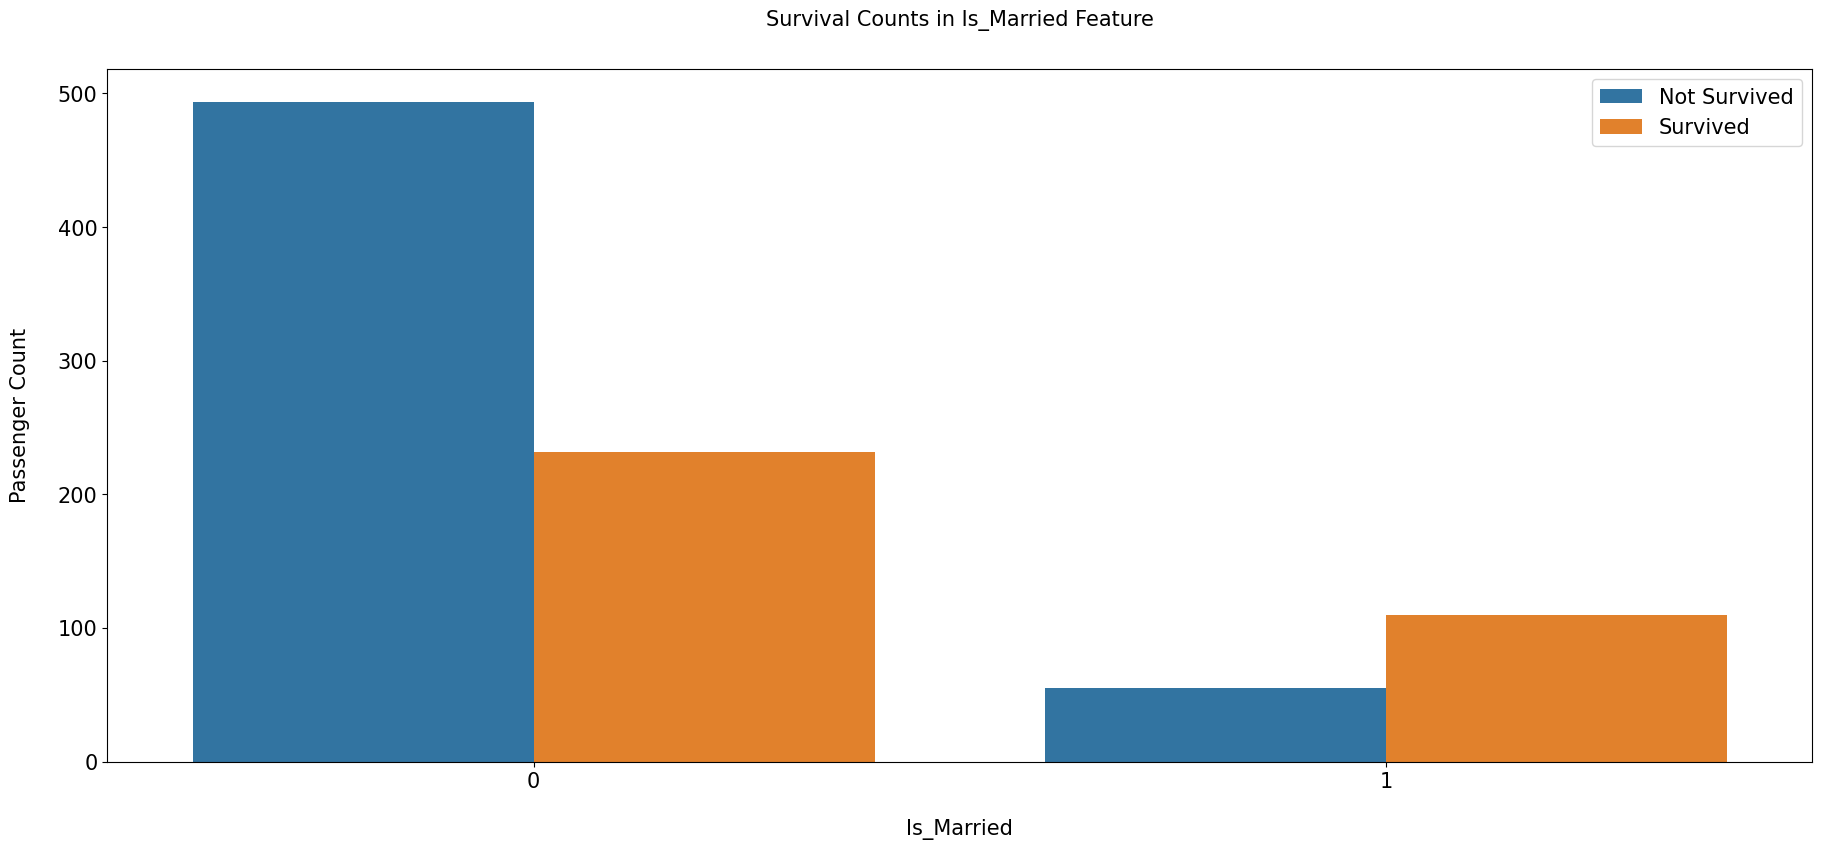

In [34]:
plot_binned_distribution_for('Is_Married', combined_df)

#### Continue adapting title 
Title Mrs was necessary for getting marital status, but not necessary to keep them split for the model. 

In [35]:
combined_df['Title'] = combined_df['Title'].replace(['Miss', 'Mrs'], 'Miss/Mrs')
# Master is relevant as its own category 
#combined_df['Title'] = combined_df['Title'].replace(['Master'], 'Mr')

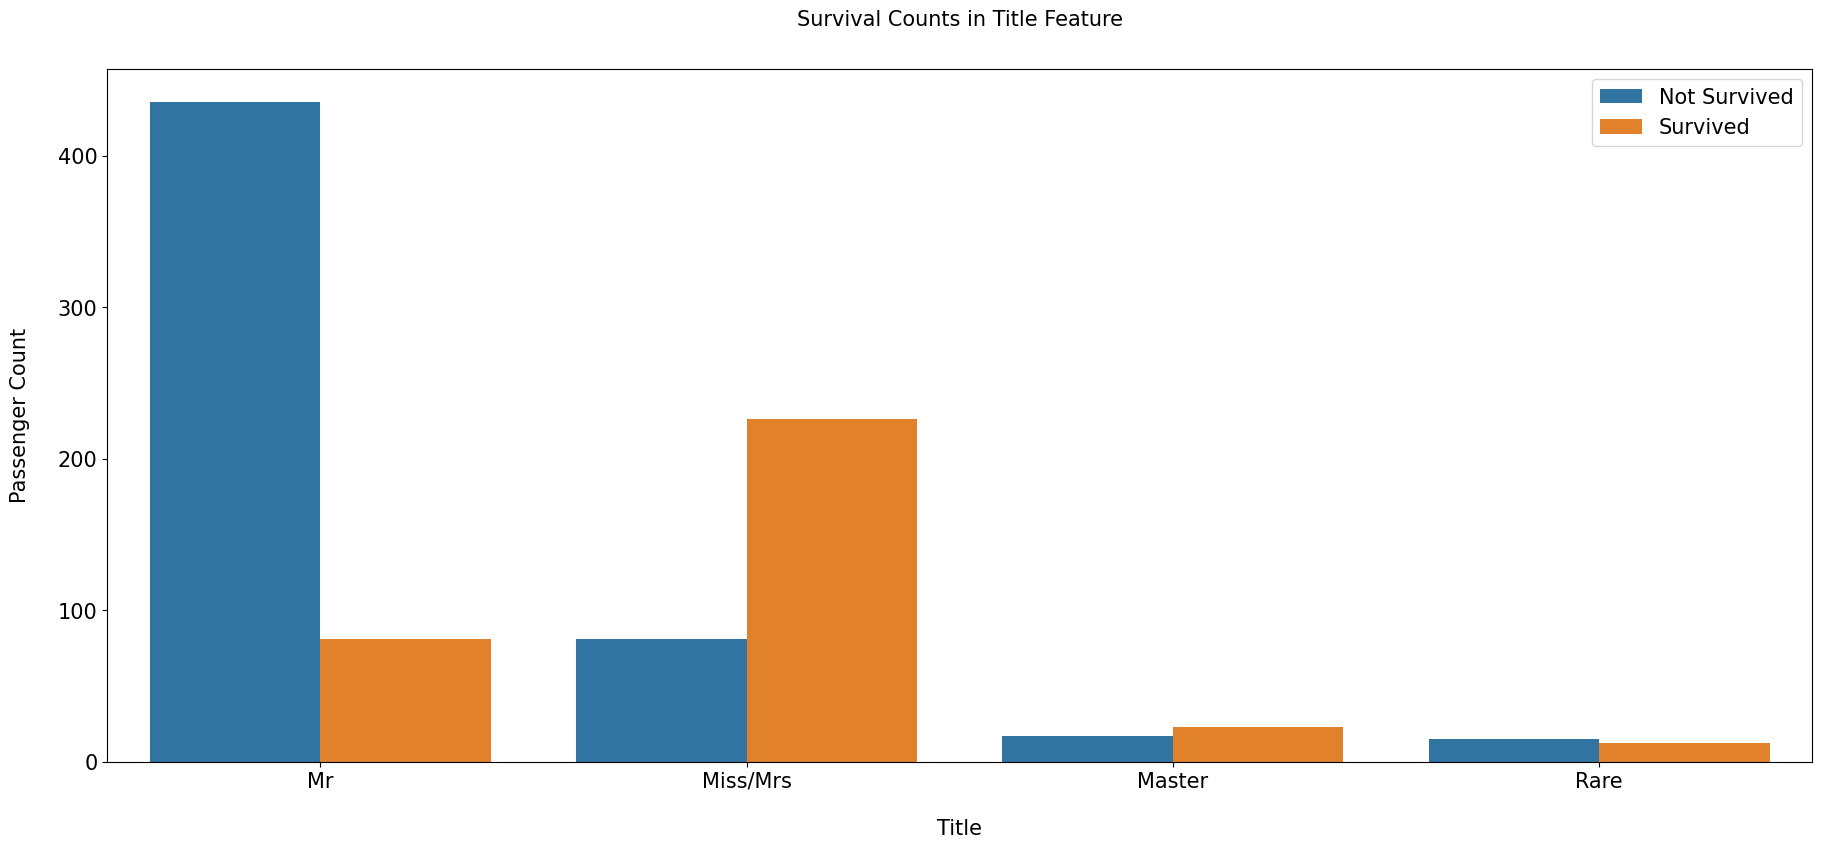

In [36]:
plot_binned_distribution_for('Title', combined_df)

#### Feature correlations 
Explore how features correlate to each other in order to determine, how to handle missing values. 


In [37]:
def get_feature_correlation_for(feature, df): 
    # calculate correlation matrix, take absolute values, unstack to turn into long format df, sort descending, remove multiindex 
    corr = df.select_dtypes(include=['number']).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    # rename cols for readability 
    corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
    corr.drop(corr[corr['Correlation Coefficient'] == 1.0].index, inplace=True)
    return corr[corr['Feature 1'] == feature]

In [38]:
get_feature_correlation_for('Age', combined_df)

,Feature 1,Feature 2,Correlation Coefficient
14,Age,Pclass,0.408
22,Age,Is_Married,0.268
26,Age,SibSp,0.244
41,Age,Fare,0.179
45,Age,Parch,0.151
54,Age,Survived,0.077
56,Age,Sex,0.066


##### Handle missing age values

Age and Pclass show a high correlation, which is supported by the data below. 

In [39]:
print("Missing values absolute in combined per class:")
print(combined_df.groupby('Pclass')['Age'].apply(lambda x: x.isnull().sum()))
print()
print("Missing values relative in combined per class:")
print(combined_df.groupby('Pclass')['Age'].apply(lambda x: x.isnull().mean() * 100))
print()
print("Age available in combined per class:")
print(combined_df.groupby('Pclass')['Age'].apply(lambda x: x.notnull().sum()))
print(combined_df.groupby('Pclass')['Age'].agg(['min', 'max', 'mean']))

Missing values absolute in combined per class:
Pclass
1     39
2     16
3    208
Name: Age, dtype: int64

Missing values relative in combined per class:
Pclass
1    12.074
2     5.776
3    29.337
Name: Age, dtype: float64

Age available in combined per class:
Pclass
1    284
2    261
3    501
Name: Age, dtype: int64
         min   max    mean
Pclass                    
1       0.92  80.0  39.160
2       0.67  70.0  29.507
3       0.17  74.0  24.816


In [40]:
def plot_age_distribution(df): 
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Pclass', y='Age', hue='Sex', data=df, palette='Set2')
    plt.title('Age Distribution by Pclass and Sex')
    plt.show()

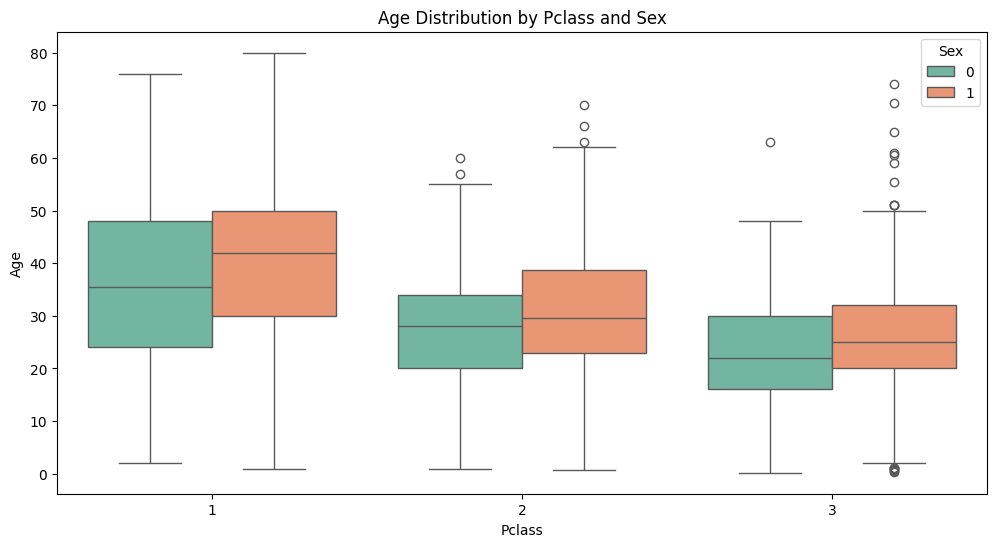

In [41]:
plot_age_distribution(combined_df)

##### Assign Passengers missing age values  
Age is an important denominator for surviving, especially whether one is an adult or a child. As seen above, some values are missing. Imputation is done based on each PClass and Sex age distribution. Median works better than random age in the age bracket. 

In [42]:
train_df, test_df = combined_df.loc[:891].copy(), combined_df.loc[892:].copy()

In [43]:
train_df['Age'] = train_df.groupby(['Pclass', 'Sex'], group_keys=False)['Age'].apply(
    lambda x: x.fillna(x.median()) # median works better than mean
    )

test_df['Age'] = test_df.groupby(['Pclass', 'Sex'], group_keys=False)['Age'].apply(
    lambda x: x.fillna(x.median())
    )

In [44]:
combined_df = combine_dfs(train_df, test_df)

In [45]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 1 to 1309
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         1309 non-null   float64
 1   Cabin       295 non-null    object 
 2   Embarked    1307 non-null   object 
 3   Fare        1308 non-null   float64
 4   First_Name  1289 non-null   object 
 5   Is_Married  1309 non-null   int64  
 6   Last_Name   1289 non-null   object 
 7   Name        1309 non-null   object 
 8   Parch       1309 non-null   int64  
 9   Pclass      1309 non-null   int64  
 10  Sex         1309 non-null   int32  
 11  SibSp       1309 non-null   int64  
 12  Survived    891 non-null    float64
 13  Ticket      1309 non-null   object 
 14  Title       1309 non-null   object 
dtypes: float64(3), int32(1), int64(4), object(7)
memory usage: 148.4+ KB


In [46]:
print(combined_df.groupby('Pclass')['Age'].agg(['min', 'max', 'mean']))

         min   max    mean
Pclass                    
1       0.92  80.0  39.237
2       0.67  70.0  29.470
3       0.17  74.0  24.499


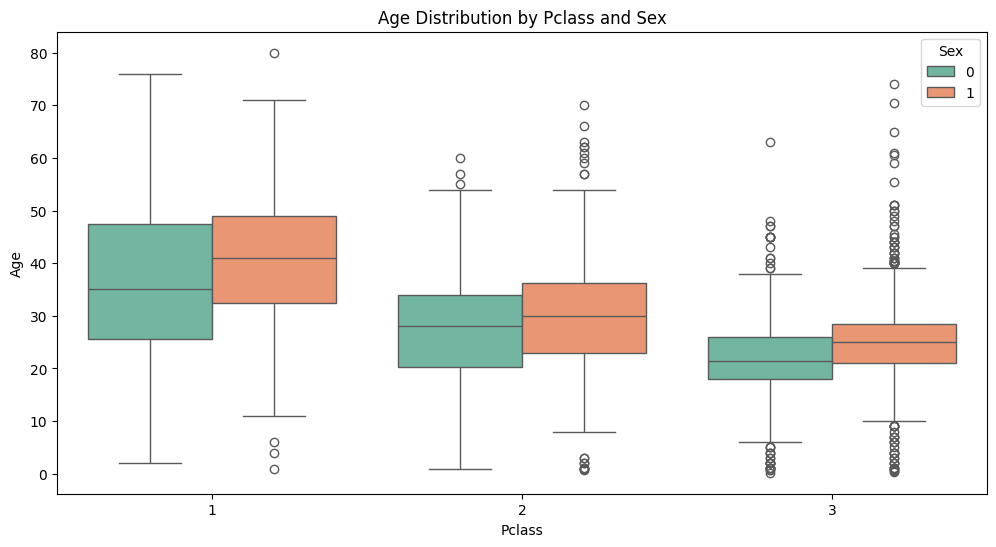

In [47]:
plot_age_distribution(combined_df)

The age is a factor that should be counted in for survival likelihood. First, we see that the likelyhood to survive is higher for passengers <= 15 (first three bins). Additionally, people between 35 and 40 seem to have a higher chance of surviving compared to the other brackets. 

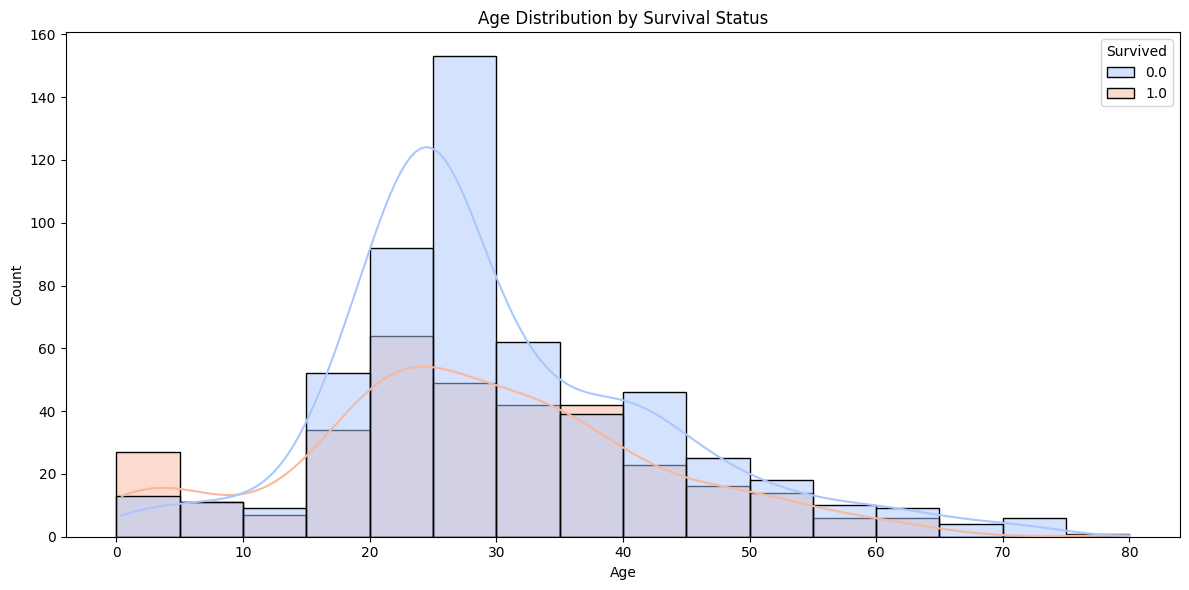

In [48]:
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='Age', bins=range(int(combined_df['Age'].min()) // 5 * 5, 
                                                     int(combined_df['Age'].max()) + 5, 5),
             hue='Survived', multiple="layer", kde=True, palette='coolwarm', edgecolor='black')

plt.title('Age Distribution by Survival Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Below the distribution of survival based on age and sex for each class. 

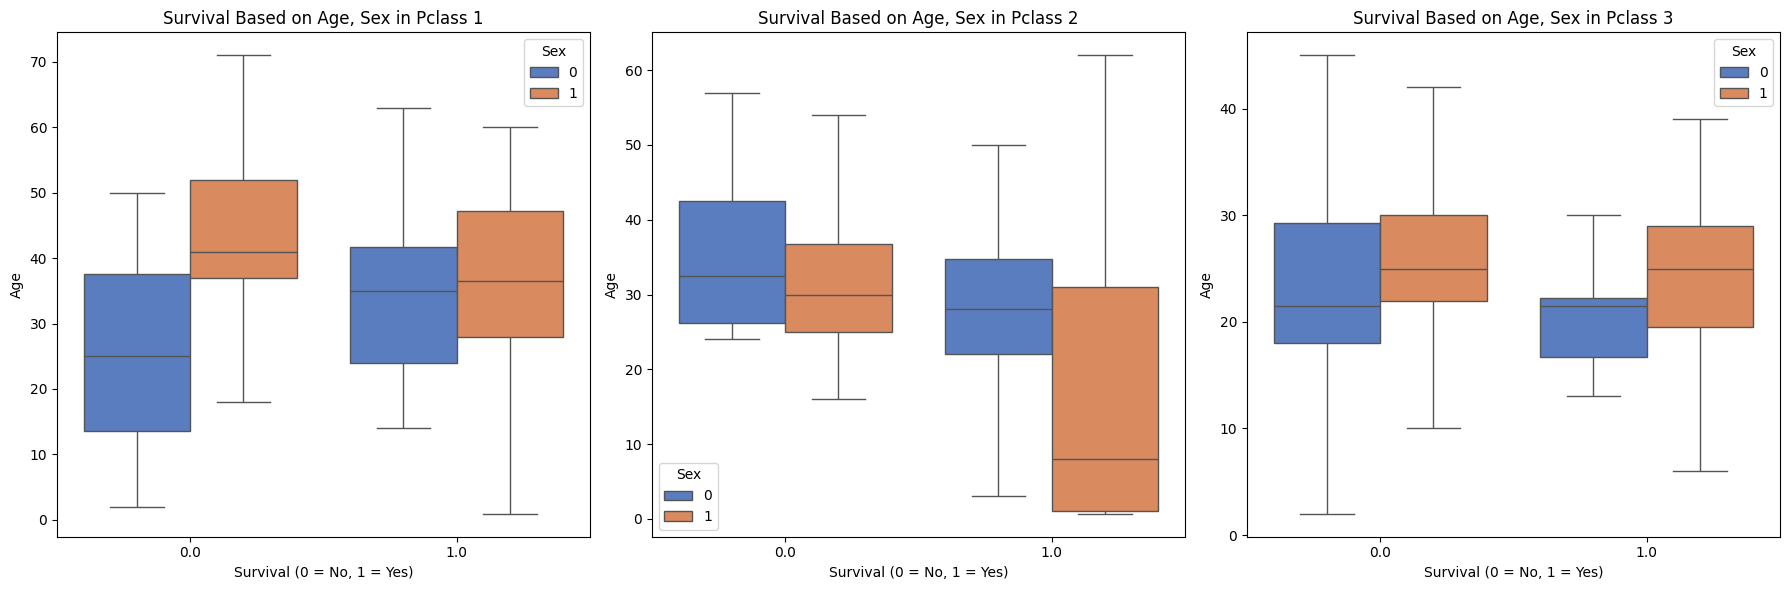

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, pclass in enumerate([1, 2, 3]):
    sns.boxplot(
        data=combined_df[combined_df['Pclass'] == pclass], 
        x='Survived', y='Age', hue='Sex', 
        palette='muted', showfliers=False, ax=axes[i]
    )
    axes[i].set_title(f'Survival Based on Age, Sex in Pclass {pclass}')
    axes[i].set_xlabel('Survival (0 = No, 1 = Yes)')
    axes[i].set_ylabel('Age')

plt.tight_layout()
plt.show()

Since children 'Women and children first' also includes children, a feature 'Age_Group' is introduced, which classifies passengers < 15 as Kids and passengers >= 15 as Adults. The age is choosen based on the assumption that Kids >= 15 often are not necessarily perceived as Kids anymore. Additionally, the survival statistics above for age show that the age advantage for kids dwindles above 15. Another age bracket is introduced with people >= 60 being classified as senior. Adapting the age groups as such showed positive results in testing. 

`Age_Group`: 0 - Kid, 1 - Adult, 2- Senior

In [50]:
# TODO: test additional age group in the middle

In [51]:
combined_df['Age_Group'] = combined_df['Age'].apply(lambda x: 0 if x <= 15 else (1 if x <= 60 else 2)).astype(int)  
print("Ratio of survived passengers in each age group:")
print(combined_df.groupby('Age_Group')['Survived'].mean().T)

Ratio of survived passengers in each age group:
Age_Group
0    0.590
1    0.366
2    0.227
Name: Survived, dtype: float64


In [52]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 1 to 1309
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         1309 non-null   float64
 1   Cabin       295 non-null    object 
 2   Embarked    1307 non-null   object 
 3   Fare        1308 non-null   float64
 4   First_Name  1289 non-null   object 
 5   Is_Married  1309 non-null   int64  
 6   Last_Name   1289 non-null   object 
 7   Name        1309 non-null   object 
 8   Parch       1309 non-null   int64  
 9   Pclass      1309 non-null   int64  
 10  Sex         1309 non-null   int32  
 11  SibSp       1309 non-null   int64  
 12  Survived    891 non-null    float64
 13  Ticket      1309 non-null   object 
 14  Title       1309 non-null   object 
 15  Age_Group   1309 non-null   int32  
dtypes: float64(3), int32(2), int64(4), object(7)
memory usage: 153.5+ KB


#### Missing Embarked Value 
Due to only two missing embarked values, the value is replaced with the most common one. 

In [53]:
combined_df[combined_df['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,First_Name,Is_Married,Last_Name,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Age_Group
62,38.0,B28,NaN,80.0,Amelie,0,Icard,"Icard, Miss. Amelie",0,1,0,0,1.0,113572,Miss/Mrs,1
830,62.0,B28,NaN,80.0,George Nelson,1,Stone,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,0,0,1.0,113572,Miss/Mrs,2


In [54]:
combined_df['Embarked'].value_counts()

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

In [55]:
combined_df['Embarked'] = combined_df['Embarked'].fillna('S')
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 1 to 1309
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         1309 non-null   float64
 1   Cabin       295 non-null    object 
 2   Embarked    1309 non-null   object 
 3   Fare        1308 non-null   float64
 4   First_Name  1289 non-null   object 
 5   Is_Married  1309 non-null   int64  
 6   Last_Name   1289 non-null   object 
 7   Name        1309 non-null   object 
 8   Parch       1309 non-null   int64  
 9   Pclass      1309 non-null   int64  
 10  Sex         1309 non-null   int32  
 11  SibSp       1309 non-null   int64  
 12  Survived    891 non-null    float64
 13  Ticket      1309 non-null   object 
 14  Title       1309 non-null   object 
 15  Age_Group   1309 non-null   int32  
dtypes: float64(3), int32(2), int64(4), object(7)
memory usage: 153.5+ KB


#### Handle missing fare value
Only one fare value is missing. Since the passenger travelled alone and was in 3rd class, the mean fare for this demographic will be used. 

In [56]:
combined_df[combined_df['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,First_Name,Is_Married,Last_Name,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Age_Group
1044,60.5,NaN,S,NaN,Thomas,0,Storey,"Storey, Mr. Thomas",0,3,1,0,NaN,3701,Mr,2


In [57]:
train_df = combined_df.loc[:891].copy()

# impute median fare based on train data, don't use test data for median() 
med_fare = train_df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]

combined_df['Fare'] = combined_df['Fare'].fillna(med_fare)

In [58]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 1 to 1309
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         1309 non-null   float64
 1   Cabin       295 non-null    object 
 2   Embarked    1309 non-null   object 
 3   Fare        1309 non-null   float64
 4   First_Name  1289 non-null   object 
 5   Is_Married  1309 non-null   int64  
 6   Last_Name   1289 non-null   object 
 7   Name        1309 non-null   object 
 8   Parch       1309 non-null   int64  
 9   Pclass      1309 non-null   int64  
 10  Sex         1309 non-null   int32  
 11  SibSp       1309 non-null   int64  
 12  Survived    891 non-null    float64
 13  Ticket      1309 non-null   object 
 14  Title       1309 non-null   object 
 15  Age_Group   1309 non-null   int32  
dtypes: float64(3), int32(2), int64(4), object(7)
memory usage: 153.5+ KB


A look into the fare distribution by survival status shows that fare is correlated with surviving, however this is to be expected, since 1st class tickets are more expensive and 1st class passengers were more likely to survive. 

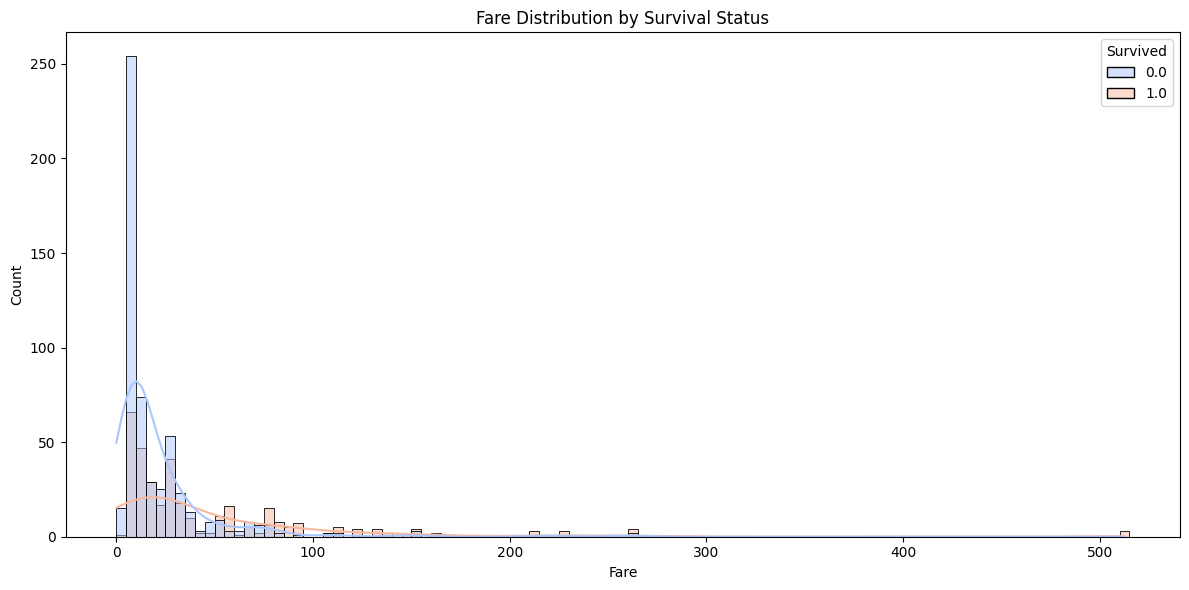

In [59]:
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='Fare', bins=range(int(combined_df['Fare'].min()) // 5 * 5, 
                                                     int(combined_df['Fare'].max()) + 5, 5),
             hue='Survived', multiple="layer", kde=True, palette='coolwarm', edgecolor='black')

plt.title('Fare Distribution by Survival Status')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


#### Missing cabin values
Cabin values are mostly unknown. However, the letter in the given cabins indicate the deck level of a passenger, which is crucial information, since life boats were available on the sun deck, which is the top most deck. The further down we go, the further away are the life boats.  

It might have some influence, where a cabin was located. Therefore, non-existing values are replaced with U for unknown and existing values are mapped to their level letter. 
Replace NaN with U for Unkown.

See the Deck levels of the titanic below: 
![Deck Level Distribution](https://i.pinimg.com/originals/73/90/a6/7390a6730ca3c56602bc0495910c1a54.png)

Additionally, see the class distribution on the deck levels below: 
![Titanic Class distribution](https://images-cdn.bridgemanimages.com/api/1.0/image/600wm.XXX.88751270.7055475/7212609.jpg)

Another factor is access to lifeboats, displayed below: 

![Life Boat access](https://courses.bowdoin.edu/history-2203-fall-2020-kmoyniha/wp-content/uploads/sites/473/2020/12/lifeboat-access.png)

#### Feature engineering based on available cabin data

##### Check the distribution of classes in the deck levels 
Class only is not necessarily a well enough indicator for the survival, since some levels are more mixed than others. However, the lower the deck, the worse the chance of survival. 

In [60]:
# when there is more than one deck level, assign the lowest one 
def get_highest_letter(letters):
    if not isinstance(letters, list) or len(letters) == 0:
       return "U"
    # If all letters are the same, return the first one
    if len(set(letters)) == 1:
        return letters[0]
    # If not, return the highest letter alphabetically
    return max(letters)    

combined_df['Cabin_Letters_all'] = combined_df['Cabin'].str.findall('([A-Za-z]+)')
combined_df['Deck_Level'] = combined_df['Cabin_Letters_all'].apply(get_highest_letter)
print(combined_df["Deck_Level"].value_counts())

Deck_Level
U    1014
C      94
B      65
D      46
E      41
A      22
F      17
G       9
T       1
Name: count, dtype: int64


#### Deck and Cabin based feature engineering

##### Investigate deck levels and create deck level based features

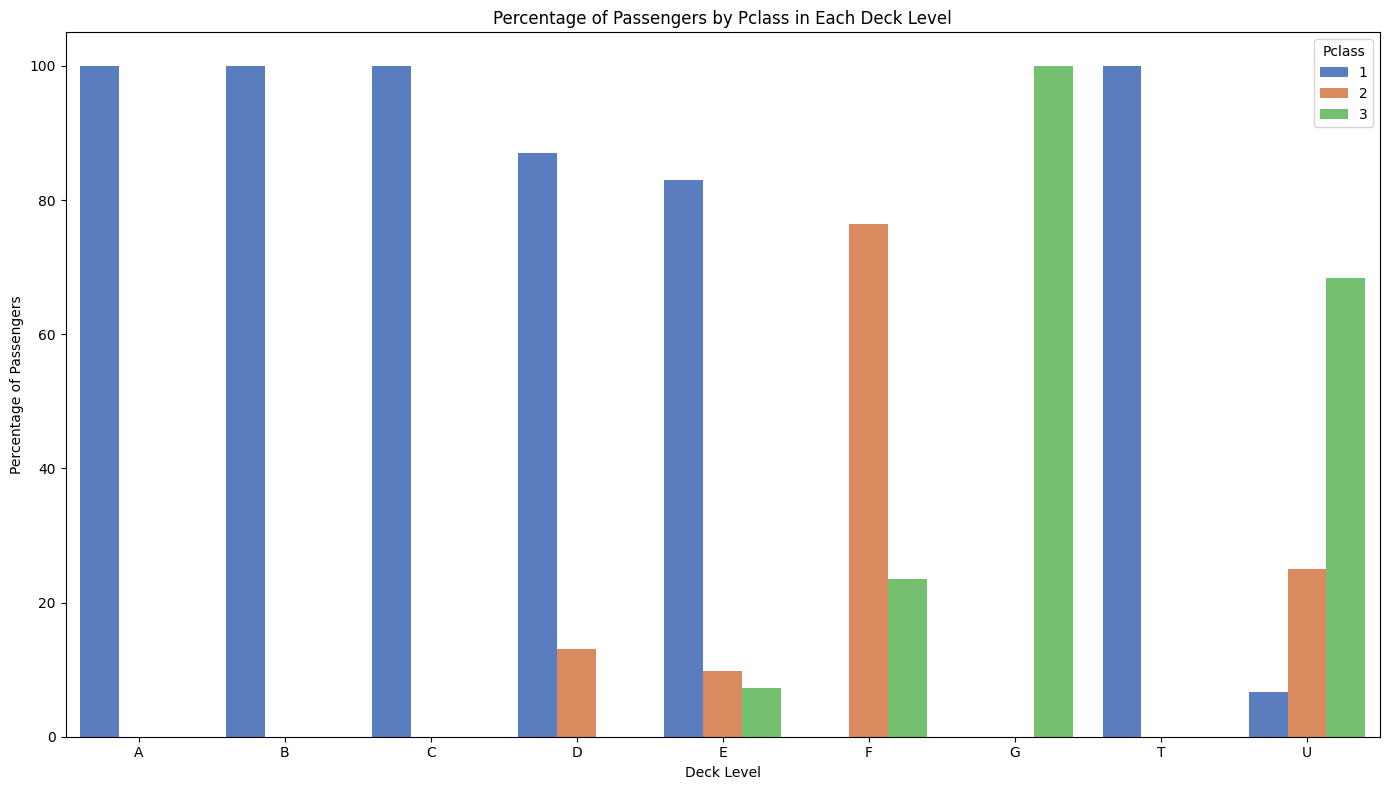

In [61]:
deck_pclass_counts = combined_df.groupby(['Deck_Level', 'Pclass']).size().reset_index(name='Count')

# Get the total count of passengers in each Deck Level
deck_total_counts = combined_df.groupby('Deck_Level').size().reset_index(name='Total_Count')

# Merge the two dataframes to calculate the percentage
merged_df = pd.merge(deck_pclass_counts, deck_total_counts, on='Deck_Level')
merged_df['Percentage'] = (merged_df['Count'] / merged_df['Total_Count']) * 100

plt.figure(figsize=(14, 8))
sns.barplot(data=merged_df, x='Deck_Level', y='Percentage', hue='Pclass', palette='muted')
plt.title('Percentage of Passengers by Pclass in Each Deck Level')
plt.xlabel('Deck Level')
plt.ylabel('Percentage of Passengers')
plt.legend(title='Pclass', loc='upper right')
plt.tight_layout()
plt.show()

Since class T is only occuring once and it only has a Pclass 1 passenger, it is added to A.

In [62]:
idx = combined_df[combined_df['Deck_Level'] == 'T'].index
combined_df.loc[idx, 'Deck_Level'] = 'A'

There seems to be a correlation between deck level and survivals, as implied by images in description. Displaying survival rates based on deck level confirms the suspicion. Thus it is valid to group the deck levels into entities. A, B and C are only occupied by Class 1, thus they can be grouped together. 

In [63]:
deck_counts = combined_df.groupby(['Pclass', 'Deck_Level']).size().reset_index(name='Count')
deck_counts.sort_values(by=['Pclass', 'Deck_Level'], ascending=[True, True])

,Pclass,Deck_Level,Count
0,1,A,23
1,1,B,65
2,1,C,94
3,1,D,40
4,1,E,34
5,1,U,67
6,2,D,6
7,2,E,4
8,2,F,13
9,2,U,254


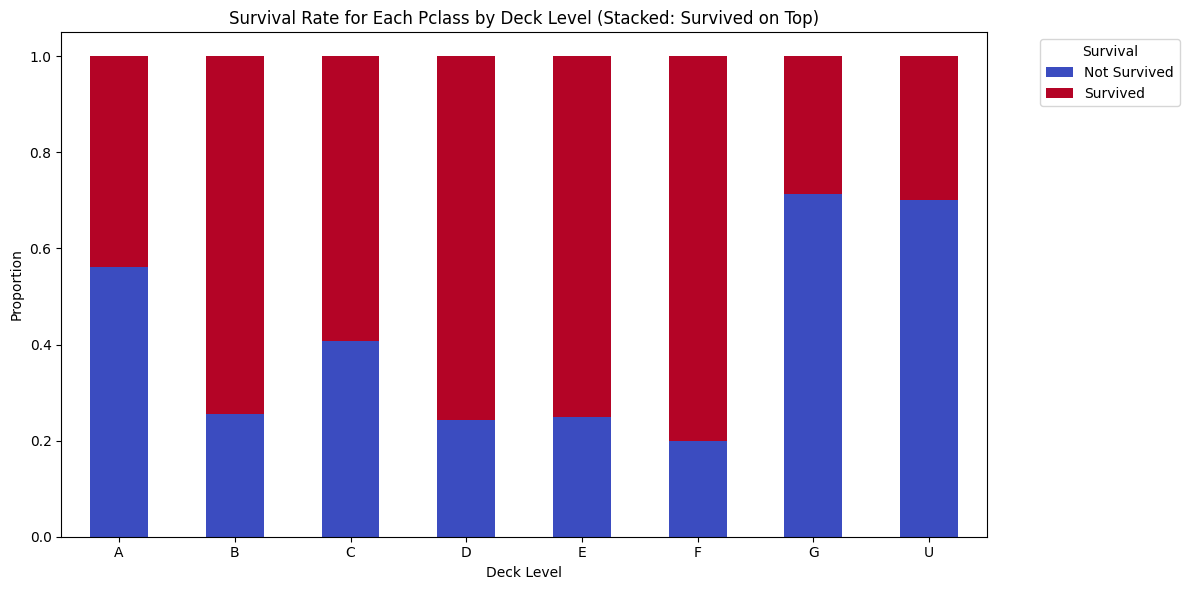

In [64]:
survival_counts = combined_df.groupby(['Deck_Level', 'Survived']).size().unstack(fill_value=0)

# Calculate the survival rate (proportion) for each group
survival_counts['Survived_Rate'] = survival_counts[1] / (survival_counts[0] + survival_counts[1])
survival_counts['Not_Survived_Rate'] = survival_counts[0] / (survival_counts[0] + survival_counts[1])

ax = survival_counts[['Not_Survived_Rate','Survived_Rate']].plot(kind='bar', stacked=True, figsize=(12, 6), cmap='coolwarm')
plt.title('Survival Rate for Each Pclass by Deck Level (Stacked: Survived on Top)')
plt.xlabel('Deck Level')
plt.ylabel('Proportion')
plt.xticks(rotation=0)

plt.legend(title='Survival', labels=['Not Survived', 'Survived' ], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [65]:
# map the levels to numerical values for correlation calculations
cabin_counts = combined_df["Deck_Level"].value_counts().sort_index(ascending=False).reset_index()
zipped = list(zip(cabin_counts['Deck_Level'], cabin_counts.index))
dict_cabin = dict(zipped)
print(dict_cabin)
combined_df["Deck_Level_num"] = combined_df["Deck_Level"].map(dict_cabin)

{'U': 0, 'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7}


In [66]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 1 to 1309
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1309 non-null   float64
 1   Cabin              295 non-null    object 
 2   Embarked           1309 non-null   object 
 3   Fare               1309 non-null   float64
 4   First_Name         1289 non-null   object 
 5   Is_Married         1309 non-null   int64  
 6   Last_Name          1289 non-null   object 
 7   Name               1309 non-null   object 
 8   Parch              1309 non-null   int64  
 9   Pclass             1309 non-null   int64  
 10  Sex                1309 non-null   int32  
 11  SibSp              1309 non-null   int64  
 12  Survived           891 non-null    float64
 13  Ticket             1309 non-null   object 
 14  Title              1309 non-null   object 
 15  Age_Group          1309 non-null   int32  
 16  Cabin_Letters_all  295 n

In [67]:
get_feature_correlation_for('Deck_Level_num', combined_df)

,Feature 1,Feature 2,Correlation Coefficient
10,Deck_Level_num,Pclass,0.735
16,Deck_Level_num,Fare,0.549
27,Deck_Level_num,Age,0.340
32,Deck_Level_num,Survived,0.292
55,Deck_Level_num,Is_Married,0.187
67,Deck_Level_num,Age_Group,0.133
75,Deck_Level_num,Sex,0.118
94,Deck_Level_num,Parch,0.033
99,Deck_Level_num,SibSp,0.008


Simply the fact if info is available or not might be interesting, since a lot of passengers' deck level is unkown anyway.

In [68]:
combined_df["Deck_Known"] = 0
combined_df.loc[combined_df['Deck_Level'] != 'U', 'Deck_Known'] = 1
combined_df["Deck_Known"].value_counts()

Deck_Known
0    1014
1     295
Name: count, dtype: int64

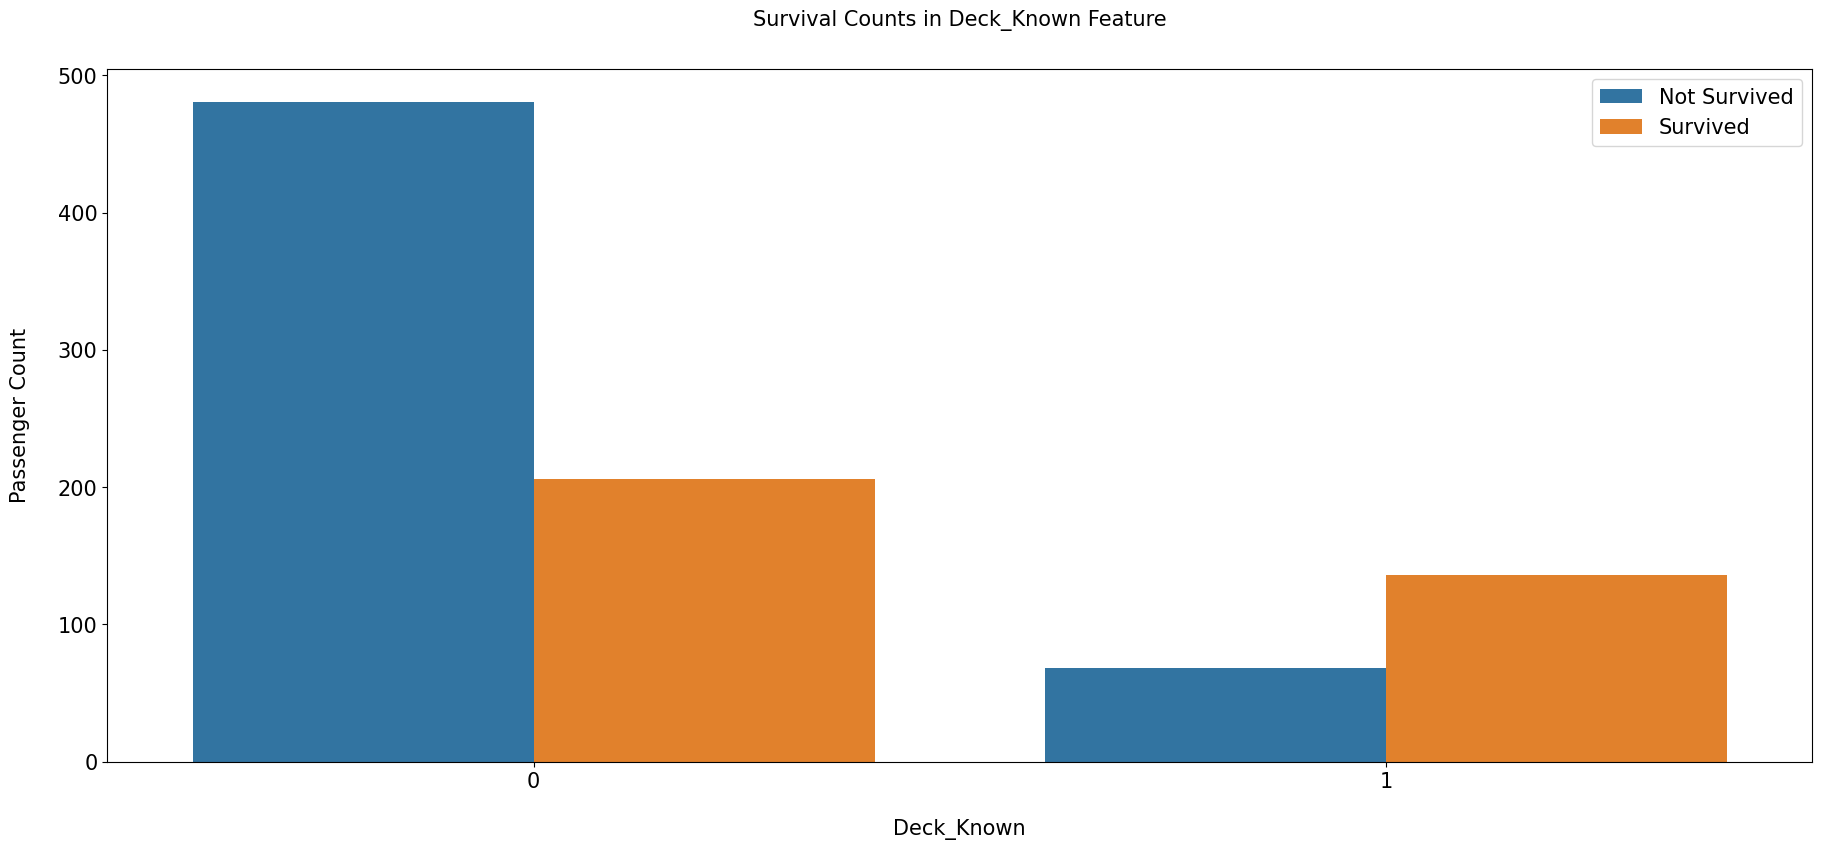

In [69]:
plot_binned_distribution_for('Deck_Known', combined_df)

In [70]:
combined_df.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'First_Name', 'Is_Married',
       'Last_Name', 'Name', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived',
       'Ticket', 'Title', 'Age_Group', 'Cabin_Letters_all', 'Deck_Level',
       'Deck_Level_num', 'Deck_Known'],
      dtype='object')

##### Get stair proximity

In [71]:
# get numerical value from cabin value to display statistics 
combined_df['Cabin_numeric_all'] = combined_df['Cabin'].str.findall('(\d+)')
combined_df.head(2)

,Age,Cabin,Embarked,Fare,First_Name,Is_Married,Last_Name,Name,Parch,Pclass,...,SibSp,Survived,Ticket,Title,Age_Group,Cabin_Letters_all,Deck_Level,Deck_Level_num,Deck_Known,Cabin_numeric_all
1,22.0,NaN,S,7.250,Owen Harris,0,Braund,"Braund, Mr. Owen Harris",0,3,...,1,0.0,A/5 21171,Mr,1,NaN,U,0,0,NaN
2,38.0,C85,C,71.283,John Bradley,1,Cumings,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,...,1,1.0,PC 17599,Miss/Mrs,1,[C],C,5,1,[85]


In [72]:
flat = combined_df['Cabin_numeric_all'].explode().dropna().astype(float)
flat.describe().agg(['max', 'min', 'mean'])

max     343.000
min       2.000
mean     89.281
Name: Cabin_numeric_all, dtype: float64

In [73]:
# parse cabins to split into letter and number values
def parse_cabins(cabin):
    if pd.isna(cabin):
        return [('Unknown', 0)]  # Default for missing cabins
    cabins = cabin.split()  # Split into individual cabins
    parsed = []
    for c in cabins:
        deck = c[0]  # Extract deck
        number = float(c[1:]) if c[1:].isdigit() else 0  # Extract cabin number
        parsed.append((deck, number))
    return parsed

combined_df['Parsed_Cabins'] = combined_df['Cabin'].apply(parse_cabins)
combined_df[['Cabin', 'Parsed_Cabins']]

,Cabin,Parsed_Cabins
1,NaN,"[(Unknown, 0)]"
2,C85,"[(C, 85.0)]"
3,NaN,"[(Unknown, 0)]"
4,C123,"[(C, 123.0)]"
5,NaN,"[(Unknown, 0)]"
...,...,...
1305,NaN,"[(Unknown, 0)]"
1306,C105,"[(C, 105.0)]"
1307,NaN,"[(Unknown, 0)]"
1308,NaN,"[(Unknown, 0)]"


In [74]:
# https://titanic.fandom.com/wiki info about cabins taken from there

# Assign Proximity Scores based on Deck and Cabin Number
def calculate_cabin_proximity(deck, cabin_number, pclass):
    # Higher decks are closer to the Grand Staircase
    if deck in ['A', 'B', 'C']:
        proximity = 6  # Highest proximity - first class upper decks
    elif deck in ['D', 'E']:
        if pclass == 1: 
            proximity = 5 # little less, first class, but bit lower
        elif pclass == 2: 
            proximity = 4 # little less, second class, higher decks of second class
        elif pclass == 3: 
            proximity = 3 
    elif deck == 'F':
        if pclass == 2: 
            proximity = 3
        elif pclass == 3:
            if 20 <= cabin_number <= 100: # stern bit more time
                proximity = 2
            else: 
                proximity = 1 # bow end, flooded almost immediately, worst access to stairs
    
    elif deck == 'G':
        if pclass == 2: 
            proximity = 3
        elif pclass == 3:
            if 201 <= cabin_number <= 222: # stern bit more time
                proximity = 2
            else: 
                proximity = 1 # bow end, flooded almost immediately, worst access to stairs
    else:
        proximity = 0  # Default for unknown decks
    
    return proximity

# Calculate proximity for all cabins given
def calculate_total_proximity(parsed_cabins, pclass):
    total_proximity = 0
    
    for deck, cabin_number in parsed_cabins:
        total_proximity += calculate_cabin_proximity(deck, cabin_number, pclass)
    return total_proximity / len(parsed_cabins) if len(parsed_cabins) > 0 else 0



def calculate_total_proximity_imputed(deck, cabin_number, pclass):
    return  calculate_cabin_proximity(deck, cabin_number, pclass)

In [75]:
combined_df['Adjusted_StairProximity'] = combined_df.apply(
    lambda row: calculate_total_proximity(row['Parsed_Cabins'], row['Pclass']), axis=1
)
    
combined_df['Adjusted_StairProximity_Missing'] = 0  
combined_df.loc[combined_df['Adjusted_StairProximity'] == 0, 'Adjusted_StairProximity_Missing'] = 1

combined_df[['Cabin', 'Parsed_Cabins', 'Adjusted_StairProximity', 'Adjusted_StairProximity_Missing']].head()

,Cabin,Parsed_Cabins,Adjusted_StairProximity,Adjusted_StairProximity_Missing
1,NaN,"[(Unknown, 0)]",0.0,1
2,C85,"[(C, 85.0)]",6.0,0
3,NaN,"[(Unknown, 0)]",0.0,1
4,C123,"[(C, 123.0)]",6.0,0
5,NaN,"[(Unknown, 0)]",0.0,1


In [76]:
combined_df['Adjusted_StairProximity'].value_counts()

Adjusted_StairProximity
0.0    1015
6.0     181
5.0      74
3.0      16
4.0      10
1.0       9
2.0       4
Name: count, dtype: int64

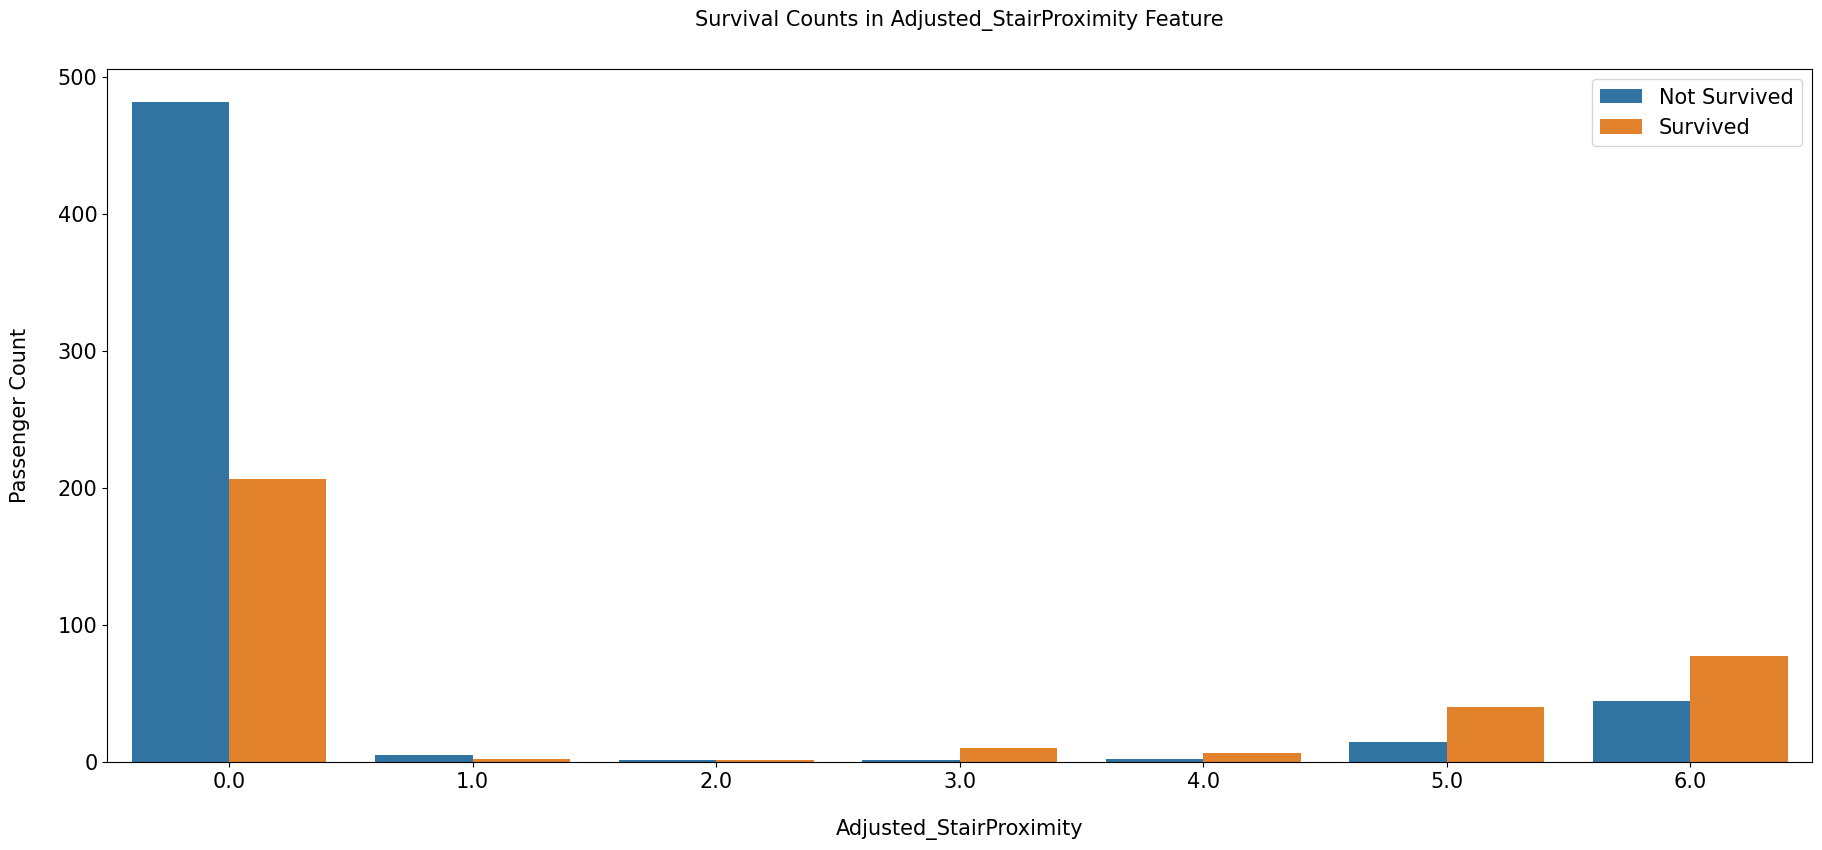

In [77]:
plot_binned_distribution_for('Adjusted_StairProximity', combined_df)

##### Categorize deck level


In [78]:
def categorize_deck(deck): 
    upper_decks = ['A', 'B', 'C']
    middle_decks = ['D', 'E']
    if deck == 'U': 
        return 'NA'
    if deck in upper_decks: 
        return 'UD'
    if deck in middle_decks: 
        return 'MD'
    else: 
        return 'LD'

In [79]:
# based on https://www.encyclopedia-titanica.org/titanic-deckplans/
# categorize cabin decks level wise into UD (upper decks), LD (lower decks) and NA (not available) 
combined_df['Deck_Category'] = combined_df['Deck_Level'].apply(categorize_deck)
print(combined_df['Deck_Category'].value_counts())
print()
print("Survival status in relation to Pclass & Deck Level: ")
print(combined_df.groupby(['Survived', 'Pclass'])['Deck_Level'].value_counts())

Deck_Category
NA    1014
UD     182
MD      87
LD      26
Name: count, dtype: int64

Survival status in relation to Pclass & Deck Level: 
Survived  Pclass  Deck_Level
0.0       1       C              24
                  U              21
                  B              12
                  A               9
                  D               7
                  E               7
          2       U              94
                  D               1
                  E               1
                  F               1
          3       U             366
                  G               5
                  F               1
1.0       1       B              35
                  C              35
                  D              22
                  U              19
                  E              18
                  A               7
          2       U              74
                  F               7
                  D               3
                  E               3
     

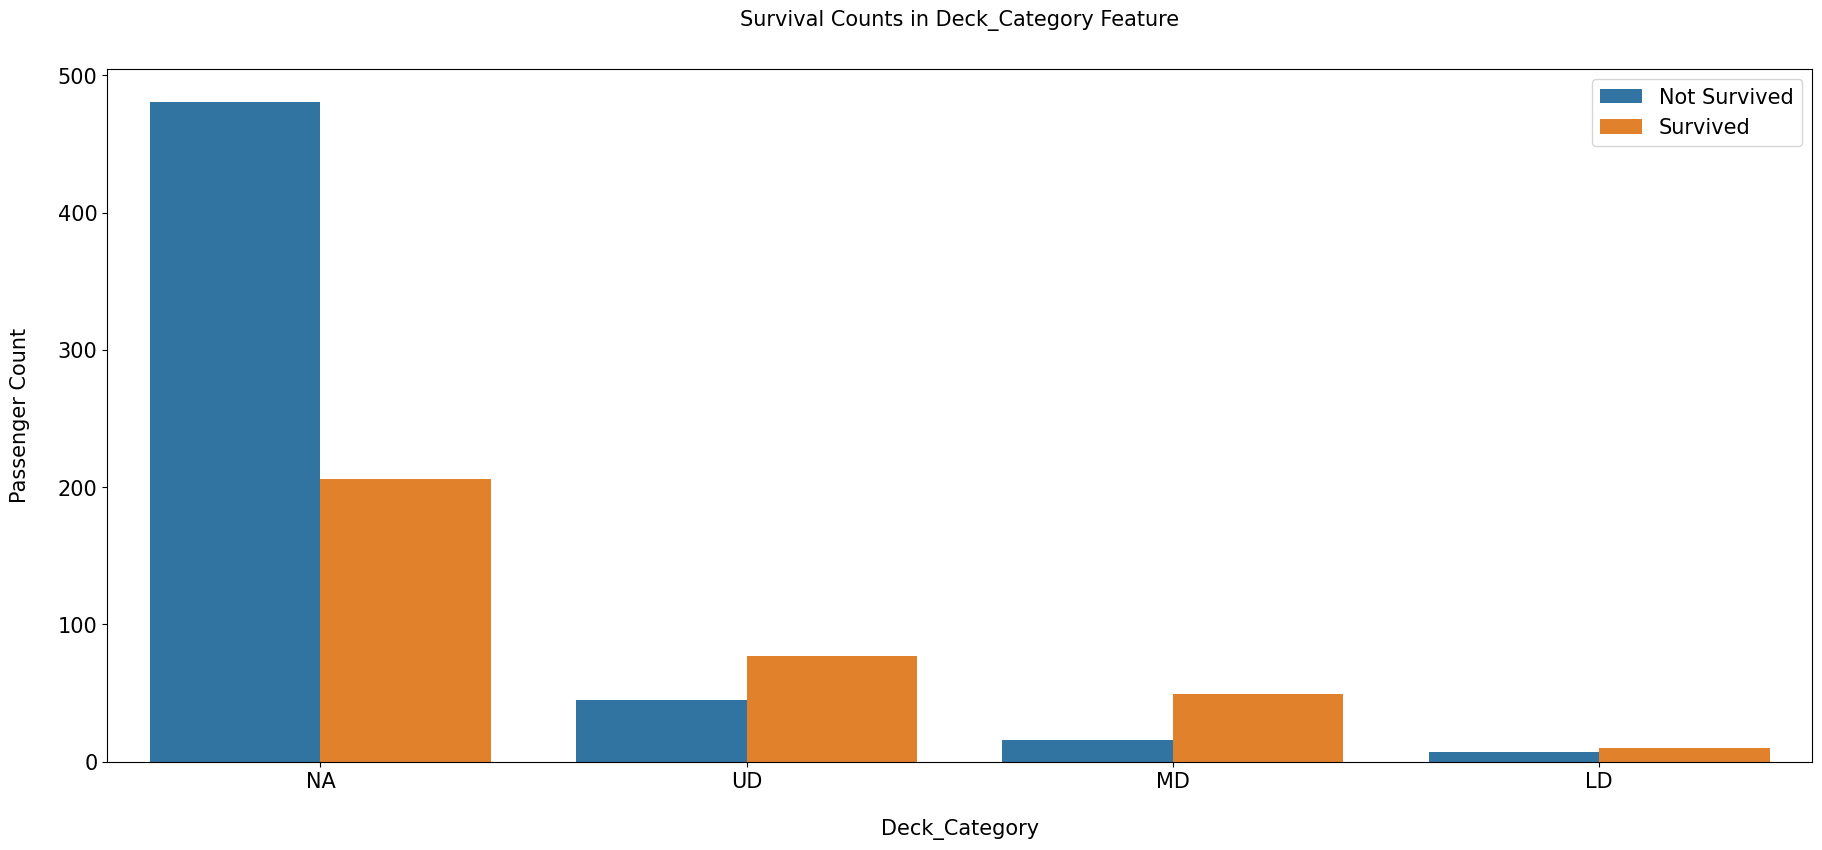

In [80]:
plot_binned_distribution_for('Deck_Category', combined_df)

#### Target Label Distribution

#### Survival Rate overall

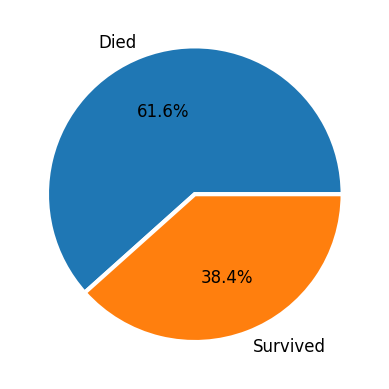

In [81]:
ax = combined_df.Survived.replace({0: 'Died', 1: 'Survived'}).value_counts().plot.pie(autopct='%.1f%%', 
                                                                             wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, 
                                                                             textprops=dict(size='large')).set_ylabel('')

#### Survival by age and class

In [82]:
def plot_survival_distri_based_on_pclass_sex(grouped, group):
    grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'orange'])
    
    plt.title(f'Survival vs. Death based on Pclass and Sex {group}')
    plt.xlabel('Pclass and Sex')
    plt.ylabel('Number of People')
    plt.xticks(rotation=45)
    plt.legend(title='Survived', labels=['Died', 'Survived'])
    
    plt.tight_layout()
    plt.show()


Survived    0.0  1.0
Pclass Sex          
1      0      1    1
       1      0    3
2      0      0   10
       1      0    9
3      0     14   13
       1     18    9


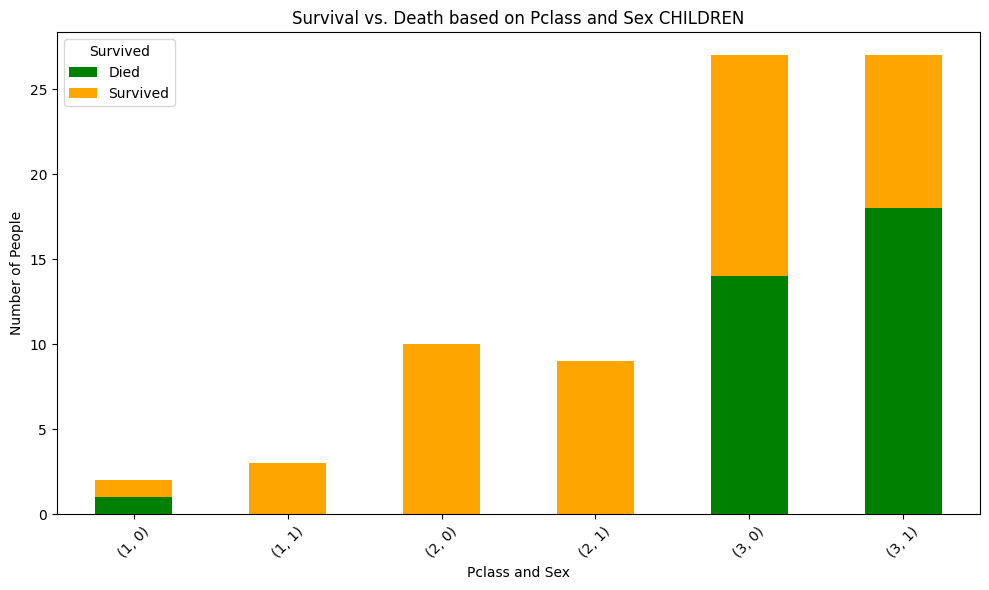

In [83]:
# Kids in each Pclass survival overview 
grouped_data_kids = combined_df[(combined_df['Age'] < 15)].groupby(['Pclass', 'Sex', 'Survived']).size().unstack(fill_value=0)
print(grouped_data_kids)
plot_survival_distri_based_on_pclass_sex(grouped_data_kids, "CHILDREN")

Survived    0.0  1.0
Pclass Sex          
1      0      2   88
       1     77   43
2      0      6   60
       1     91    8
3      0     58   56
       1    281   38


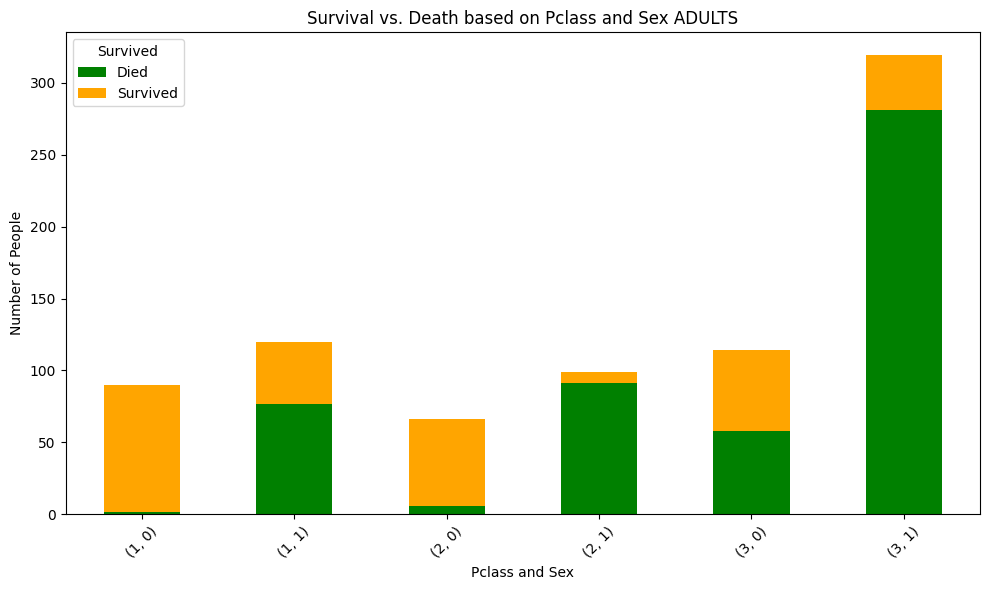

In [84]:
# Adults in each Pclass survival overview 
grouped_data_adults = combined_df[~(combined_df['Age'] <= 15)].groupby(['Pclass', 'Sex', 'Survived']).size().unstack(fill_value=0)
print(grouped_data_adults)
plot_survival_distri_based_on_pclass_sex(grouped_data_adults, "ADULTS")

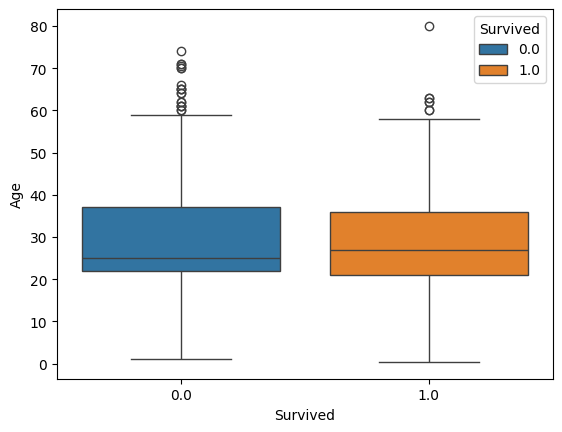

In [85]:
sns.boxplot(train_df, x='Survived', y='Age', hue='Survived');

####

#### Split the combined set for correlation and distribution in each set

In [86]:
train_df, test_df = combined_df.loc[:891].copy(), combined_df.loc[892:].copy().drop(['Survived'], axis=1)

#### Feature correlations in each set

In [87]:
def create_correlation_matrix(df): 
    df_corr = df.select_dtypes(include=['number']).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
    df_corr.drop(df_corr.iloc[1::2].index, inplace=True)
    return df_corr.drop(df_corr[df_corr['Correlation Coefficient'] == 1.0].index)

In [88]:
train_df_corr = create_correlation_matrix(train_df)
corr = train_df_corr['Correlation Coefficient'] > 0.1
train_df_corr[corr]

,Feature 1,Feature 2,Correlation Coefficient
14,Deck_Known,Adjusted_StairProximity_Missing,0.997
16,Adjusted_StairProximity,Deck_Level_num,0.976
18,Adjusted_StairProximity_Missing,Adjusted_StairProximity,0.969
20,Adjusted_StairProximity,Deck_Known,0.966
22,Deck_Known,Deck_Level_num,0.940
...,...,...,...
126,Adjusted_StairProximity,Age_Group,0.122
128,Sex,SibSp,0.116
130,Deck_Level_num,Sex,0.113
132,SibSp,Is_Married,0.109


In [89]:
test_df_corr = create_correlation_matrix(test_df)
corr = test_df_corr['Correlation Coefficient'] > 0.1
test_df_corr[corr]

,Feature 1,Feature 2,Correlation Coefficient
14,Deck_Level_num,Adjusted_StairProximity,0.984
16,Adjusted_StairProximity_Missing,Adjusted_StairProximity,0.972
18,Deck_Known,Adjusted_StairProximity,0.972
20,Adjusted_StairProximity_Missing,Deck_Level_num,0.947
22,Deck_Known,Deck_Level_num,0.947
24,Pclass,Adjusted_StairProximity,0.728
26,Deck_Level_num,Pclass,0.710
28,Pclass,Adjusted_StairProximity_Missing,0.691
30,Pclass,Deck_Known,0.691
32,Age_Group,Age,0.633


In [90]:
def output_feature_distributions(df): 
    df_plot = train_df.drop(columns=['Name', 'Ticket', 'Cabin'])
    df_categorical = df_plot[['Survived', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'Sex', 'Deck_Category']]
    #df_categorical = df_plot.select_dtypes(include=['category', 'object'])
    df_numeric = df_plot[['Age', 'Fare']]
    
    num_plots = len(df_numeric.columns) + len(df_categorical.columns)
    ncols = 3  
    nrows = (num_plots // ncols) + (num_plots % ncols > 0)  
    
    plt.figure(figsize=(ncols * 5, nrows * 5))
    
    for i, column in enumerate(df_numeric.columns):
        plt.subplot(nrows, ncols, i+1)  
        sns.histplot(df_numeric[column], kde=True, bins=20, color="skyblue", linewidth=0)
        plt.title(f'Distribution of {column}')
    
    for j, column in enumerate(df_categorical.columns, start=len(df_numeric.columns)+1):
        plt.subplot(nrows, ncols, j)
        sns.countplot(data=df_categorical, x=column, hue=column, legend=False, palette="Set2")
        plt.title(f'Distribution of {column}')
        
    plt.tight_layout()
    plt.show()
    

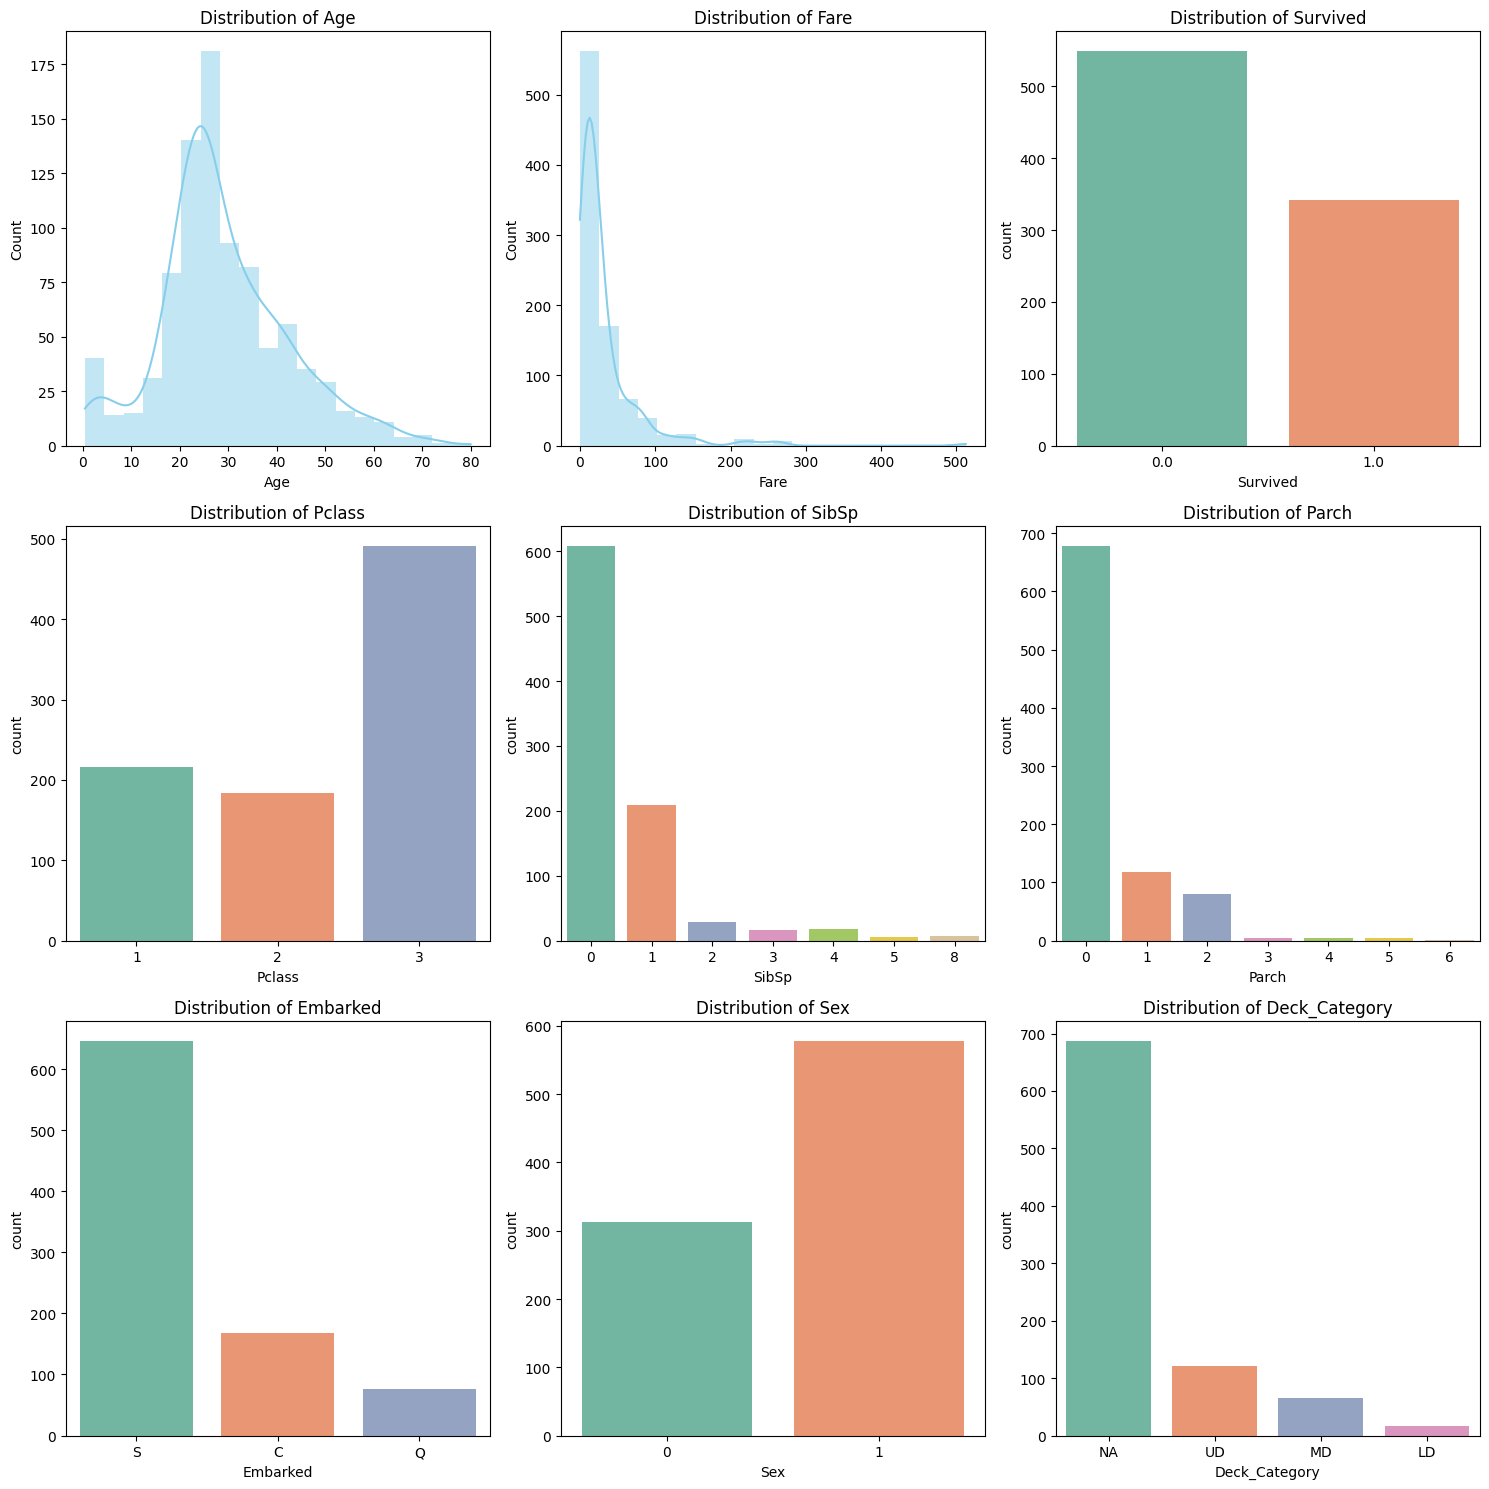

In [91]:
output_feature_distributions(train_df)

In [92]:
get_feature_correlation_for('Survived', train_df)

,Feature 1,Feature 2,Correlation Coefficient
38,Survived,Sex,0.541
53,Survived,Pclass,0.338
57,Survived,Adjusted_StairProximity_Missing,0.320
60,Survived,Deck_Known,0.317
63,Survived,Adjusted_StairProximity,0.311
70,Survived,Deck_Level_num,0.292
74,Survived,Is_Married,0.277
78,Survived,Fare,0.257
105,Survived,Age_Group,0.141
144,Survived,Parch,0.082


Many features are correlated with each other (such as Fare, Pclass, Age), which is important for meaningful feature engineering, e.g., to capture interactions. 
Target encoding can be useful for some of the categorical features, due to their high correlation with survival. 
The continuous features show spikes, which will be useful for a tree based approach. 

#### Bin age
Age is splitted into age groups to account for different survival likelihoods based on age. 10 was choosen due to previous observations that passengers <= 15 are more likely to survive. This group was meant to captured by that. 

In [93]:
# split into train and test to not leak quantille distributions
train_df, test_df = combined_df.loc[:891].copy(), combined_df.loc[892:].copy()

#bins = range(int(train_df['Age'].min()) // 5 * 5,  int(train_df['Age'].max()) + 5, 5)
#train_df['Age_Binned'] = pd.cut(train_df['Age'], bins, labels=False, duplicates='drop')

# quantille distributions with less groups work better than grouped in steps of five like in plot further above
train_df['Age_Binned'], bins_age = pd.qcut(train_df['Age'], 10, labels=False, duplicates='drop', retbins=True)


# training data doesn't include 0 and infinity in quantilles, but its necessary to show complete age brackets
if bins_age[0] > 0: 
    bins_age[0] = 0
    
bins_age[-1] = np.inf


# redo train for the correct bin to be sure with qcut
train_df['Age_Binned'] = pd.cut(train_df['Age'], bins=bins_age, labels=False, include_lowest=True)

# tested, but somehow predictions get way worse, even though it doesn't make sense - DON'T TOUCH
#test_df['Age_Binned'] = pd.cut(test_df['Age'], bins=bins, labels=False, include_lowest=True)

# it doesn't make sense but works better than using the bins from train
test_df['Age_Binned'] = pd.qcut(test_df['Age'], 10, labels=False, duplicates='drop' )

#print(train_df['Age_Binned'].value_counts())
#print(bins_age)
#print(train_df['Age_Binned'].isna().sum())
#print(bins_test) 
#sns.countplot(x='Age_Binned', data=test_df)
#plt.show()

combined_df = combine_dfs(train_df, test_df)
combined_df.columns

Index(['Adjusted_StairProximity', 'Adjusted_StairProximity_Missing', 'Age',
       'Age_Binned', 'Age_Group', 'Cabin', 'Cabin_Letters_all',
       'Cabin_numeric_all', 'Deck_Category', 'Deck_Known', 'Deck_Level',
       'Deck_Level_num', 'Embarked', 'Fare', 'First_Name', 'Is_Married',
       'Last_Name', 'Name', 'Parch', 'Parsed_Cabins', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Ticket', 'Title'],
      dtype='object')

In [94]:
combined_df['Age_Binned'].value_counts()

Age_Binned
3    232
0    154
2    144
7    138
5    137
9    128
8    121
6    115
1    111
4     29
Name: count, dtype: int64

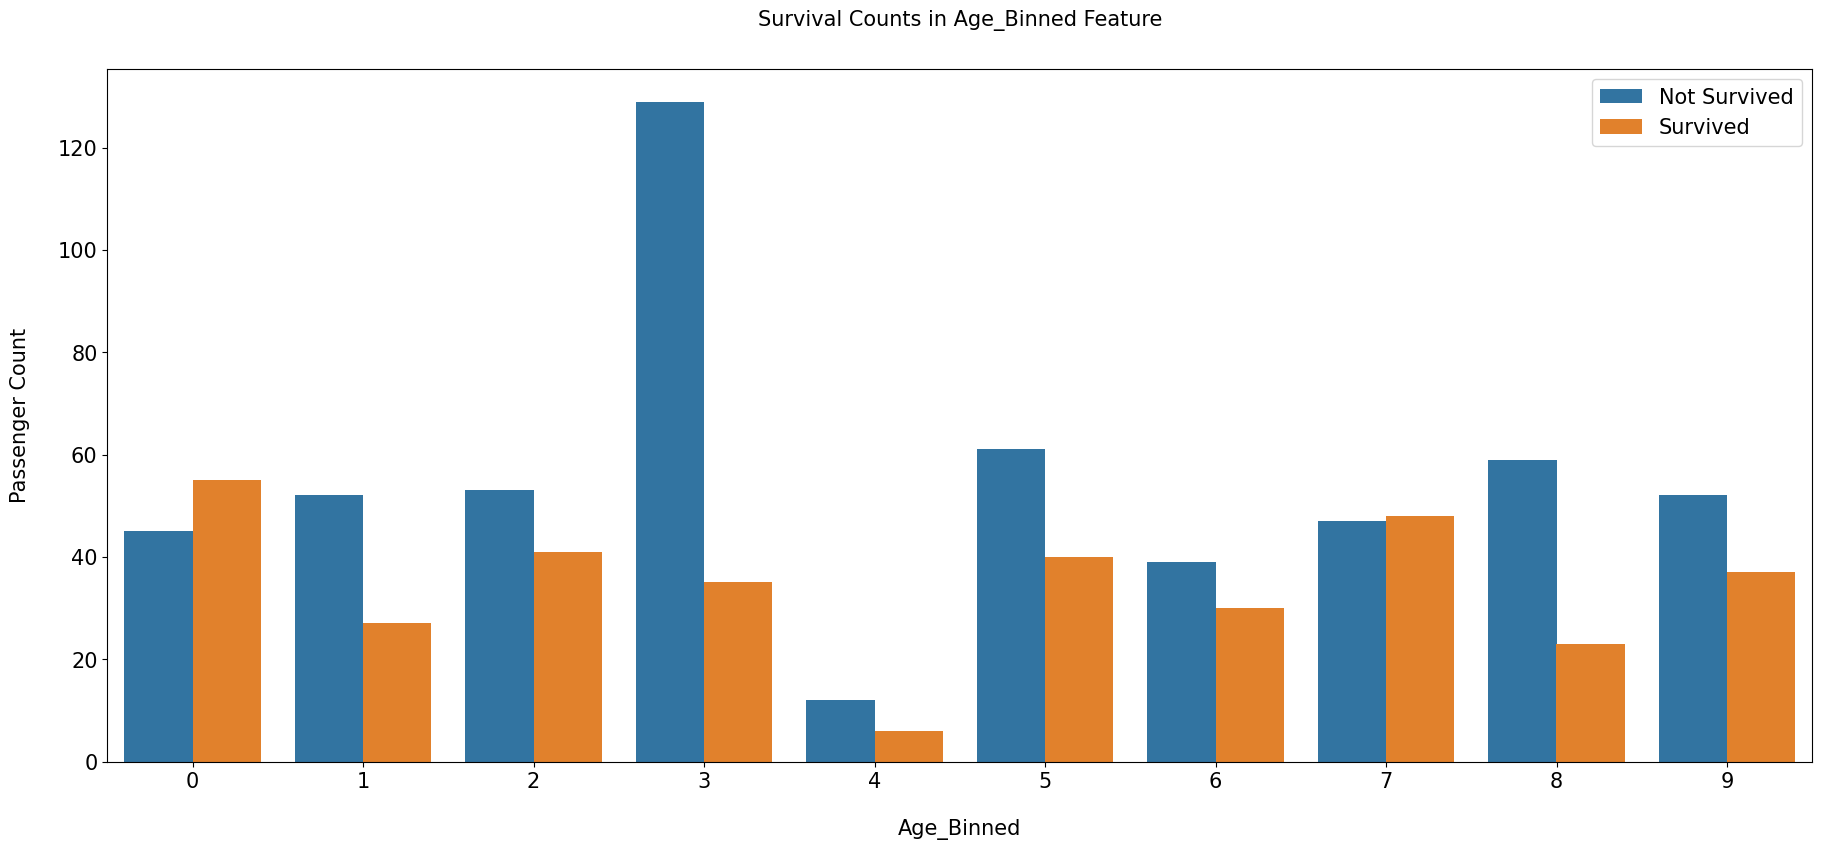

In [95]:
plot_binned_distribution_for('Age_Binned', combined_df)

### Continued Feature Engineering 

#### Add group based features
Cumulate Parch/SibSp to a family size feature. Also add a category that indicates whether the someone was travelling alone, with a small family or with a big family. Possibly the family size is an indicator since families would be priorizitized in saving, but if a bigger family cannot find all members, that would be a factor for not surviving. 

Additionally, whether someone travels in a group or not could have an impact in surviving, as groups of friends or groups of passengers travelling together might have a higher tendency to look out for each other. 

Determine groups of women with children, based on women and children first. 

In [96]:
# Create a group ID for groups to determine who actually travelled together
combined_df['Group_Id'] = combined_df['Last_Name'] + '-' + combined_df['Pclass'].astype(str) + '-' + combined_df['Ticket'].str[:-1] + 'X' + '-' + combined_df['Fare'].astype(str) + '-' + combined_df['Embarked']

# remove men & Rare Titles
combined_df.loc[combined_df['Title'] == 'Mr', 'Group_Id'] = 'noGroup'
combined_df.loc[combined_df['Title'] == 'Rare', 'Group_Id'] = 'noGroup'


In [97]:
# extract groups of women and children 
train_df, test_df = combined_df.loc[:891].copy(), combined_df.loc[892:].copy()

# count occurences of Group Id without men 
train_group_freq = train_df.groupby('Group_Id')['Group_Id'].transform('count')
test_group_freq = test_df.groupby('Group_Id')['Group_Id'].transform('count')

# remove solo travellers from GroupIds
train_df.loc[train_group_freq <= 1, 'Group_Id'] = 'noGroup'
test_df.loc[test_group_freq <= 1, 'Group_Id'] = 'noGroup'

#train_df['WC_Id'] = train_df['Pclass'].astype(str) + '-' + train_df['Ticket'].str[:-1] + 'X' + '-' + train_df['Fare'].astype(str) + '-' + train_df['Embarked']
#test_df['WC_Id'] = test_df['Pclass'].astype(str) + '-' + test_df['Ticket'].str[:-1] + 'X' + '-' + test_df['Fare'].astype(str) + '-' + test_df['Embarked']

#combined_df[combined_df['WC_Id'].isin(combined_df['WC_Id'].value_counts()[combined_df['WC_Id'].value_counts() > 1].index)]

In [98]:
train_df['WC'] = np.where(train_df['Group_Id'] != 'noGroup', 'WCGroup', 'notWCGroup')
test_df['WC'] = np.where(test_df['Group_Id'] != 'noGroup', 'WCGroup', 'notWCGroup')

combined_df = combine_dfs(train_df, test_df) 
#add_nannies_and_relatives(combined_df)


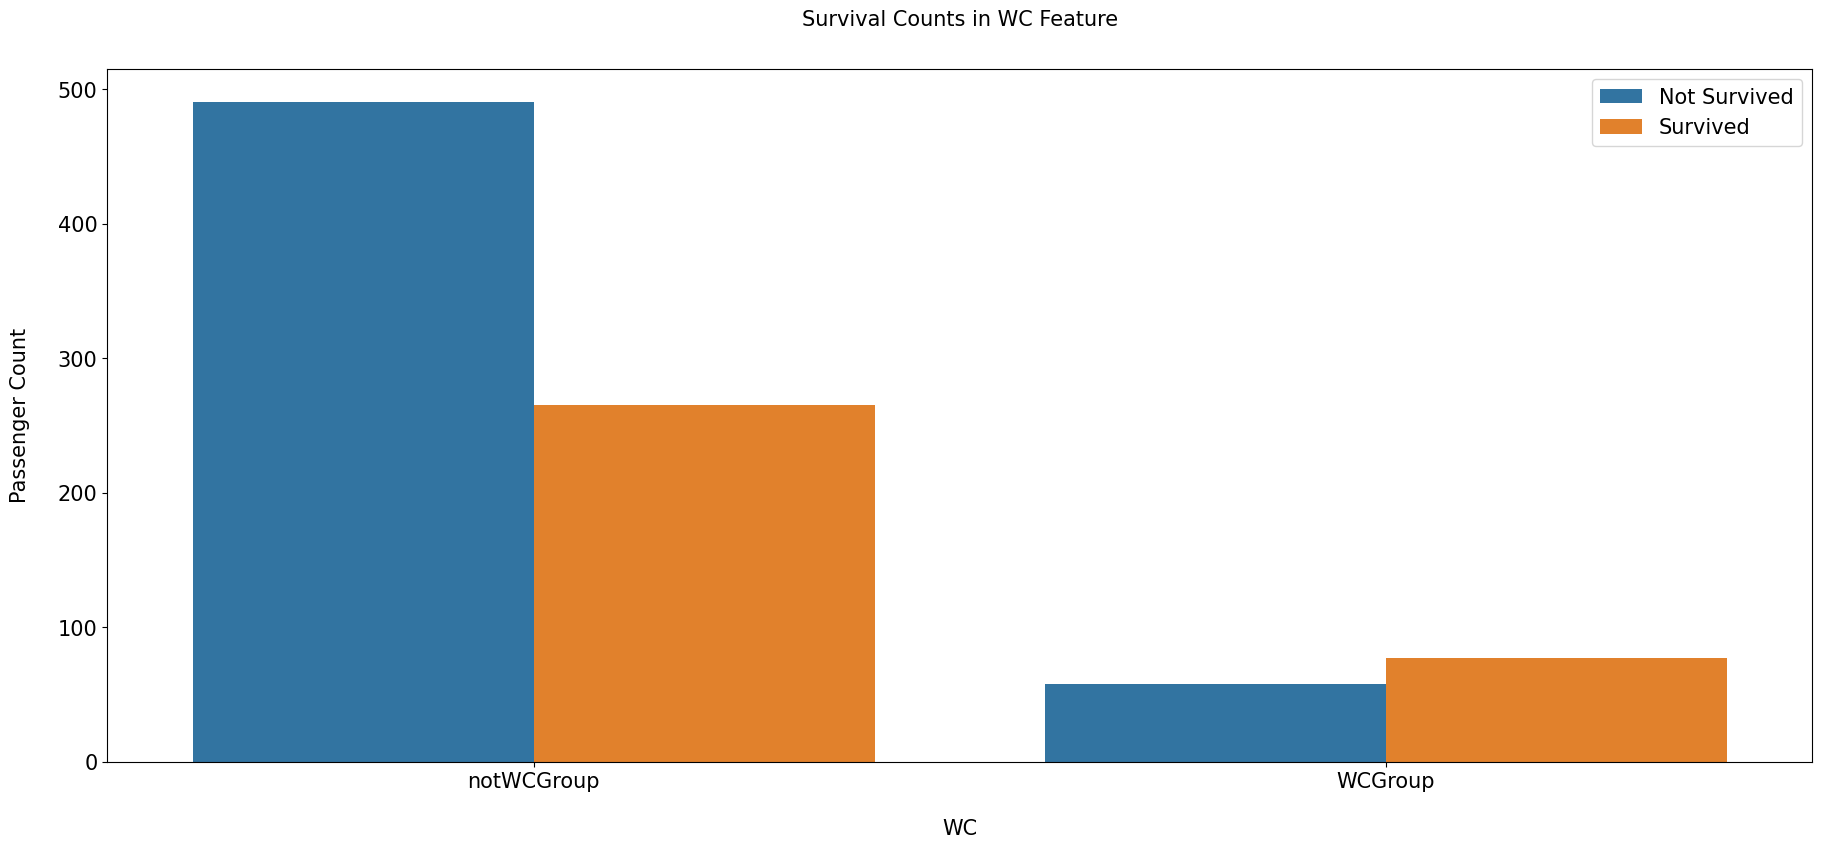

In [99]:
plot_binned_distribution_for('WC', combined_df)

##### Family based

In [100]:
combined_df['Family_Size'] = combined_df['SibSp'] + combined_df['Parch'] + 1

bins=[0, 1, float('inf')]
labels=['Alone', 'Group']

combined_df['Family_Category'] = pd.cut(
    combined_df['Family_Size'],
    bins=bins, #4,  7, , 1 = Alone, > 1 <=4 Small, > 4 medium, > 7 big
    labels=labels#, 'Big']#, 'Medium']#, 'Big'] # to much classes introduce unnecessary noise
)

In [101]:
combined_df["Family_Category"].value_counts()

Family_Category
Alone    790
Group    519
Name: count, dtype: int64

In [102]:
combined_df.columns

Index(['Adjusted_StairProximity', 'Adjusted_StairProximity_Missing', 'Age',
       'Age_Binned', 'Age_Group', 'Cabin', 'Cabin_Letters_all',
       'Cabin_numeric_all', 'Deck_Category', 'Deck_Known', 'Deck_Level',
       'Deck_Level_num', 'Embarked', 'Fare', 'First_Name', 'Group_Id',
       'Is_Married', 'Last_Name', 'Name', 'Parch', 'Parsed_Cabins', 'Pclass',
       'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'WC', 'Family_Size',
       'Family_Category'],
      dtype='object')

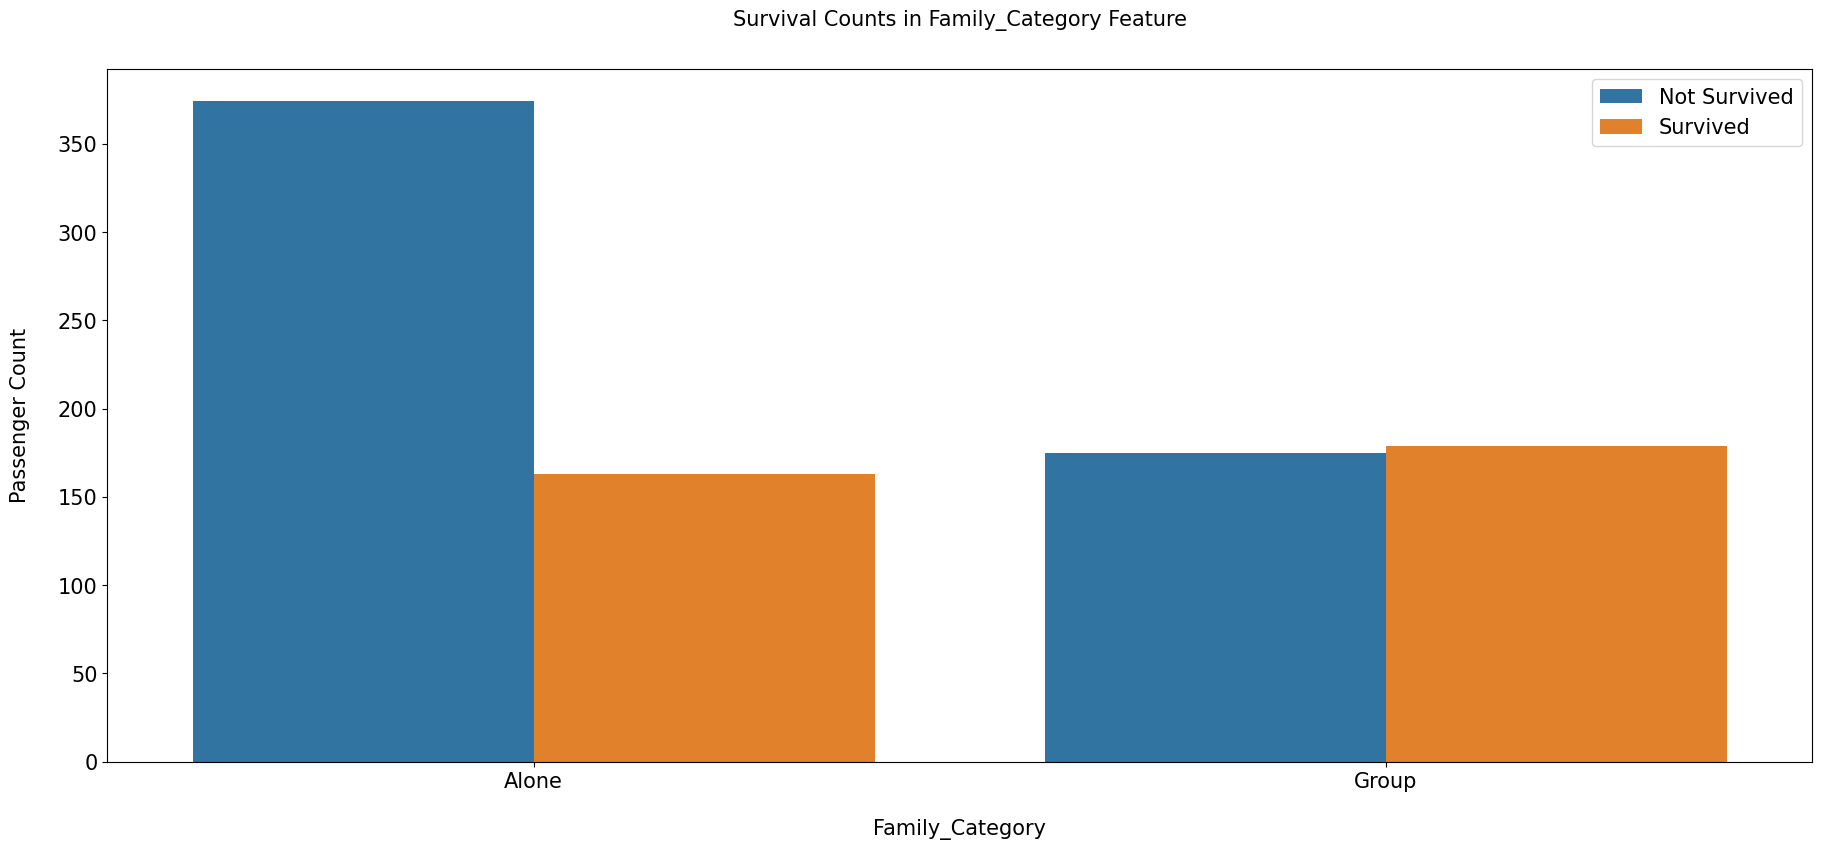

In [103]:
plot_binned_distribution_for('Family_Category', combined_df)

##### Groups based on tickets


In [104]:
train_df, test_df = combined_df.loc[:891].copy(), combined_df.loc[892:].copy()

train_df['Ticket_Count'] = train_df.groupby('Ticket')['Ticket'].transform('count')
test_df['Ticket_Count'] = test_df.groupby('Ticket')['Ticket'].transform('count')

combined_df = combine_dfs(train_df, test_df)

In [105]:
# its okay to do this on the combined set, since the ticket count was determined on split sets
combined_df['Group_Category'] = pd.cut(
    #combined_df['Group_Freq'],
    combined_df['Ticket_Count'],
    bins=bins,#  7, 1 = Alone, > 1 <=4 Small, > 4 medium, > 7 big
    labels=labels# 'Big']#, 'Medium']#, # same classes as in family category
)
combined_df['Group_Category'].value_counts()

Group_Category
Alone    868
Group    441
Name: count, dtype: int64

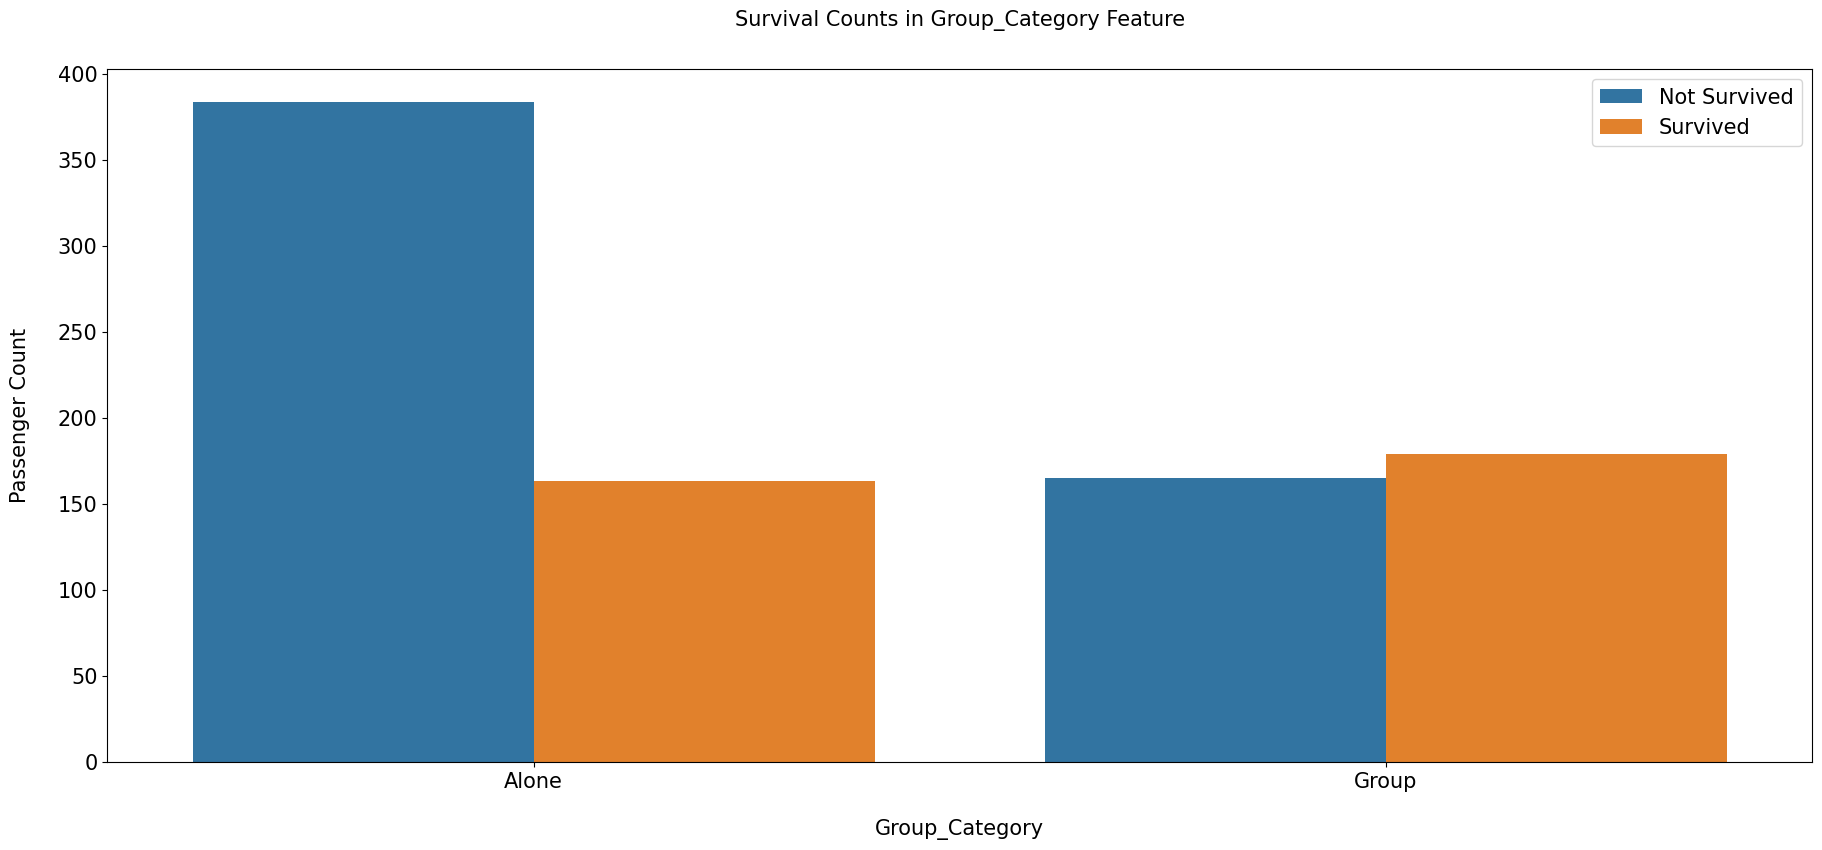

In [106]:
plot_binned_distribution_for('Group_Category', combined_df)

The results support the suspicion - travellers in a group whether family or other had a higher chance of surviving. Though this changes again for bigger groups. 

In [107]:
combined_df.columns

Index(['Adjusted_StairProximity', 'Adjusted_StairProximity_Missing', 'Age',
       'Age_Binned', 'Age_Group', 'Cabin', 'Cabin_Letters_all',
       'Cabin_numeric_all', 'Deck_Category', 'Deck_Known', 'Deck_Level',
       'Deck_Level_num', 'Embarked', 'Family_Category', 'Family_Size', 'Fare',
       'First_Name', 'Group_Id', 'Is_Married', 'Last_Name', 'Name', 'Parch',
       'Parsed_Cabins', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket',
       'Ticket_Count', 'Title', 'WC', 'Group_Category'],
      dtype='object')

In [108]:
combined_df["Group_Category"].value_counts()

Group_Category
Alone    868
Group    441
Name: count, dtype: int64

##### Merge family and group based
Create a combined feature, since both essentially cover the same logic - whether someone is travelling alone or in a group. 

In [109]:
def merge_columns(row):
    if row['Group_Category'] == row['Family_Category']:
        return row['Group_Category']  # If they are the same, take the first column
    elif row['Group_Category'] == 'Alone' and row['Family_Category'] != 'Alone':
        return row['Family_Category']  
    elif row['Family_Category'] == 'Alone' and row['Group_Category'] != 'Alone':
        return row['Group_Category'] 
    else:
        return row['Group_Category'] 

combined_df['Combined_Group_Fam'] = combined_df.apply(merge_columns, axis=1)

In [110]:
combined_df["Combined_Group_Fam"].value_counts()

Combined_Group_Fam
Alone    694
Group    615
Name: count, dtype: int64

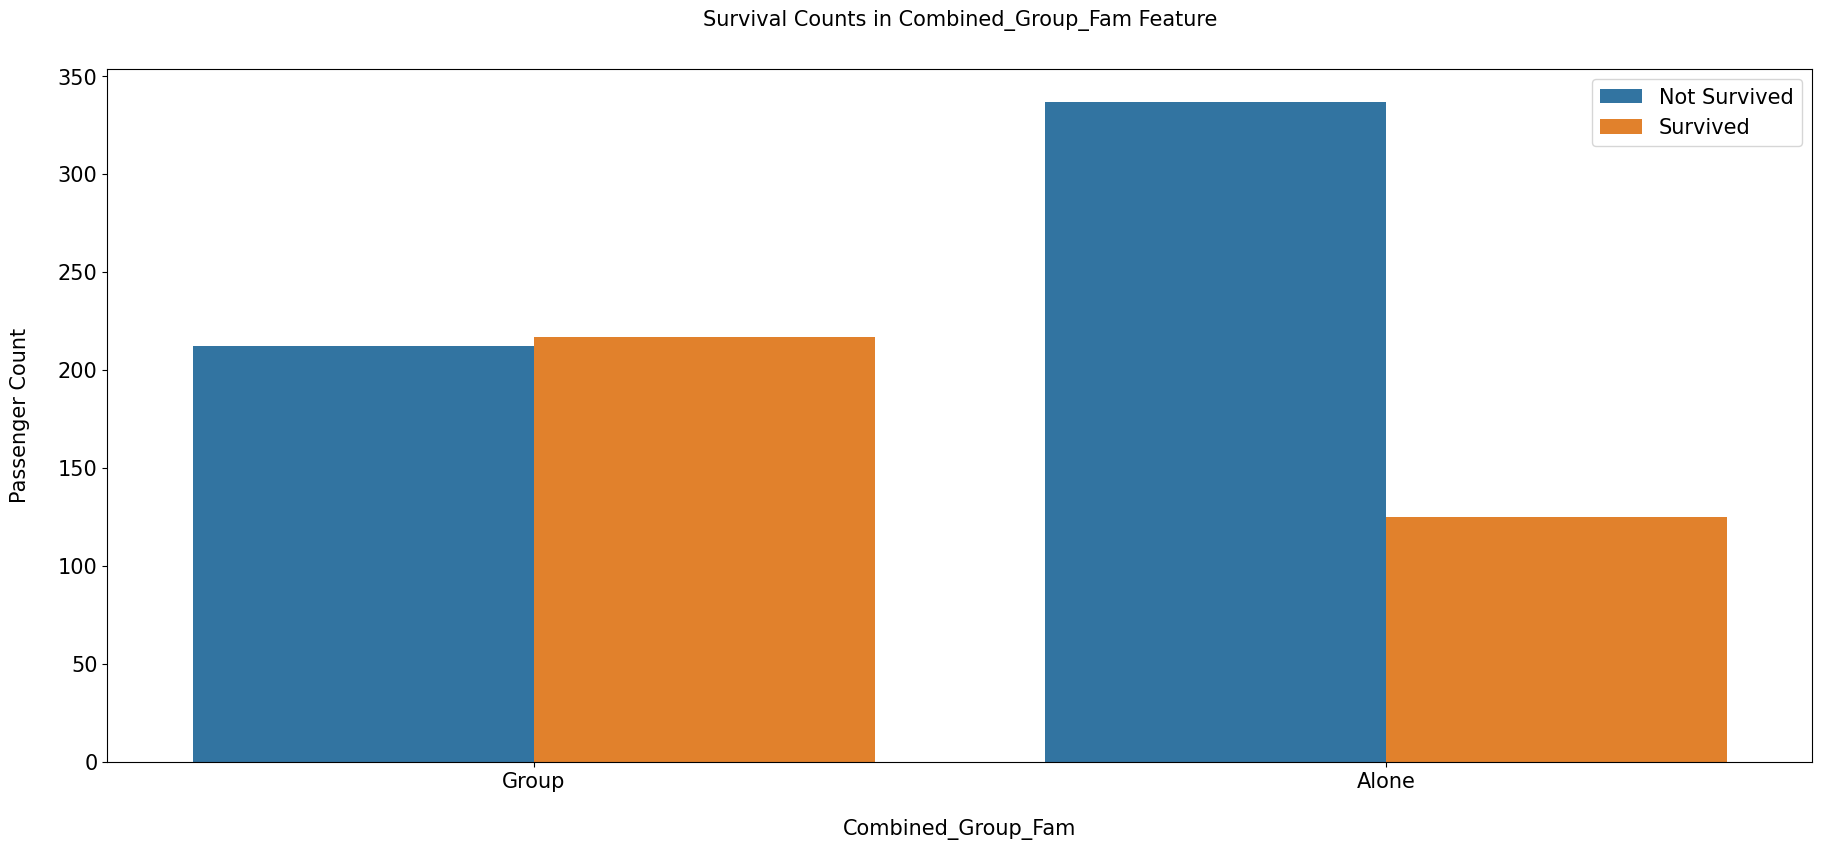

In [111]:
plot_binned_distribution_for('Combined_Group_Fam', combined_df)

In [112]:
combined_df.columns

Index(['Adjusted_StairProximity', 'Adjusted_StairProximity_Missing', 'Age',
       'Age_Binned', 'Age_Group', 'Cabin', 'Cabin_Letters_all',
       'Cabin_numeric_all', 'Deck_Category', 'Deck_Known', 'Deck_Level',
       'Deck_Level_num', 'Embarked', 'Family_Category', 'Family_Size', 'Fare',
       'First_Name', 'Group_Id', 'Is_Married', 'Last_Name', 'Name', 'Parch',
       'Parsed_Cabins', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket',
       'Ticket_Count', 'Title', 'WC', 'Group_Category', 'Combined_Group_Fam'],
      dtype='object')

Group/Family Size might be interesting further on. 

In [113]:
def merge_columns_size(row):
    if row['Ticket_Count'] == row['Family_Size']:
        return row['Ticket_Count']  # If they are the same, take the first column
    elif row['Ticket_Count'] == 1 and row['Family_Size'] != 1:
        return row['Family_Size']  
    elif row['Family_Size'] == 1 and row['Ticket_Count'] != 1:
        return row['Ticket_Count'] 
    else:
        return row['Ticket_Count'] 

combined_df['FG_Size'] = combined_df.apply(merge_columns_size, axis=1)

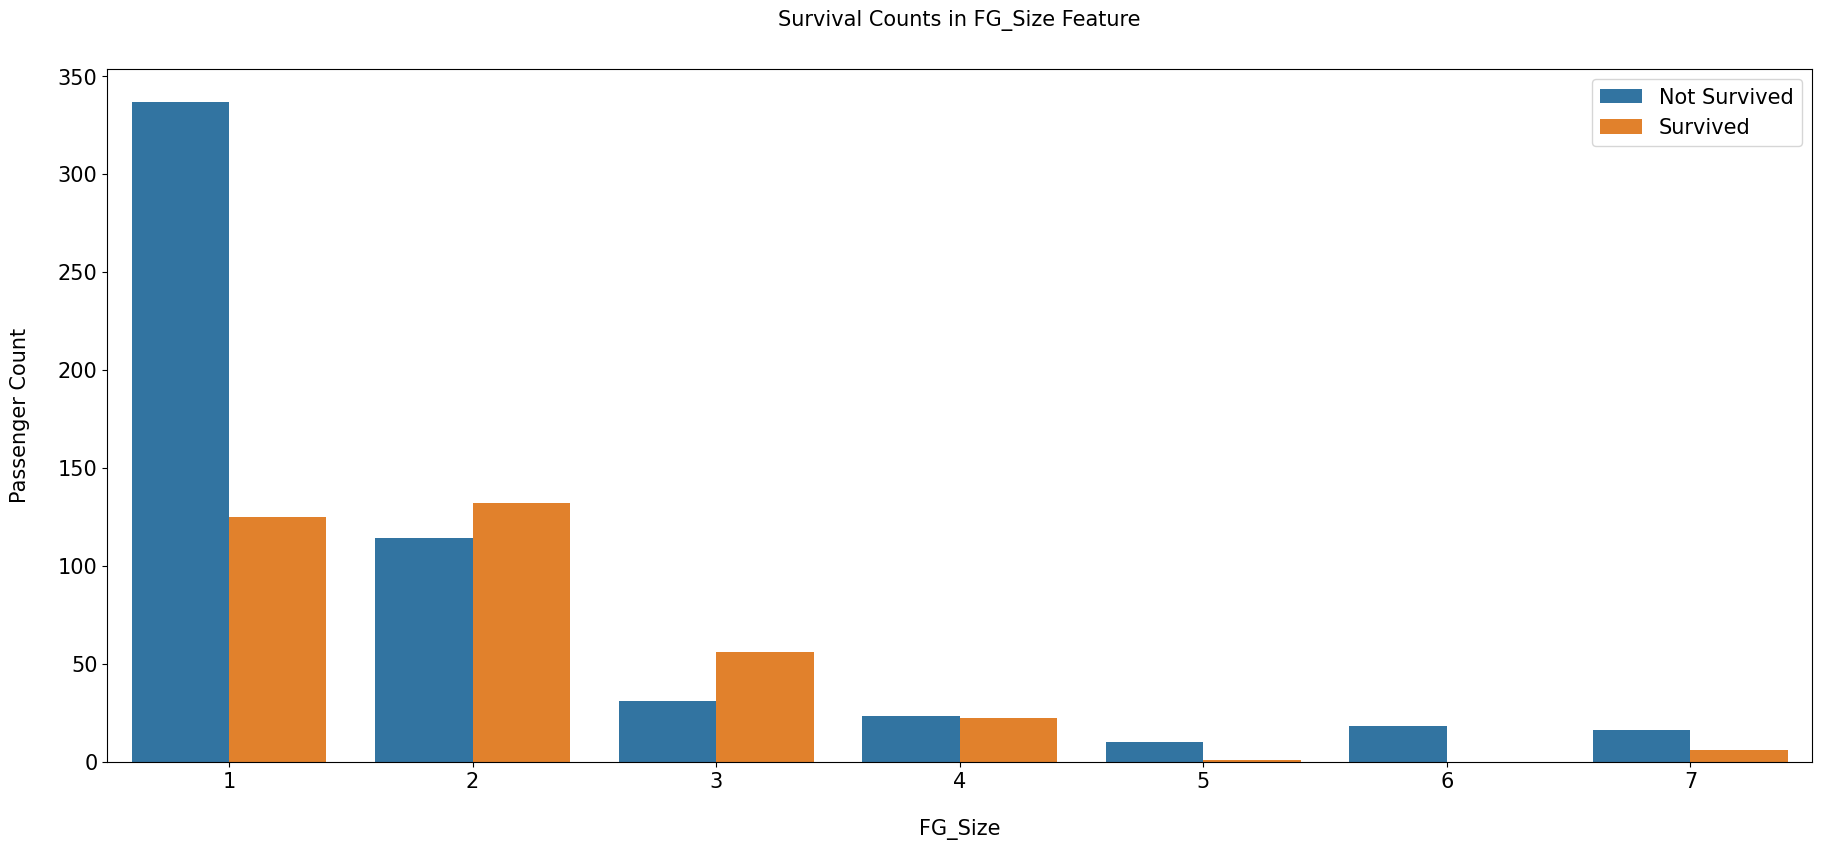

In [114]:
plot_binned_distribution_for('FG_Size', combined_df)

In [115]:
combined_df.columns

Index(['Adjusted_StairProximity', 'Adjusted_StairProximity_Missing', 'Age',
       'Age_Binned', 'Age_Group', 'Cabin', 'Cabin_Letters_all',
       'Cabin_numeric_all', 'Deck_Category', 'Deck_Known', 'Deck_Level',
       'Deck_Level_num', 'Embarked', 'Family_Category', 'Family_Size', 'Fare',
       'First_Name', 'Group_Id', 'Is_Married', 'Last_Name', 'Name', 'Parch',
       'Parsed_Cabins', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket',
       'Ticket_Count', 'Title', 'WC', 'Group_Category', 'Combined_Group_Fam',
       'FG_Size'],
      dtype='object')

##### Create Family and Group Size Class Interaction Features 

In [116]:
combined_df['Family_Size_Class']=combined_df['Family_Size']*combined_df['Pclass']
combined_df['Group_Size_Class']=combined_df['Ticket_Count']*combined_df['Pclass']

##### Create Solo Traveller flag

In [117]:
combined_df['Alone'] = 0
combined_df['Alone'] = (combined_df['FG_Size'] == 1).astype(int)

In [118]:
combined_df.columns

Index(['Adjusted_StairProximity', 'Adjusted_StairProximity_Missing', 'Age',
       'Age_Binned', 'Age_Group', 'Cabin', 'Cabin_Letters_all',
       'Cabin_numeric_all', 'Deck_Category', 'Deck_Known', 'Deck_Level',
       'Deck_Level_num', 'Embarked', 'Family_Category', 'Family_Size', 'Fare',
       'First_Name', 'Group_Id', 'Is_Married', 'Last_Name', 'Name', 'Parch',
       'Parsed_Cabins', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket',
       'Ticket_Count', 'Title', 'WC', 'Group_Category', 'Combined_Group_Fam',
       'FG_Size', 'Family_Size_Class', 'Group_Size_Class', 'Alone'],
      dtype='object')

#### Ticket based features

In [119]:
train_df, test_df = combined_df.loc[:891].copy(), combined_df.loc[892:].copy()

train_df['Ticket_prefix'] = train_df['Ticket'][train_df['Ticket'].str.contains(' ')].str.split(" ",expand=True)[0].str.replace('.', '').str.replace('/', '').str.lower()
test_df['Ticket_prefix'] = test_df['Ticket'][test_df['Ticket'].str.contains(' ')].str.split(" ",expand=True)[0].str.replace('.', '').str.replace('/', '').str.lower()

print(train_df.groupby(['Ticket_prefix', 'Pclass'])['Survived'].value_counts())
print(test_df.groupby(['Ticket_prefix', 'Pclass'])['Survived'].value_counts())

# Count occurrences of each Ticket_prefix
train_prefix_counts = train_df.groupby('Ticket_prefix').size()
test_prefix_counts = test_df.groupby('Ticket_prefix').size()

# Identify prefixes with occurrences less than 10
low_count_prefixes_train = train_prefix_counts[train_prefix_counts < 10].index
low_count_prefixes_test = test_prefix_counts[test_prefix_counts < 10].index


# Replace low-count Ticket_prefixes with 'other'
train_df['Ticket_prefix'] = train_df['Ticket_prefix'].apply(
    lambda x: 'other' if x in low_count_prefixes_train else x
)

test_df['Ticket_prefix'] = test_df['Ticket_prefix'].apply(
    lambda x: 'other' if x in low_count_prefixes_test else x
)

print(train_df.groupby(['Ticket_prefix', 'Pclass'])['Survived'].value_counts())


Ticket_prefix  Pclass  Survived
a4             3       0.0          7
a5             3       0.0         19
                       1.0          2
as             3       0.0          1
c              3       0.0          3
                       1.0          2
ca             2       0.0         10
                       1.0          9
               3       0.0         17
                       1.0          5
casoton        2       0.0          1
fa             3       0.0          1
fc             1       0.0          1
fcc            2       1.0          4
                       0.0          1
pc             1       1.0         39
                       0.0         21
pp             3       1.0          2
                       0.0          1
ppp            2       0.0          1
                       1.0          1
sc             2       1.0          1
sca4           3       0.0          1
scah           2       1.0          2
                       0.0          1
scow           2  

In [120]:
combined_df = combine_dfs(train_df, test_df)
combined_df.columns

Index(['Adjusted_StairProximity', 'Adjusted_StairProximity_Missing', 'Age',
       'Age_Binned', 'Age_Group', 'Alone', 'Cabin', 'Cabin_Letters_all',
       'Cabin_numeric_all', 'Combined_Group_Fam', 'Deck_Category',
       'Deck_Known', 'Deck_Level', 'Deck_Level_num', 'Embarked', 'FG_Size',
       'Family_Category', 'Family_Size', 'Family_Size_Class', 'Fare',
       'First_Name', 'Group_Category', 'Group_Id', 'Group_Size_Class',
       'Is_Married', 'Last_Name', 'Name', 'Parch', 'Parsed_Cabins', 'Pclass',
       'Sex', 'SibSp', 'Survived', 'Ticket', 'Ticket_Count', 'Ticket_prefix',
       'Title', 'WC'],
      dtype='object')

In [121]:
combined_df.groupby(['Ticket_prefix', 'Pclass'])['Survived'].value_counts()

Ticket_prefix  Pclass  Survived
a5             3       0.0         19
                       1.0          2
ca             2       0.0         10
                       1.0          9
               3       0.0         17
                       1.0          5
other          1       0.0          3
                       1.0          1
               2       0.0         13
                       1.0         11
               3       0.0         21
                       1.0          7
pc             1       1.0         39
                       0.0         21
scparis        2       0.0          6
                       1.0          5
sotonoq        3       0.0         13
                       1.0          2
stono          3       0.0          7
                       1.0          5
wc             2       0.0          2
                       1.0          1
               3       0.0          7
Name: count, dtype: int64

In [122]:
combined_df['Ticket_prefix'].isnull().sum()

961

In [123]:
combined_df[combined_df['Ticket_prefix'].isna()].groupby('Pclass').size()

Pclass
1    224
2    184
3    553
dtype: int64

In [124]:
combined_df[combined_df['Ticket'] == 'LINE']

,Adjusted_StairProximity,Adjusted_StairProximity_Missing,Age,Age_Binned,Age_Group,Alone,Cabin,Cabin_Letters_all,Cabin_numeric_all,Combined_Group_Fam,...,Parsed_Cabins,Pclass,Sex,SibSp,Survived,Ticket,Ticket_Count,Ticket_prefix,Title,WC
180,0.0,1,36.0,7,1,0,NaN,NaN,NaN,Group,...,"[(Unknown, 0)]",3,1,0,0.0,LINE,4,NaN,Mr,notWCGroup
272,0.0,1,25.0,3,1,0,NaN,NaN,NaN,Group,...,"[(Unknown, 0)]",3,1,0,1.0,LINE,4,NaN,Mr,notWCGroup
303,0.0,1,19.0,1,1,0,NaN,NaN,NaN,Group,...,"[(Unknown, 0)]",3,1,0,0.0,LINE,4,NaN,Mr,notWCGroup
598,0.0,1,49.0,9,1,0,NaN,NaN,NaN,Group,...,"[(Unknown, 0)]",3,1,0,0.0,LINE,4,NaN,Mr,notWCGroup


#### Bin fares 
Fares are binned in order to create separate groups. 

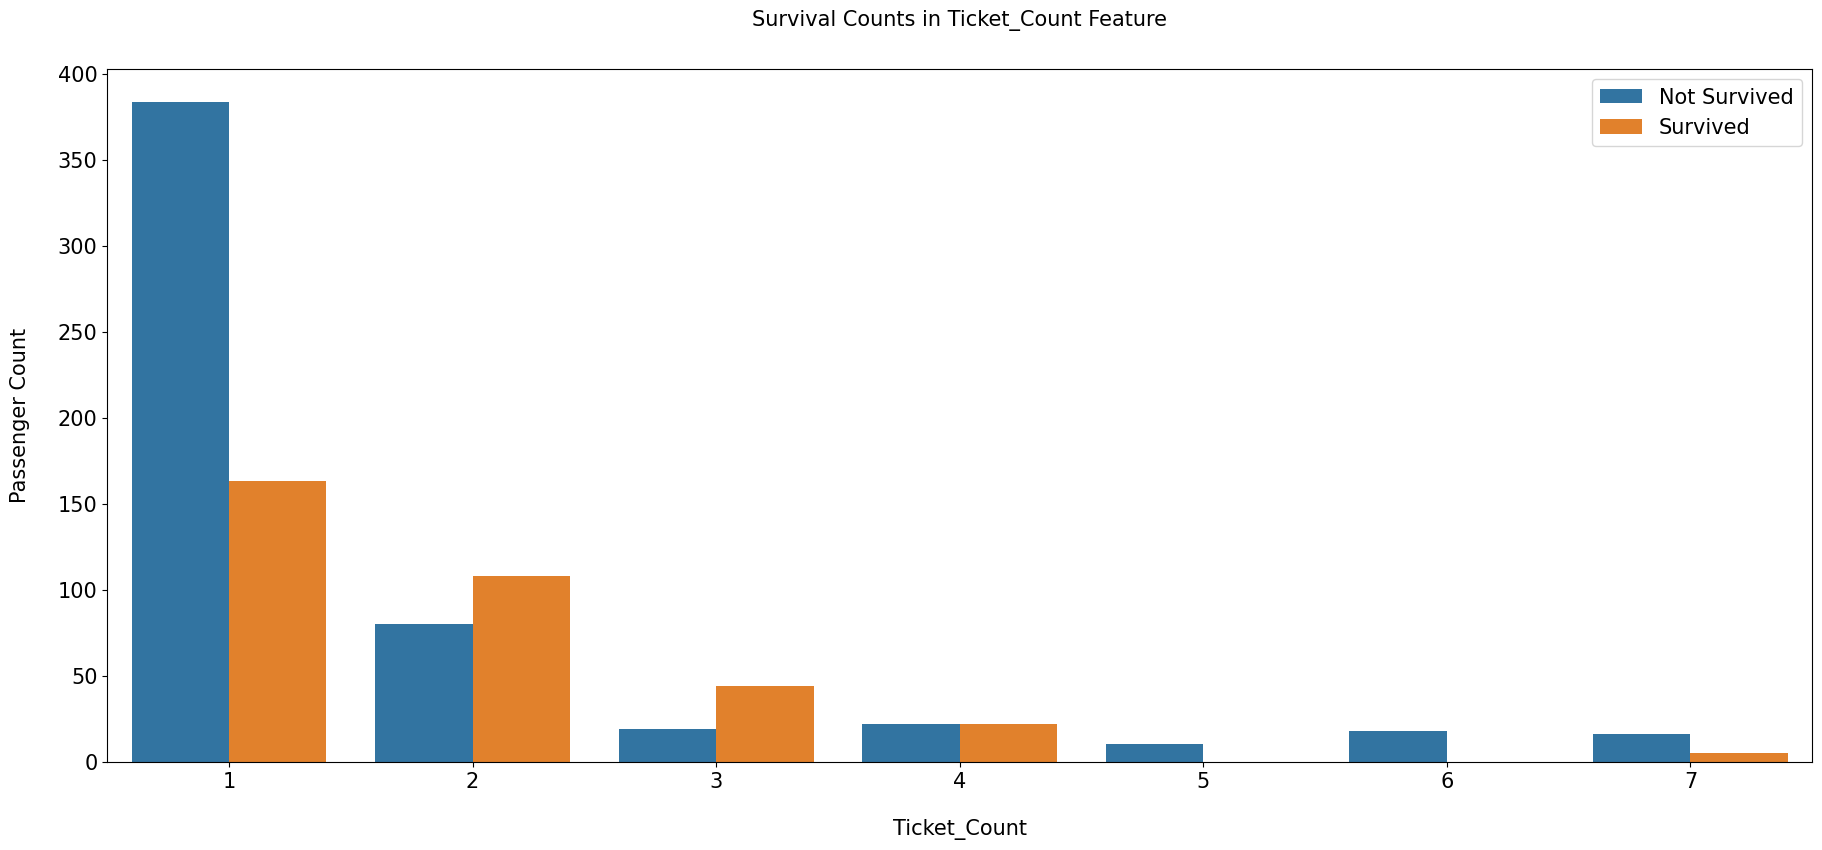

In [125]:
plot_binned_distribution_for('Ticket_Count', train_df)

In [126]:
# The value 13 resulted in the best results for the model 

# ticket count was created based on split data set
combined_df['Fare_Per_Person'] = combined_df['Fare'] / combined_df['Ticket_Count']

# split first to avoid data leakage
train_df, test_df = combined_df.loc[:891].copy(), combined_df.loc[892:].copy()


# 2303 added normalization test
# Normalize fare 
#train_df['Fare_norm'] = (train_df['Fare'] - train_df['Fare'].min()) / (train_df['Fare'].max() - train_df['Fare'].min())
#test_df['Fare_norm'] = (test_df['Fare'] - test_df['Fare'].min()) / (test_df['Fare'].max() - test_df['Fare'].min())

#train_df['Fare_Per_Person'] = train_df['Fare_norm'] / train_df['Ticket_Count']
#test_df['Fare_Per_Person'] = test_df['Fare_norm'] / test_df['Ticket_Count']



# cut on train distribution 
train_df['Fare_Binned'], bins_fare = pd.qcut(train_df['Fare_Per_Person'], 13, labels=False, duplicates='drop', retbins=True)

# use bins from train distribution to cut test
# include highest values in test_df in last bin 
bins_fare[-1] = np.inf

test_df['Fare_Binned'] = pd.cut(test_df['Fare_Per_Person'], bins=bins_fare, labels=False, include_lowest=True)
#test_df['Fare_Binned'] = pd.qcut(test_df['Fare_Per_Person'], 13, labels=False, duplicates='drop')


#print(train_df['Fare_Binned'].value_counts())
#print(bins_fare)
#print(train_df['Fare_Binned'].isna().sum())
#print(test_df['Fare_Binned'].isna().sum())

combined_df = combine_dfs(train_df, test_df)
combined_df.columns

Index(['Adjusted_StairProximity', 'Adjusted_StairProximity_Missing', 'Age',
       'Age_Binned', 'Age_Group', 'Alone', 'Cabin', 'Cabin_Letters_all',
       'Cabin_numeric_all', 'Combined_Group_Fam', 'Deck_Category',
       'Deck_Known', 'Deck_Level', 'Deck_Level_num', 'Embarked', 'FG_Size',
       'Family_Category', 'Family_Size', 'Family_Size_Class', 'Fare',
       'Fare_Binned', 'Fare_Per_Person', 'First_Name', 'Group_Category',
       'Group_Id', 'Group_Size_Class', 'Is_Married', 'Last_Name', 'Name',
       'Parch', 'Parsed_Cabins', 'Pclass', 'Sex', 'SibSp', 'Survived',
       'Ticket', 'Ticket_Count', 'Ticket_prefix', 'Title', 'WC'],
      dtype='object')

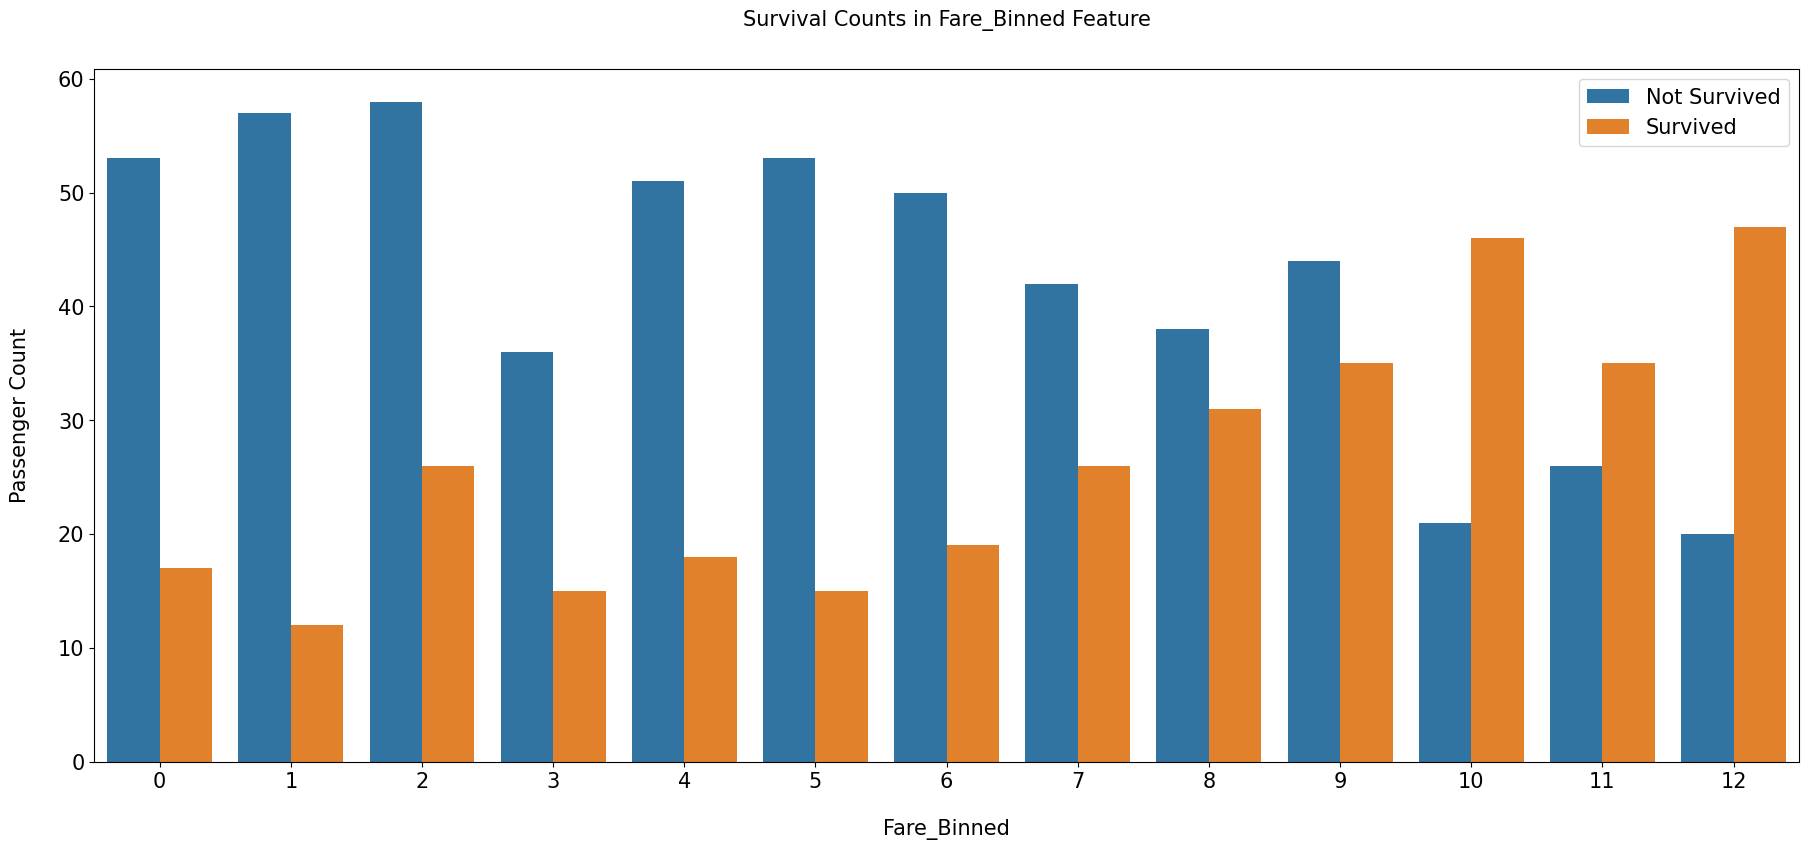

In [127]:
plot_binned_distribution_for('Fare_Binned', combined_df)

#### First family/group based imputation
Pretty straight forward, assume groups travelling together with missing deck levels have similar deck levels. 

In [128]:
def impute_deck_level_group_based(df, ticket_groups): 
    for ticket, group in ticket_groups:
        # If some members have deck info and others don't
        if (group['Deck_Level'] == 'U').any() and not (group['Deck_Level'] == 'U').all():
            # Get known deck for this ticket
            known_deck = group.loc[group['Deck_Level'] != 'U', 'Deck_Level'].iloc[0]
            # Apply to all members with this ticket
            df.loc[group[group['Deck_Level'] == "U"].index, 'Deck_Level'] = known_deck

# Group by ticket and fill missing decks with known values within the same ticket 
train_df, test_df = combined_df.loc[:891].copy(), combined_df.loc[892:].copy()

ticket_groups_train = train_df.groupby('Ticket')
ticket_groups_test= test_df.groupby('Ticket')

impute_deck_level_group_based(train_df, ticket_groups_train)
impute_deck_level_group_based(test_df, ticket_groups_test)

combined_df = combine_dfs(train_df, test_df)

combined_df["Deck_Level"].value_counts()

Deck_Level
U    1000
C     104
B      67
D      46
E      42
A      23
F      18
G       9
Name: count, dtype: int64

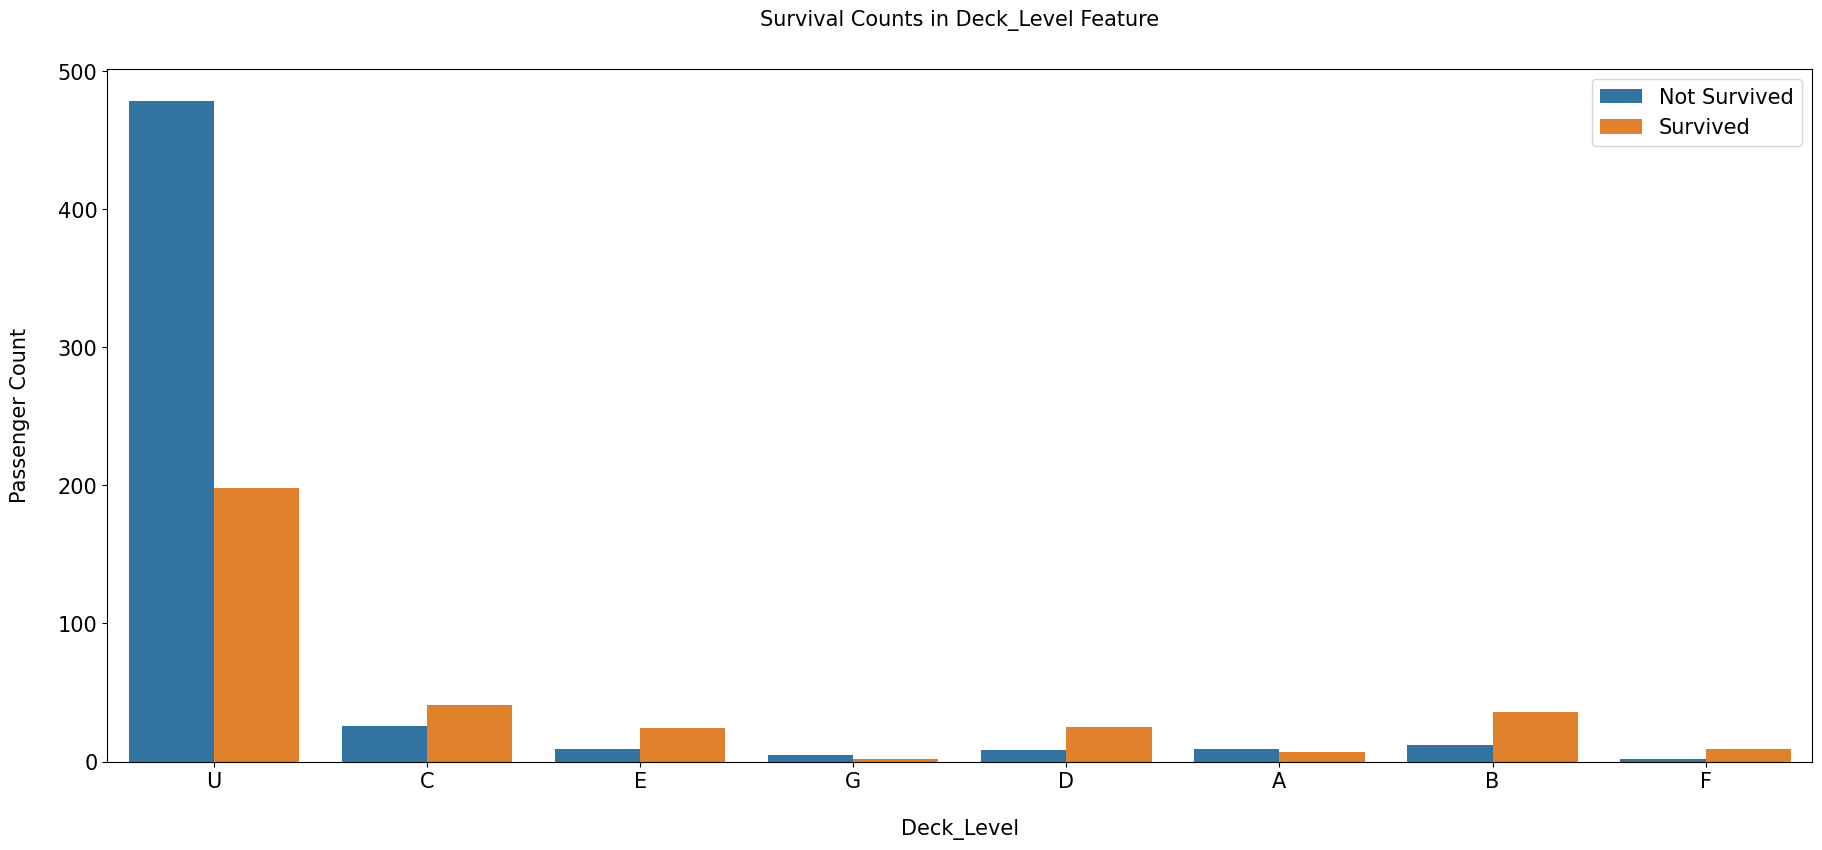

In [129]:
plot_binned_distribution_for('Deck_Level', combined_df)

In [130]:
combined_df.head(2)

,Adjusted_StairProximity,Adjusted_StairProximity_Missing,Age,Age_Binned,Age_Group,Alone,Cabin,Cabin_Letters_all,Cabin_numeric_all,Combined_Group_Fam,...,Parsed_Cabins,Pclass,Sex,SibSp,Survived,Ticket,Ticket_Count,Ticket_prefix,Title,WC
1,0.0,1,22.0,2,1,0,NaN,NaN,NaN,Group,...,"[(Unknown, 0)]",3,1,1,0.0,A/5 21171,1,a5,Mr,notWCGroup
2,6.0,0,38.0,7,1,0,C85,[C],[85],Group,...,"[(C, 85.0)]",1,0,1,1.0,PC 17599,1,pc,Miss/Mrs,notWCGroup


#### Impute deck levels

In [131]:
def deck_imputation(df):
    # Make a copy to avoid modifying the original
    data = df.copy()
    
    # 1. Proximity-based (KNN) imputation
    # Prepare data for KNN imputation
    #print(data["Deck_Level"].value_counts())
    features_for_deck = [
        # initial imputation criteria
        'Pclass', 
        #'Fare', 
        'Embarked', 
        # play around with
        'Fare_Binned',
        'Age_Group',
        'WC', 
        #'Title',
        #'Fare_Per_Person',
        #'Ticket',     
        #'Ticket_prefix',     

        #'Last_Name',
        
        #'Is_Married', don't use
        
        #'FG_Size', don't use
        
                         # 'Age_Binned' don'T use
                         ]

    # Encode categorical features
    label_encoders = {}
    for col in features_for_deck:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[f'{col}_encoded'] = le.fit_transform(data[col].fillna('missing'))
            label_encoders[col] = le
            features_for_deck[features_for_deck.index(col)] = f'{col}_encoded'
    
    # Create separate dataframe for imputation
    impute_df = data[features_for_deck].copy()
    print(impute_df.isna().sum())

    # Apply KNN imputation
    nn = NearestNeighbors(n_neighbors=5)
    nn.fit(impute_df)
    print(data['Deck_Level'].value_counts())
    
    # Store KNN imputed results
    data['Deck_KNN'] = data['Deck_Level'].copy()
    deck_missing_idx = data[data['Deck_Level'] == "U"].index
    
    # For each missing deck, assign the most common deck among its K nearest neighbors
    for i, idx in enumerate(deck_missing_idx):
        neighbors = nn.kneighbors(impute_df.loc[[idx]], return_distance=False)[0]
        neighbor_decks = data.iloc[neighbors]['Deck_Level'].dropna()
        if len(neighbor_decks) > 0:
            data.loc[idx, 'Deck_KNN'] = neighbor_decks.mode()[0]
        else:
            # If no neighbor has known deck, use global mode
            data.loc[idx, 'Deck_KNN'] = data['Deck_Level'].dropna().mode()[0]

    data['Deck_Hybrid'] = data['Deck_Level'].copy()
    
    missing = data.loc[data['Deck_Hybrid'] == "U"].index
    data.loc[missing, 'Deck_Hybrid'] = data.loc[missing, 'Deck_KNN']

    print(data['Deck_Hybrid'].value_counts())
    
    return data

train_df = deck_imputation(train_df)
test_df = deck_imputation(test_df)

combined_df = combine_dfs(train_df, test_df)

#new_df.columns

Pclass              0
Embarked_encoded    0
Fare_Binned         0
Age_Group           0
WC_encoded          0
dtype: int64
Deck_Level
U    676
C     67
B     48
E     33
D     33
A     16
F     11
G      7
Name: count, dtype: int64
Deck_Hybrid
U    648
C     82
B     51
E     36
D     34
A     22
F     11
G      7
Name: count, dtype: int64
Pclass              0
Embarked_encoded    0
Fare_Binned         0
Age_Group           0
WC_encoded          0
dtype: int64
Deck_Level
U    324
C     37
B     19
D     13
E      9
A      7
F      7
G      2
Name: count, dtype: int64
Deck_Hybrid
U    303
C     42
B     25
D     18
E     14
A      7
F      7
G      2
Name: count, dtype: int64


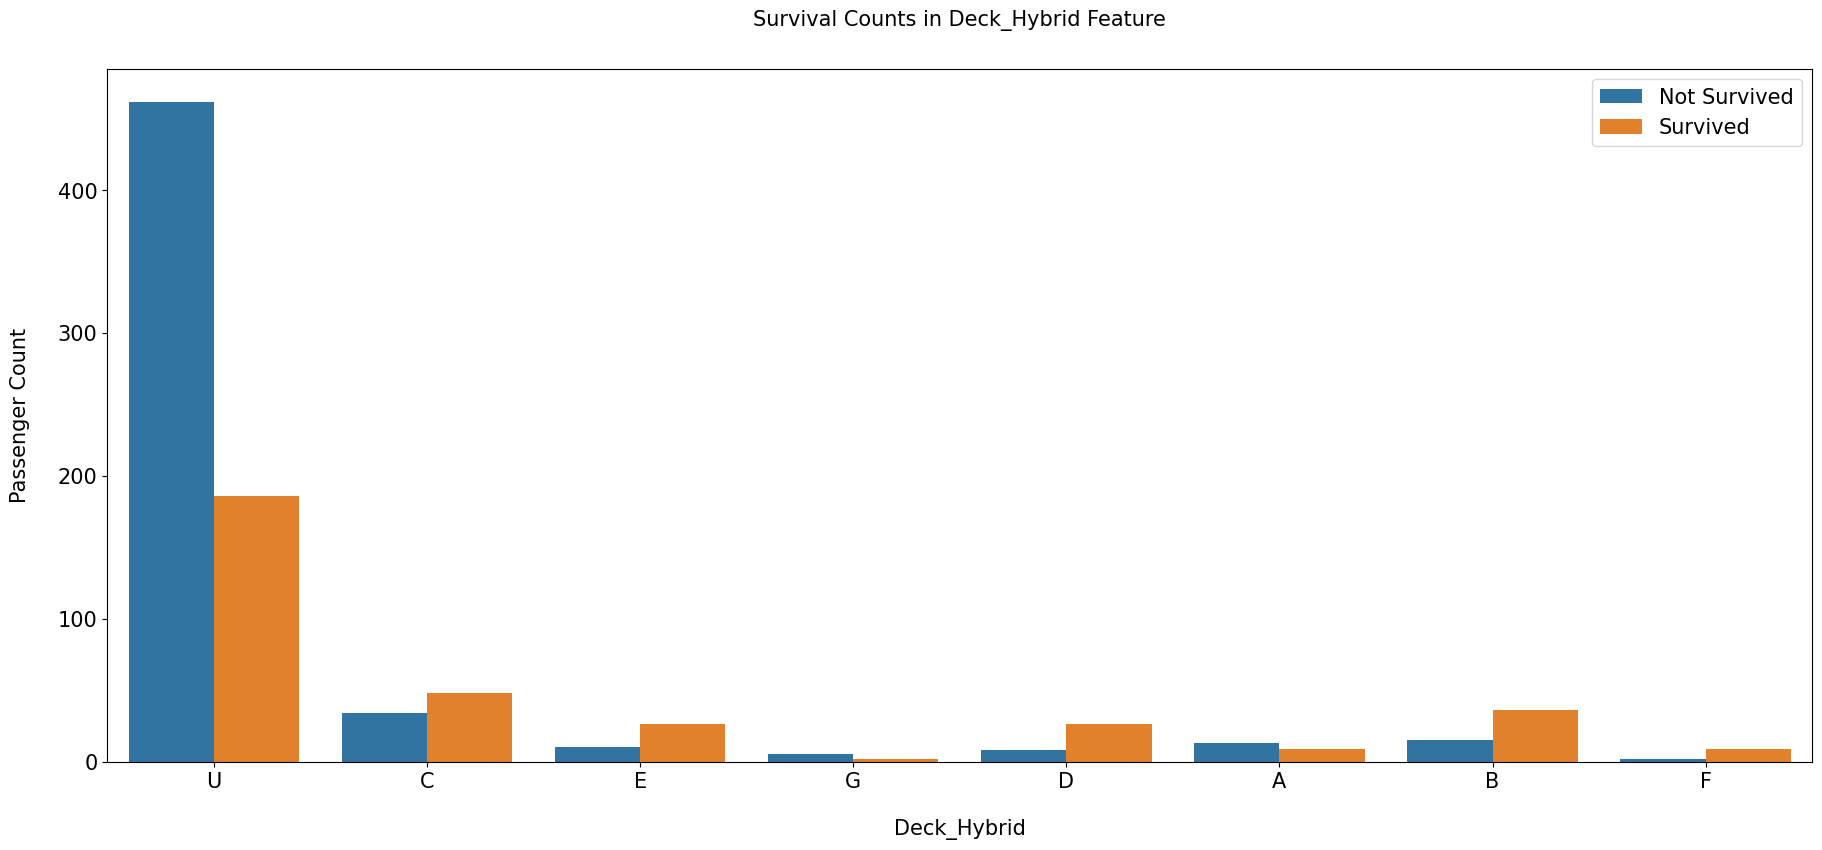

In [132]:
plot_binned_distribution_for("Deck_Hybrid", combined_df)

#### Calculate Survival Rates based on features

In [133]:
# split first to avoid leakage
train_df, test_df = combined_df.loc[:891].copy(), combined_df.loc[892:].copy()

#####  Title based

In [134]:
train_df['Title_Survival'] = train_df['Title'].map(train_df.groupby('Title')['Survived'].mean())
test_df['Title_Survival'] = test_df['Title'].map(train_df.groupby('Title')['Survived'].mean())

##### Family/Group based

In [135]:
train_df.columns

Index(['Adjusted_StairProximity', 'Adjusted_StairProximity_Missing', 'Age',
       'Age_Binned', 'Age_Group', 'Alone', 'Cabin', 'Cabin_Letters_all',
       'Cabin_numeric_all', 'Combined_Group_Fam', 'Deck_Category',
       'Deck_Hybrid', 'Deck_KNN', 'Deck_Known', 'Deck_Level', 'Deck_Level_num',
       'Embarked', 'Embarked_encoded', 'FG_Size', 'Family_Category',
       'Family_Size', 'Family_Size_Class', 'Fare', 'Fare_Binned',
       'Fare_Per_Person', 'First_Name', 'Group_Category', 'Group_Id',
       'Group_Size_Class', 'Is_Married', 'Last_Name', 'Name', 'Parch',
       'Parsed_Cabins', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket',
       'Ticket_Count', 'Ticket_prefix', 'Title', 'WC', 'WC_encoded',
       'Title_Survival'],
      dtype='object')

In [136]:
fg_survival = train_df.groupby(['Ticket', 'Ticket_Count', 'Pclass'])['Survived'].agg(['mean']).reset_index()
#print(fg_survival)
fg_survival['FG_Survival_Rate'] = fg_survival['mean']
print(fg_survival.head(2))

train_df = train_df.merge(fg_survival[['Ticket', 'Ticket_Count', 'Pclass', 'FG_Survival_Rate']], on=['Ticket', 'Ticket_Count', 'Pclass'], how='left')
print(train_df['FG_Survival_Rate'].isnull().sum())
print(train_df.head(2))

test_df = test_df.merge(fg_survival[['Ticket', 'Ticket_Count', 'Pclass', 'FG_Survival_Rate']], on=['Ticket', 'Ticket_Count', 'Pclass'], how='left')
print(test_df['FG_Survival_Rate'].isnull().sum())
test_df.head(2)


   Ticket  Ticket_Count  Pclass   mean  FG_Survival_Rate
0  110152             3       1  1.000             1.000
1  110413             3       1  0.667             0.667
0
   Adjusted_StairProximity  Adjusted_StairProximity_Missing   Age  Age_Binned  \
0                      0.0                                1  22.0           2   
1                      6.0                                0  38.0           7   

   Age_Group  Alone Cabin Cabin_Letters_all Cabin_numeric_all  \
0          1      0   NaN               NaN               NaN   
1          1      0   C85               [C]              [85]   

  Combined_Group_Fam  ... SibSp Survived     Ticket  Ticket_Count  \
0              Group  ...     1      0.0  A/5 21171             1   
1              Group  ...     1      1.0   PC 17599             1   

  Ticket_prefix     Title          WC  WC_encoded  Title_Survival  \
0            a5        Mr  notWCGroup           1           0.157   
1            pc  Miss/Mrs  notWCGroup    

,Adjusted_StairProximity,Adjusted_StairProximity_Missing,Age,Age_Binned,Age_Group,Alone,Cabin,Cabin_Letters_all,Cabin_numeric_all,Combined_Group_Fam,...,SibSp,Survived,Ticket,Ticket_Count,Ticket_prefix,Title,WC,WC_encoded,Title_Survival,FG_Survival_Rate
0,0.0,1,34.5,7,1,1,NaN,NaN,NaN,Alone,...,0,NaN,330911,1,NaN,Mr,notWCGroup,1,0.157,NaN
1,0.0,1,47.0,8,1,0,NaN,NaN,NaN,Group,...,1,NaN,363272,1,NaN,Miss/Mrs,notWCGroup,1,0.736,NaN


In [137]:
print(test_df.shape)

(418, 46)


A litte less fine granular - just giving the mean of group vs solo traveller. 

In [138]:
mean_fg = round(train_df[train_df['Ticket_Count'] > 1]['Survived'].mean(), 2)
mean_solo = round(train_df[(train_df['Ticket_Count'] == 1) & (train_df['Family_Size'] == 1)]['Survived'].mean(), 2)
print(mean_fg)
print(mean_solo)

train_df.loc[train_df['Ticket_Count'] == 1, 'ST_Survival'] = mean_solo
test_df.loc[test_df['Ticket_Count'] == 1, 'ST_Survival'] = mean_solo

train_df.loc[:, 'ST_Survival_Missing'] = train_df['ST_Survival'].isna().astype(int)
test_df.loc[:, 'ST_Survival_Missing'] = test_df['ST_Survival'].isna().astype(int)

train_df.loc[:, 'ST_Survival'] = train_df['ST_Survival'].fillna(mean_fg)
test_df.loc[:, 'ST_Survival'] = test_df['ST_Survival'].fillna(mean_fg)

0.52
0.27


##### Based on deck level

In [139]:
deck_survival_train = train_df.groupby('Deck_Level')['Survived'].mean().reset_index()
deck_survival_train.columns = ['Deck_Level', 'Deck_Survival_Rate']

train_df = train_df.merge(deck_survival_train, on='Deck_Level', how='left')
test_df = test_df.merge(deck_survival_train, on='Deck_Level', how='left')

##### Combine the data sets again

In [140]:
combined_df = combine_dfs(train_df, test_df)
combined_df.columns

Index(['Adjusted_StairProximity', 'Adjusted_StairProximity_Missing', 'Age',
       'Age_Binned', 'Age_Group', 'Alone', 'Cabin', 'Cabin_Letters_all',
       'Cabin_numeric_all', 'Combined_Group_Fam', 'Deck_Category',
       'Deck_Hybrid', 'Deck_KNN', 'Deck_Known', 'Deck_Level', 'Deck_Level_num',
       'Deck_Survival_Rate', 'Embarked', 'Embarked_encoded', 'FG_Size',
       'FG_Survival_Rate', 'Family_Category', 'Family_Size',
       'Family_Size_Class', 'Fare', 'Fare_Binned', 'Fare_Per_Person',
       'First_Name', 'Group_Category', 'Group_Id', 'Group_Size_Class',
       'Is_Married', 'Last_Name', 'Name', 'Parch', 'Parsed_Cabins', 'Pclass',
       'ST_Survival', 'ST_Survival_Missing', 'Sex', 'SibSp', 'Survived',
       'Ticket', 'Ticket_Count', 'Ticket_prefix', 'Title', 'Title_Survival',
       'WC', 'WC_encoded'],
      dtype='object')

### Apply Encoding

In [141]:
combined_df.columns

Index(['Adjusted_StairProximity', 'Adjusted_StairProximity_Missing', 'Age',
       'Age_Binned', 'Age_Group', 'Alone', 'Cabin', 'Cabin_Letters_all',
       'Cabin_numeric_all', 'Combined_Group_Fam', 'Deck_Category',
       'Deck_Hybrid', 'Deck_KNN', 'Deck_Known', 'Deck_Level', 'Deck_Level_num',
       'Deck_Survival_Rate', 'Embarked', 'Embarked_encoded', 'FG_Size',
       'FG_Survival_Rate', 'Family_Category', 'Family_Size',
       'Family_Size_Class', 'Fare', 'Fare_Binned', 'Fare_Per_Person',
       'First_Name', 'Group_Category', 'Group_Id', 'Group_Size_Class',
       'Is_Married', 'Last_Name', 'Name', 'Parch', 'Parsed_Cabins', 'Pclass',
       'ST_Survival', 'ST_Survival_Missing', 'Sex', 'SibSp', 'Survived',
       'Ticket', 'Ticket_Count', 'Ticket_prefix', 'Title', 'Title_Survival',
       'WC', 'WC_encoded'],
      dtype='object')

####  Encoding

In [142]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, target_col, smoothing=1.0):
        self.cols = cols  # Columns to target encode
        self.target_col = target_col  # Target column
        self.smoothing = smoothing  # Smoothing parameter to prevent overfitting
        self.encodings = {}  # Store the encodings for each column

    def fit(self, X, y=train_df['Survived']):
        if y is None:
            raise ValueError("TargetEncoder requires y to be passed during fit.")
        
        X = X.copy()
        X[self.target_col] = y  # Add the target column to the DataFrame

        for col in self.cols:
            # Calculate the mean target value for each category
            means = X.groupby(col)[self.target_col].mean()
            # Calculate the global mean
            global_mean = X[self.target_col].mean()
            # Apply smoothing
            self.encodings[col] = (means * len(means) + global_mean * self.smoothing) / (len(means) + self.smoothing)

        self.feature_names_out_ = [f"target_encode__{col}" for col in self.cols]
            
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.cols:
            # Replace categories with their encoded values
            X[col] = X[col].map(self.encodings[col]).fillna(X[col].mean())
        return X

    def get_feature_names_out(self, input_features=None):
        """Get output feature names for transformation."""
        if self.feature_names_out_ is None:
            raise ValueError("TargetEncoder has not been fitted yet.")
        return self.feature_names_out_

In [143]:
from sklearn.compose import ColumnTransformer


'''cat__Pclass_1' 'cat__Pclass_2' 'cat__Pclass_3' 
'cat__Title_Master'\n 'cat__Title_Miss/Mrs' 'cat__Title_Mr' 'cat__Title_Rare'
\n 'cat__Deck_Level_A' 'cat__Deck_Level_B' 'cat__Deck_Level_C'
\n 'cat__Deck_Level_D' 'cat__Deck_Level_E' 'cat__Deck_Level_F'\n 
'cat__Deck_Level_G' 'cat__Deck_Level_U'
'cat__Family_Size_Class_1'\n 'cat__Family_Size_Class_2' 
'cat__Family_Size_Class_3'\n 'cat__Family_Size_Class_4' 
'cat__Family_Size_Class_5'\n 'cat__Family_Size_Class_6' 
'cat__Family_Size_Class_8'\n 'cat__Family_Size_Class_9' 
'cat__Family_Size_Class_10'\n 'cat__Family_Size_Class_12'
'cat__Family_Size_Class_15'\n 'cat__Family_Size_Class_18' 
'cat__Family_Size_Class_21'\n 'cat__Family_Size_Class_24' 
'cat__Family_Size_Class_33'\n 
'targ__target_encode__Age_Binned1'\n
'targ__target_encode__Combined_Group_Fam'''





"""['cat__Is_Married_0' 'cat__Is_Married_1' 
 'cat__Pclass_1' 'cat__Pclass_2'\n 'cat__Pclass_3' 
 'cat__Deck_Hybrid_A' 'cat__Deck_Hybrid_B'\n 'cat__Deck_Hybrid_C' 
 'cat__Deck_Hybrid_D' 'cat__Deck_Hybrid_E'\n 'cat__Deck_Hybrid_F' 
 'cat__Deck_Hybrid_G' 'cat__Deck_Hybrid_U'\n 
 'cat__Family_Size_Class_1' 'cat__Family_Size_Class_2'\n 'cat__Family_Size_Class_3' 
 'cat__Family_Size_Class_4'\n 'cat__Family_Size_Class_5' 'cat__Family_Size_Class_6'\n 
 'cat__Family_Size_Class_8' 'cat__Family_Size_Class_9'\n 'cat__Family_Size_Class_10' 
 'cat__Family_Size_Class_12'\n 'cat__Family_Size_Class_15' 'cat__Family_Size_Class_18'\n 
 'cat__Family_Size_Class_21' 'cat__Family_Size_Class_24'\n 'cat__Family_Size_Class_33' 
 'cat__Group_Size_Class_1'\n 'cat__Group_Size_Class_2' 'cat__Group_Size_Class_3'\n 
 'cat__Group_Size_Class_4' 'cat__Group_Size_Class_6'\n 'cat__Group_Size_Class_9' 
 'cat__Group_Size_Class_10'\n 'cat__Group_Size_Class_12' 'cat__Group_Size_Class_15'\n 
 'cat__Group_Size_Class_18' 'cat__Group_Size_Class_21'\n 
 'cat__Title_Survival_0.15667311411992263'\n 'cat__Title_Survival_0.4444444444444444' 
 'cat__Title_Survival_0.575'\n 'cat__Title_Survival_0.7361563517915309' 
 'cat__Alone_0' 'cat__Alone_1'\n 
 'targ__target_encode__Age_Binned'\n 
 'targ__target_encode__Combined_Group_Fam'\n 
 'targ__target_encode__Adjusted_StairProximity'
 ]"""


title_mapping = { 'Mr':1,  'Miss/Mrs':2, 'Master':3, 'Rare':4}

features_to_label = [ 'Combined_Group_Fam', 'Age_Binned']#'WC']#, 'Title'] # 'Fare_Binned']#'Deck_Category']#, 'Adjusted_StairProximity']# 'Deck_Level' ]# 'Group_Category', 'Family_Category', #'Age_Group', ]#

for feature in features_to_label: 
    #print(combined_df[feature].head(2))
    combined_df[feature] = LabelEncoder().fit_transform(combined_df[feature])
    #print(combined_df[feature].head(2))
#combined_df['Age_Class'] = combined_df['Age_Binned']*combined_df['Pclass']

categorical_features = [#'Sex', 'Combined_Group_Fam',
                        #'Embarked', 
                        #'DL_Title',

                        'Title_Survival',
                        'Is_Married',  
    
                        #'Title_Class',

    # NEW 1403 test title target - worse

    # NEW 1403 test no title pclass and age group, but combination of all in target

    
                        #'Title',
                        #'Fare_Binned',
                        'Pclass',
                        #'Deck_Level',
                        'Deck_Hybrid',
                        #'Deck_Survival_Rate',
    # 2703 test WC flag instead
                        'Alone',
    
                        # 'Deck_Known',
                        #'Deck_Category',
                         # 'Family_Size_Deck_Category', 'Group_Size_Deck_Category'       

                        'Family_Size_Class', 
                        'Group_Size_Class',

                        #'FG_Survival_Rate',
    
                        #'FG_Class', 
                        #'Group_Survival', 'Group_Survival_Missing',
                        #'ST_Survival',
                        #'ST_Survival_Missing',
                        #'Adjusted_StairProximity_Missing',
                        #'Adjusted_StairProximity'
    # NEW 1403 - one less false positive in rf, no target
                        #'Ticket_prefix', 
                       ]



target_features = [#'Sex', 
                    #'Sex_times_Pclass',
                    'Age_Binned', 
                    #'Fare_Binned',
                    #    'FG_Survival_Rate',

                    # 'Title',
                    #
                   #'ST_Survival_Missing',
                  # 'Deck_Known',
                   'Combined_Group_Fam', 
                    # 'Age_Class',
                   #'ASP_Title',
                   'Adjusted_StairProximity',
    # 2703 add women children group flag
                       # 'WC',
                    #'DL_Sex',
                    #'DL_Title',
    # NEW 1403 - one less false positive in rf, target works
                    #'Age_Group', 
                  ] #'FG_Survival_Rate']

#X_train, X_test = combined_df.loc[:891].copy(), combined_df.loc[892:].copy().drop(['Survived'], axis=1)
X_train, X_test = combined_df.loc[:891].copy(), combined_df.loc[892:].copy()

'''check_corrs = X_train[['Age_Group','Combined_Group_Fam','Age_Binned','Ticket_prefix',
                       'Group_Size_Class',
                       'Family_Size_Class',
                       #'FG_Class',
                       'Is_Married','Title','Pclass','Deck_Level']]
encode_for_corrs=['Title', 'Deck_Level', 'Ticket_prefix']

for feature in encode_for_corrs: 
    check_corrs[feature] = LabelEncoder().fit_transform(check_corrs[feature])

check_corrs.head(2)'''


"check_corrs = X_train[['Age_Group','Combined_Group_Fam','Age_Binned','Ticket_prefix',\n                       'Group_Size_Class',\n                       'Family_Size_Class',\n                       #'FG_Class',\n                       'Is_Married','Title','Pclass','Deck_Level']]\nencode_for_corrs=['Title', 'Deck_Level', 'Ticket_prefix']\n\nfor feature in encode_for_corrs: \n    check_corrs[feature] = LabelEncoder().fit_transform(check_corrs[feature])\n\ncheck_corrs.head(2)"

In [144]:
#check_corrs.corr()

In [145]:
#sns.heatmap(check_corrs.corr(), annot=True, cmap='coolwarm')

In [146]:
target_encoder = TargetEncoder(cols=target_features, target_col='Survived')


preprocessor = ColumnTransformer(
    transformers=[
        #('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features),
        #('ord', OrdinalEncoder(), ordinal_features),
        ('targ', target_encoder, target_features),
        #('pass', 'passthrough', pass_through)
    ])



X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)
y_train = X_train['Survived']

feat_names = preprocessor.get_feature_names_out()
print(feat_names)

['cat__Title_Survival_0.15667311411992263'
 'cat__Title_Survival_0.4444444444444444' 'cat__Title_Survival_0.575'
 'cat__Title_Survival_0.7361563517915309' 'cat__Is_Married_0'
 'cat__Is_Married_1' 'cat__Pclass_1' 'cat__Pclass_2' 'cat__Pclass_3'
 'cat__Deck_Hybrid_A' 'cat__Deck_Hybrid_B' 'cat__Deck_Hybrid_C'
 'cat__Deck_Hybrid_D' 'cat__Deck_Hybrid_E' 'cat__Deck_Hybrid_F'
 'cat__Deck_Hybrid_G' 'cat__Deck_Hybrid_U' 'cat__Alone_0' 'cat__Alone_1'
 'cat__Family_Size_Class_1' 'cat__Family_Size_Class_2'
 'cat__Family_Size_Class_3' 'cat__Family_Size_Class_4'
 'cat__Family_Size_Class_5' 'cat__Family_Size_Class_6'
 'cat__Family_Size_Class_8' 'cat__Family_Size_Class_9'
 'cat__Family_Size_Class_10' 'cat__Family_Size_Class_12'
 'cat__Family_Size_Class_15' 'cat__Family_Size_Class_18'
 'cat__Family_Size_Class_21' 'cat__Family_Size_Class_24'
 'cat__Family_Size_Class_33' 'cat__Group_Size_Class_1'
 'cat__Group_Size_Class_2' 'cat__Group_Size_Class_3'
 'cat__Group_Size_Class_4' 'cat__Group_Size_Class_6'
 'c

 best so far 81.8 with knn imputing cabin with fare binned, pclass and embarked ['cat__Is_Married_0' 'cat__Is_Married_1' 'cat__Title_Master'
 'cat__Title_Miss/Mrs' 'cat__Title_Mr' 'cat__Title_Rare' 'cat__Pclass_1'
 'cat__Pclass_2' 'cat__Pclass_3' 'cat__Deck_Hybrid_A' 'cat__Deck_Hybrid_B'
 'cat__Deck_Hybrid_C' 'cat__Deck_Hybrid_D' 'cat__Deck_Hybrid_E'
 'cat__Deck_Hybrid_F' 'cat__Deck_Hybrid_G' 'cat__Deck_Hybrid_U'
 'cat__Deck_Known_0' 'cat__Deck_Known_1' 'cat__Family_Size_Class_1'
 'cat__Family_Size_Class_2' 'cat__Family_Size_Class_3'
 'cat__Family_Size_Class_4' 'cat__Family_Size_Class_5'
 'cat__Family_Size_Class_6' 'cat__Family_Size_Class_8'
 'cat__Family_Size_Class_9' 'cat__Family_Size_Class_10'
 'cat__Family_Size_Class_12' 'cat__Family_Size_Class_15'
 'cat__Family_Size_Class_18' 'cat__Family_Size_Class_21'
 'cat__Family_Size_Class_24' 'cat__Family_Size_Class_33'
 'cat__Group_Size_Class_1' 'cat__Group_Size_Class_2'
 'cat__Group_Size_Class_3' 'cat__Group_Size_Class_4'
 'cat__Group_Size_Class_6' 'cat__Group_Size_Class_9'
 'cat__Group_Size_Class_10' 'cat__Group_Size_Class_12'
 'cat__Group_Size_Class_15' 'cat__Group_Size_Class_18'
 'cat__Group_Size_Class_21' 'cat__Ticket_prefix_a5'
 'cat__Ticket_prefix_ca' 'cat__Ticket_prefix_other'
 'cat__Ticket_prefix_pc' 'cat__Ticket_prefix_scparis'
 'cat__Ticket_prefix_sotonoq' 'cat__Ticket_prefix_stono'
 'cat__Ticket_prefix_wc' 'cat__Ticket_prefix_nan'
 'targ__target_encode__Age_Binned'
 'targ__target_encode__Combined_Group_Fam'
 'targ__target_encode__Age_Group']

# Model on data

In [147]:
import sklearn
print('sklearn', sklearn.__version__)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from scipy.stats import uniform, randint



sklearn 1.5.1


In [148]:
#cv=10
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

scores = pd.DataFrame(dict(train=0.0, 
                          test=0.0), 
                     index=['DT', 'RF', 'XGB'])
scores

,train,test
DT,0.0,0.0
RF,0.0,0.0
XGB,0.0,0.0


In [149]:
# fit Decision Tree Classifier with best hyper parameter values
dt = DecisionTreeClassifier(random_state=random_state)

param_grid_dt = {
    #'decisiontreeclassifier__criterion': ['gini'],
    #'decisiontreeclassifier__max_depth': [5],
    #'decisiontreeclassifier__min_samples_split': [4],  # Min number of samples for a split
    #'decisiontreeclassifier__min_samples_leaf': [5],  # Min number of samples for a leaf
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [5, 10, 15],
    'decisiontreeclassifier__min_samples_split': [2, 5, 8, 11, 14],  # Min number of samples for a split
    'decisiontreeclassifier__min_samples_leaf': [2, 5, 8, 11, 14 ],  # Min number of samples for a leaf
    'decisiontreeclassifier__max_features': ['sqrt', 'log2', None],
    #'decisiontreeclassifier__class_weight': [ 'balanced']         # Handle imbalanced classes
}


dt_model = DecisionTreeClassifier(random_state=random_state)
pipeline_dt = make_pipeline(
    #StandardScaler(), 
    dt_model
)
# Initialize RandomizedSearchCV
random_search_dt = RandomizedSearchCV(
    estimator=pipeline_dt,
    param_distributions=param_grid_dt,
    n_iter=50,                    # Number of parameter combinations to try
    #scoring='roc_auc',             # ROC-AUC for imbalanced data
    scoring='accuracy',             # Accuracy for evaluation
    cv=cv,                          # cross-validation
    verbose=2,                     # Print progress
    n_jobs=-1,                     # Use all available cores
    random_state=random_state      # Random seed for reproducibility
)


#grid_search = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=cv, n_jobs=-1)
#grid_search.fit(X_train, y_train)
random_search_dt.fit(X_train_pre, y_train) 
print("Best params:", random_search_dt.best_params_)
print("Best result:", random_search_dt.best_score_)

#best_params_dt = random.best_params_
dt = random_search_dt.best_estimator_
#DecisionTreeClassifier(**best_params_dt, random_state=random_state)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best params: {'decisiontreeclassifier__min_samples_split': 14, 'decisiontreeclassifier__min_samples_leaf': 5, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__criterion': 'entropy'}
Best result: 0.8260549313358302


In [150]:
#rf = RandomForestClassifier(random_state=random_state)

'''param_grid_rf = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],  # number of trees in forest
    'max_depth': [None, 10, 20, 30, 40],  # Max depth of a tree
    'min_samples_split': [2, 5, 10, 20],  # Min number of samples for a split
    'min_samples_leaf': [1, 2, 5, 10],  # Min number of samples for a leaf
    'max_features': ['sqrt', 'log2'],  # number of features for a leaf
    'bootstrap': [True, False],  # if bootstrap samples are used
    'criterion': ['entropy', 'gini'], # split quality measurement
    'class_weight': ['balanced', None], 
}'''

'''param_grid_rf = {
    'n_estimators': 100,  # number of trees in forest
    'max_depth': 20,  # Max depth of a tree
    'min_samples_split': 5,  # Min number of samples for a split
    'min_samples_leaf': 2,  # Min number of samples for a leaf
    'max_features': 'sqrt',  # number of features for a leaf
    'bootstrap': True,# if bootstrap samples are used
    'criterion': 'gini', # split quality measurement
    'class_weight': 'balanced', 
}'''


param_grid_rf = {
    'randomforestclassifier__n_estimators': [1250, 1750, 2250],        # Number of trees
    'randomforestclassifier__max_depth': [ 6, 10],              # Maximum depth of each tree
    'randomforestclassifier__min_samples_split': [6, 10],     # Minimum samples to split a node
    'randomforestclassifier__min_samples_leaf': [6, 10],       # Minimum samples at a leaf node
    'randomforestclassifier__max_features': ['sqrt'],   # Number of features to consider
    'randomforestclassifier__criterion': ['gini', 'entropy'],         # Split criterion
    #'randomforestclassifier__class_weight': ['balanced'],       # Handle imbalanced classes
    #'randomforestclassifier__bootstrap': [True, False]                # Whether to use bootstrap samples
}

# Initialize the RandomForestClassifier
#rf_model = RandomForestClassifier(random_state=random_state)

rf_model=RandomForestClassifier(criterion='gini',
                                           n_estimators=1150,
                                            max_depth=7,
                                           min_samples_split=6,
                                          min_samples_leaf=6,
                                # NEW 1403 class weight makes it bad
                                            #class_weight='balanced',
                                            #class_weight={0: 1, 1: 2},
                                           #max_features='log2',
                                           #oob_score=True,
                                           random_state=random_state,
                                           n_jobs=-1,
                                           verbose=0) 


pipeline_rf = make_pipeline(
    #StandardScaler(), 
    rf_model
)
# Initialize RandomizedSearchCV
#random_search_rf = RandomizedSearchCV(
'''grid_search = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    #n_iter=50,                    # Number of parameter combinations to try
    scoring='accuracy',            # accuracy for evaluation
    #scoring='roc_auc',             # ROC-AUC for imbalanced data
    cv=cv,                         # cross-validation
    verbose=1,                    # Print progress warnings
    n_jobs=-1,                    # Use all available cores
    #random_state=random_state,     # Random seed for reproducibility
)'''
rf_model.fit(X_train_pre, y_train)
#grid_search.fit(X_train_pre, y_train) 
#print("Best params:", grid_search.best_params_)
#print("Best result:", grid_search.best_score_)

#best_params_dt = random.best_params_
#rf = grid_search.best_estimator_
rf = rf_model

#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=cv, n_jobs=-1)
#random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, cv=cv, n_jobs=-1, n_iter=15)
#grid_search.fit(X_train, y_train)

#print("Best params:", grid_search.best_params_)
#print("Best result:", grid_search.best_score_)

#best_params_rf = grid_search.best_params_
#best_params_rf = param_grid_rf
#rf = RandomForestClassifier(**best_params_rf, random_state=random_state)


In [151]:
'''from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500, 1000, 1150],  # Try different numbers of trees
    'max_depth': [5, 7, 10, None],  # Different depths for controlling overfitting
    'min_samples_split': [2, 6, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 6, 10],  # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider when splitting
    'bootstrap': [True, False],  # Whether to use bootstrapping or not
    'class_weight': ['balanced', None],  # If your data is imbalanced, use 'balanced'
    'max_samples': [None, 0.8, 0.9]  # Fraction of samples to train each tree on (for bootstrap)
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    criterion='gini',
    random_state=random_state,
    n_jobs=-1,
    verbose=0
)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model with GridSearch
grid_search.fit(X_train_pre, y_train)

# Display the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))'''


'from sklearn.model_selection import GridSearchCV\n\n# Define the parameter grid\nparam_grid = {\n    \'n_estimators\': [100, 200, 500, 1000, 1150],  # Try different numbers of trees\n    \'max_depth\': [5, 7, 10, None],  # Different depths for controlling overfitting\n    \'min_samples_split\': [2, 6, 10],  # Minimum samples required to split a node\n    \'min_samples_leaf\': [1, 6, 10],  # Minimum samples required to be at a leaf node\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\', None],  # Number of features to consider when splitting\n    \'bootstrap\': [True, False],  # Whether to use bootstrapping or not\n    \'class_weight\': [\'balanced\', None],  # If your data is imbalanced, use \'balanced\'\n    \'max_samples\': [None, 0.8, 0.9]  # Fraction of samples to train each tree on (for bootstrap)\n}\n\n# Initialize the Random Forest model\nrf_model = RandomForestClassifier(\n    criterion=\'gini\',\n    random_state=random_state,\n    n_jobs=-1,\n    verbose=0\n)\n\n# Set up 

In [152]:
# Calculate scale_pos_weight for imbalanced classes
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Define the parameter grid for RandomizedSearchCV
'''param_grid_xgb = {
    'xgbclassifier__n_estimators': [100, 200, 300, 400, 500],         # Number of boosting rounds
    'xgbclassifier__max_depth': [5, 10, 20, 30 ],               # Maximum depth of trees
    'xgbclassifier__learning_rate': uniform(0.01, 0.3),       # Step size shrinkage
    'xgbclassifier__gamma': uniform(0, 0.5),                  # Minimum loss reduction
    'xgbclassifier__subsample': uniform(0.6, 0.4),            # Fraction of samples used per tree (0.6 to 1.0)
    'xgbclassifier__colsample_bytree': uniform(0.6, 0.4),     # Fraction of features used per tree (0.6 to 1.0)
    'xgbclassifier__reg_lambda': uniform(0, 10),              # L2 regularization
    'xgbclassifier__reg_alpha': uniform(0, 10),             # L1 regularization
    'xgbclassifier__min_child_weight': [1, 2, 3, 4, 5],         # Minimum sum of instance weights
    #'xgbclassifier__scale_pos_weight': [scale_pos_weight]     # Control balance for imbalanced data
}'''

param_grid_xgb = {
    #'xgbclassifier__n_estimators': [50, 100, 150],
    'xgbclassifier__n_estimators': [1250, 1750, 2250],
    'xgbclassifier__learning_rate': [0.1, 0.2, 0.3],
    'xgbclassifier__max_depth': [5, 7, 10],
    #'xgbclassifier__max_depth': [3, 4, 5, 10, 20, 30],
    'xgbclassifier__gamma': [0, 0.1, 0.2, 0.4],
    'xgbclassifier__reg_alpha': [0, 0.1, 1, 5, 20],
    'xgbclassifier__reg_lambda': [0, 0.1, 1, 5, 20],
    'xgbclassifier__subsample': [0.6, 0.8, 0.9, 1.0],
    'xgbclassifier__colsample_bytree': [0.6, 0.8, 0.9, 1.0]
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',        # Evaluation metric
    random_state=random_state,    # Random seed
    enable_categorical=True,
    #early_stopping_rounds=10,     # make sure to stop to prevent overfitting
    #scale_pos_weight=scale_pos_weight
)

pipeline_xgb = make_pipeline(
    #StandardScaler(), 
    xgb_model
)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_grid_xgb,
    n_iter=50,                    # Number of parameter combinations to try
    #scoring='roc_auc',            # ROC-AUC for imbalanced data
    scoring='accuracy',           # accuracy for evaluation
    cv=cv,                         # cross-validation
    verbose=2,                    # Print progress
    n_jobs=-1,                    # Use all available cores
    random_state=random_state     # Random seed for reproducibility
)

xgb_model = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',  
    #gpu_id=0,
    #predicor='gpu_predictor',
    grow_policy='lossguide',
    n_estimators=1150,
    max_depth=7,
    min_child_weight=6,
    gamma=2,
    random_state=random_state,
    #use_label_encoder=False,
    eval_metric='error',
    #eval_metric='logloss',

    #scale_pos_weight=scale_pos_weight,

    #early_stopping_rounds=10  # Enable early stopping
)
xgb_model.fit(X_train_pre, y_train)

#random_search.fit(X_train_pre, y_train)
#print("Best Parameters:", random_search.best_params_)
#print("Best Score:", random_search.best_score_)

#xgb_local = random_search.best_estimator_
xgb_local = xgb_model

Let's train the model. We evaluate it on the train set to assess overfitting.

In [153]:
'''pipeline = make_pipeline(
    StandardScaler(), 
    dt
)'''
#dt.fit(X_train, y_train)
#pipeline.fit(X_train, y_train)
score = accuracy_score(y_train, dt.predict(X_train_pre))
#score = accuracy_score(y_train, pipeline.predict(X_train))
scores.loc['DT', 'train'] = score
score

0.8361391694725028

In [154]:
'''pipeline = make_pipeline(
    StandardScaler(), 
    rf 
)'''
#rf.fit(X_train, y_train)
#pipeline.fit(X_train, y_train)
score = accuracy_score(y_train, rf.predict(X_train_pre))
#score = accuracy_score(y_train, pipeline.predict(X_train))
scores.loc['RF', 'train'] = score
score

0.8428731762065096

In [155]:
'''pipeline = make_pipeline(
    StandardScaler(), 
    xgb_local'
)'''
#xgb_local.fit(X_train, y_train)
#pipeline.fit(X_train, y_train)
score = accuracy_score(y_train, xgb_local.predict(X_train_pre))
#score = accuracy_score(y_train, pipeline.predict(X_train))
scores.loc['XGB', 'train'] = score
score

0.8237934904601572

Cross validation can be used as a proxy for test performance

In [156]:
def cross_validate(model, cv, scores, mode): 
    s = cross_val_score(model, X_train_pre, y_train, cv=cv)
    m = s.mean()
    sd = s.std()
    scores.loc[mode, 'cv'] = m
    # rearrange cols
    scores = scores[['train', 'cv', 'test']]
    # assume a Gaussian dist.
    l = m - 1.96*sd/(len(s)**.5)
    u = m + 1.96*sd/(len(s)**.5)
    print(f'CV score = {m:.3f}±{sd:.3f}, 95% CI [{l:.3f}, {u:.3f}], folds:', s,)


In [157]:
#cross_validate(dt, cv, scores, 'DT')
scores

,train,test
DT,0.836,0.0
RF,0.843,0.0
XGB,0.824,0.0


In [158]:
#cross_validate(rf, cv, scores, 'RF')
scores

,train,test
DT,0.836,0.0
RF,0.843,0.0
XGB,0.824,0.0


In [159]:
#cross_validate(xgb_local, cv, scores, 'XGB')
scores

,train,test
DT,0.836,0.0
RF,0.843,0.0
XGB,0.824,0.0


In [160]:
#X_train.columns

In [161]:
#X_test_final.columns

In [162]:
#TODO: REMOVE BEFORE UPLOAD
titanic_df = pd.read_csv('test_augmented.csv')

In [163]:
#X_train.head(2)

In [164]:
# make sure to have both sets features in the same order, sometimes they are not 
#X_train = X_train[X_train.columns]
#X_test_final = X_test_final[X_train.columns]
y_true = titanic_df["Survived"]

In [165]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


rf_model_voting = RandomForestClassifier(
    criterion='gini',
    n_estimators=1150,
    max_depth=7,
    min_samples_split=6,
    min_samples_leaf=6,
    random_state=random_state,
    #class_weight='balanced',
    n_jobs=-1,
    verbose=0
)

xgb_model_voting = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    grow_policy='lossguide',
    n_estimators=1150,
    max_depth=7,
    min_child_weight=6,
    #enable_categorical=True
    #class_weight='balanced',
    gamma=2,
    random_state=random_state,
    eval_metric='error', 
    #eval_metric='logloss',
)

log_reg = LogisticRegression(
    penalty='l2',           # Use L2 regularization
    C=0.01,                 # Regularization intensity
    #solver='lbfgs',        # Good for small/medium datasets
    solver='newton-cg',
    #solver='liblinear',
    #class_weight='balanced',  # Handle class imbalance
    max_iter=1000,         
    random_state=random_state,
    tol=1e-4              # Set tolerance for stopping criteria
)

# Create the Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model_voting),      # Random Forest
        ('xgb', xgb_model_voting),    # XGBoost
        ('log_reg', log_reg)   # Logistic Regression
    ],
    voting='hard'  # Use 'soft' for weighted probability voting
)
#print(X_train_pre)
# Train the Voting Classifier
voting_clf.fit(X_train_pre, y_train)

score =  accuracy_score(y_train, voting_clf.predict(X_train_pre))
scores.loc['voted', 'train'] = score


# Make predictions
y_pred = voting_clf.predict(X_test_pre)

# Evaluate the model

print("Voting Classifier Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
print(cm)




test_result_voted =  pd.concat([
    #pd.DataFrame(X_test_Passenger),
    pd.DataFrame(y_pred, columns=['Survived']) 
   # y_true
], axis=1)

test_result_voted_test =  pd.concat([
    #pd.DataFrame(X_test_Passenger),
    pd.DataFrame(y_pred, columns=['Survived']) 
   # y_true
], axis=1)

test_result_voted_test.index = X_test_Passenger
test_result_voted_test.index.name = 'PassengerId'
test_result_voted_test['Survived']=test_result_voted_test['Survived'].astype(int)

test_result_voted.index = X_test_Passenger
test_result_voted.index.name = 'PassengerId'

assert (test_result_voted.sort_index().index == list(range(892, 1310))).all(), "PassengerIds don't match"
#test_result_voted_test.to_csv(data_path/'kaggle.csv')

test_result_voted.to_csv(data_path/'submission_test_voted_822_48_26_344.csv')

#cross_validate(voting_clf, cv, scores, 'voted')
scores

Voting Classifier Accuracy: 0.8229665071770335
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       260
           1       0.81      0.70      0.75       158

    accuracy                           0.82       418
   macro avg       0.82      0.80      0.81       418
weighted avg       0.82      0.82      0.82       418

[[234  26]
 [ 48 110]]


,train,test
DT,0.836,0.0
RF,0.843,0.0
XGB,0.824,0.0
voted,0.832,NaN


In [166]:
print(test_result_voted.index)
titanic_df.index = X_test_Passenger
titanic_df.index.name = 'PassengerId'
#print(titanic_df['PassengerId'])
wrong = titanic_df[test_result_voted['Survived'] != titanic_df['Survived']]
wrong.groupby(['Age', 'Pclass'])['Survived'].value_counts()


Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
       ...
       1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
      dtype='int64', name='PassengerId', length=418)


Age    Pclass  Survived
0.83   3       1           1
1.00   3       0           1
9.00   3       1           1
11.50  3       0           1
14.00  3       1           1
17.00  3       0           1
               1           1
18.00  2       0           1
       3       0           1
19.00  3       0           1
20.00  2       1           1
       3       1           1
21.00  1       1           1
       3       1           3
22.00  2       0           1
               1           1
       3       0           1
               1           1
23.00  3       0           1
               1           1
24.00  2       1           1
       3       1           2
25.00  3       1           4
26.00  2       1           1
       3       1           1
29.00  2       0           1
               1           1
       3       1           1
30.00  1       1           1
       2       0           1
               1           1
       3       0           1
               1           1
31.00  1       1   

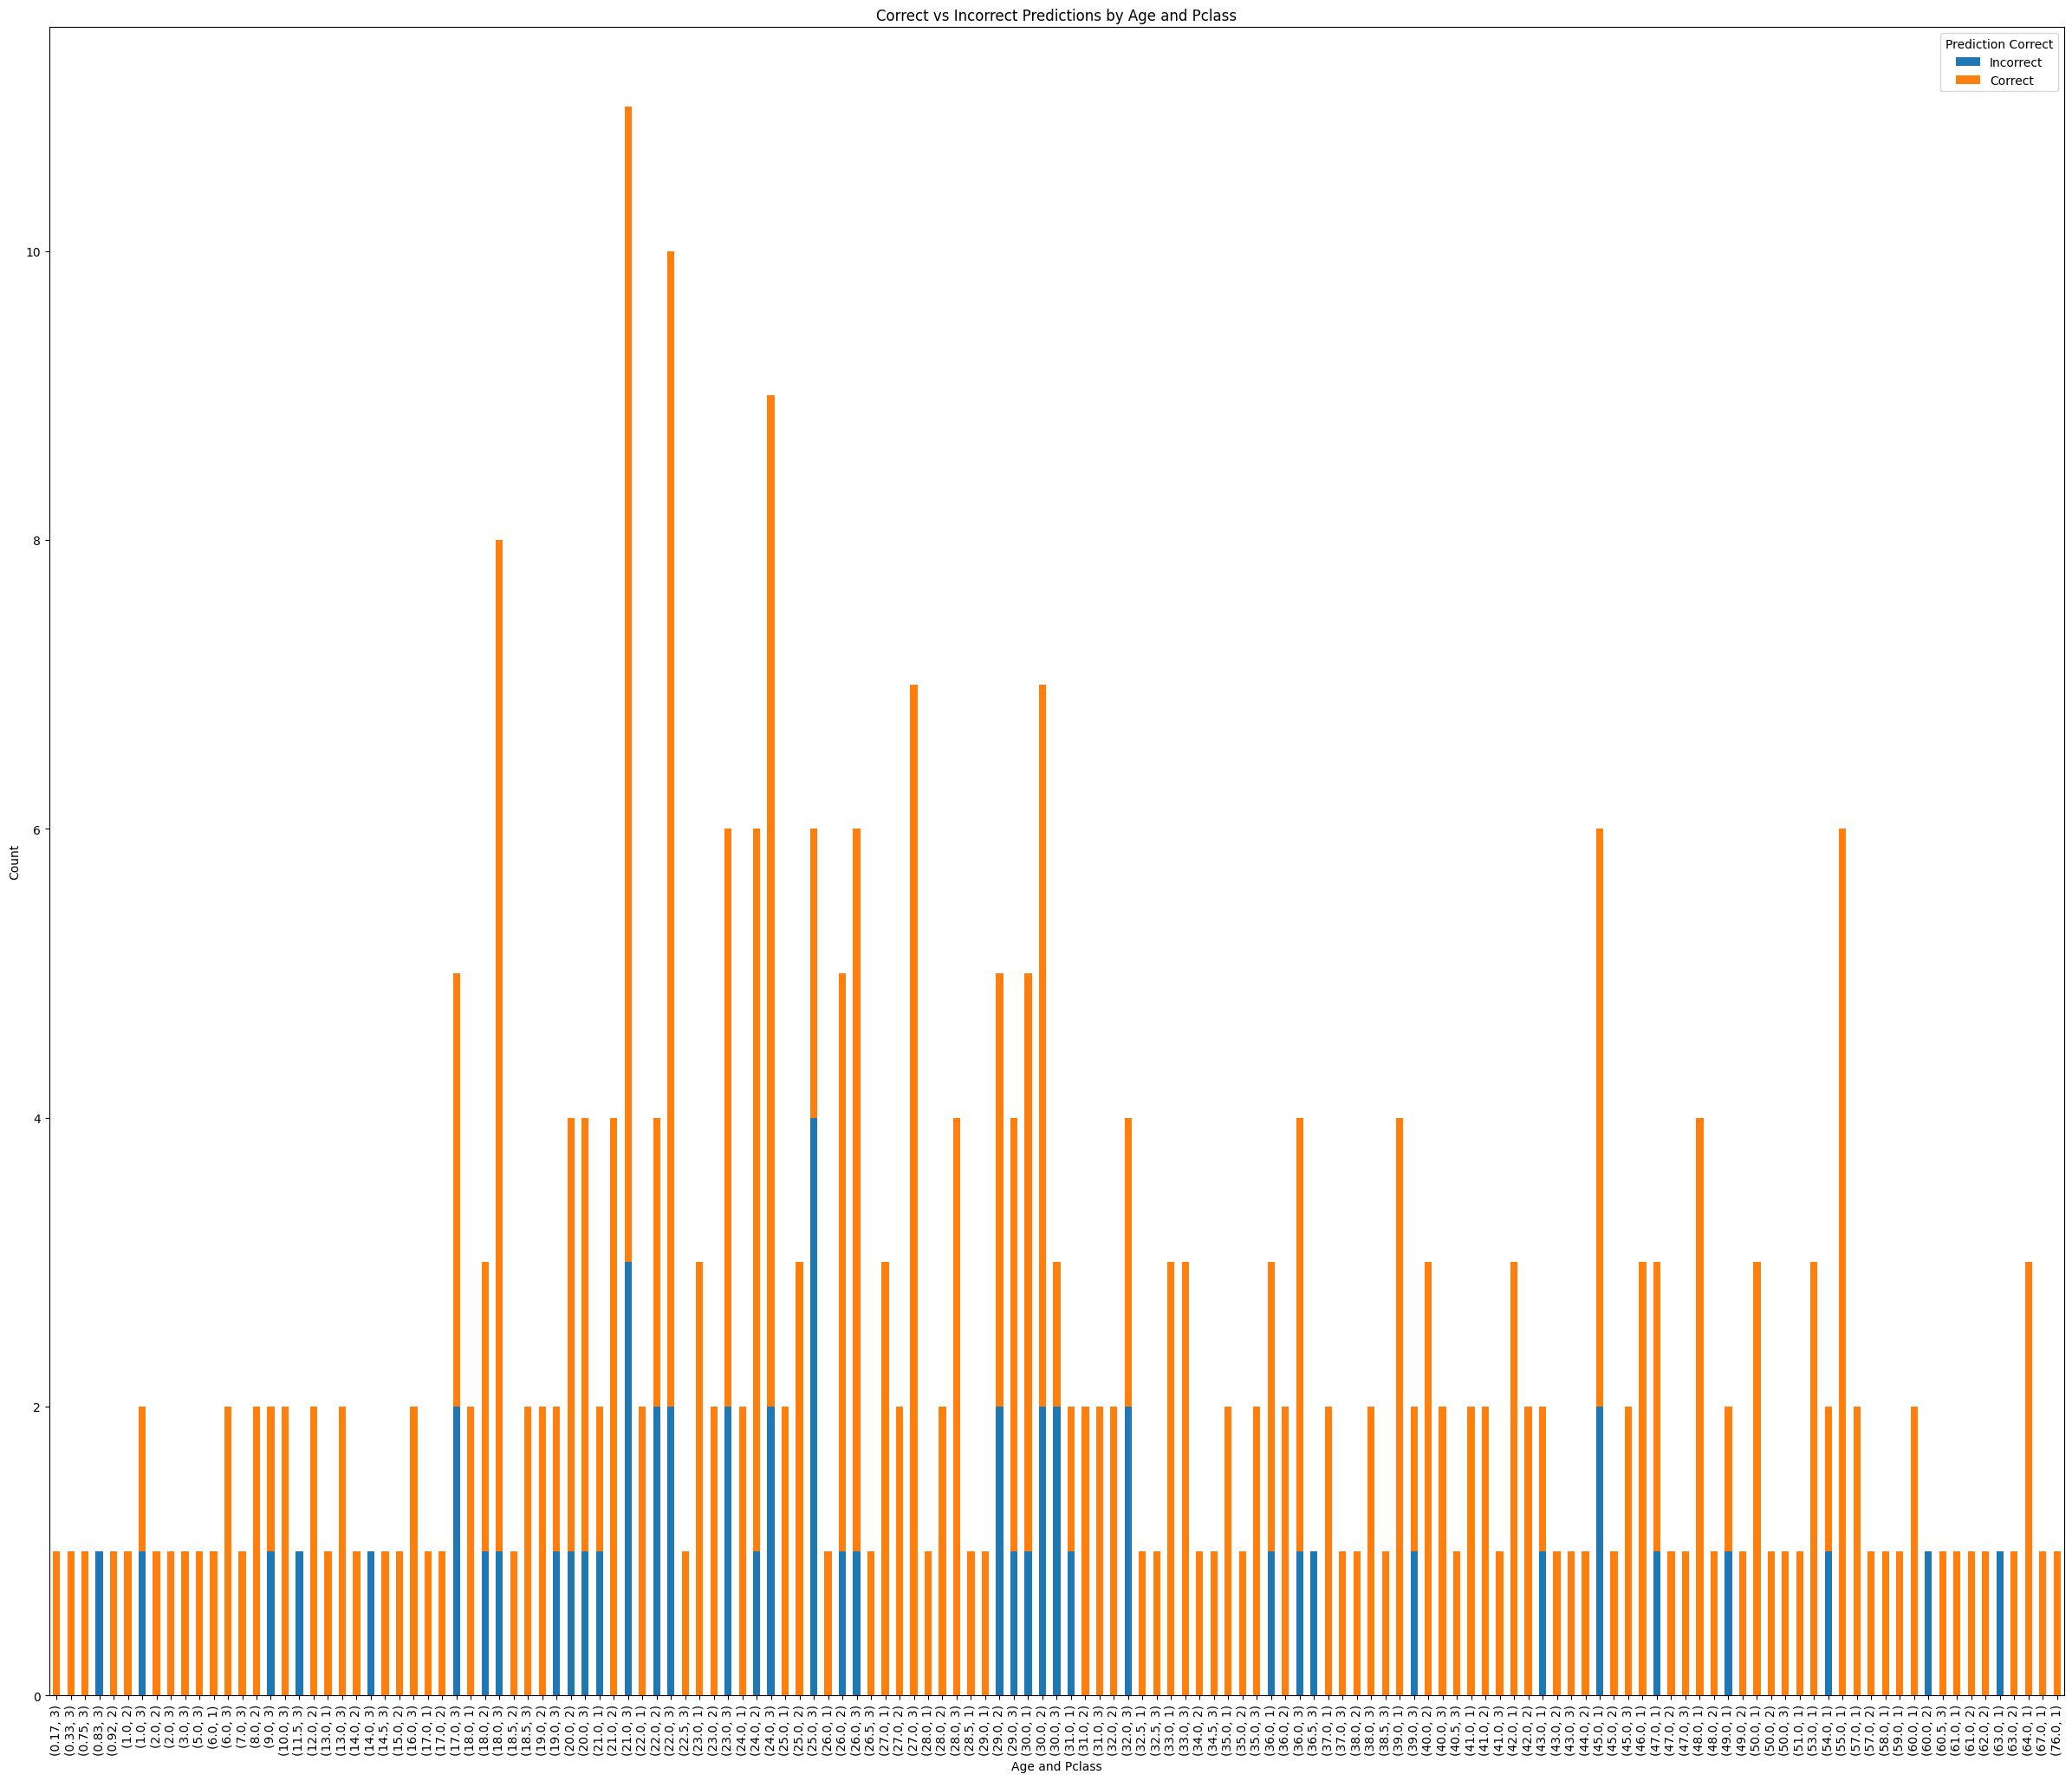

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add a column to indicate correct/incorrect predictions
titanic_df['Prediction_Correct'] = test_result_voted['Survived'] == titanic_df['Survived']

# Group by Age and Pclass, and count correct/incorrect predictions
wrong_grouped = titanic_df.groupby(['Age', 'Pclass', 'Prediction_Correct']).size().unstack(fill_value=0)

# Plot
wrong_grouped.plot(kind='bar', stacked=True, figsize=(30, 25))
plt.title('Correct vs Incorrect Predictions by Age and Pclass')
plt.xlabel('Age and Pclass')
plt.ylabel('Count')
plt.legend(title='Prediction Correct', labels=['Incorrect', 'Correct'])
plt.savefig("1_incorrect_vs_correct.png")
plt.show()

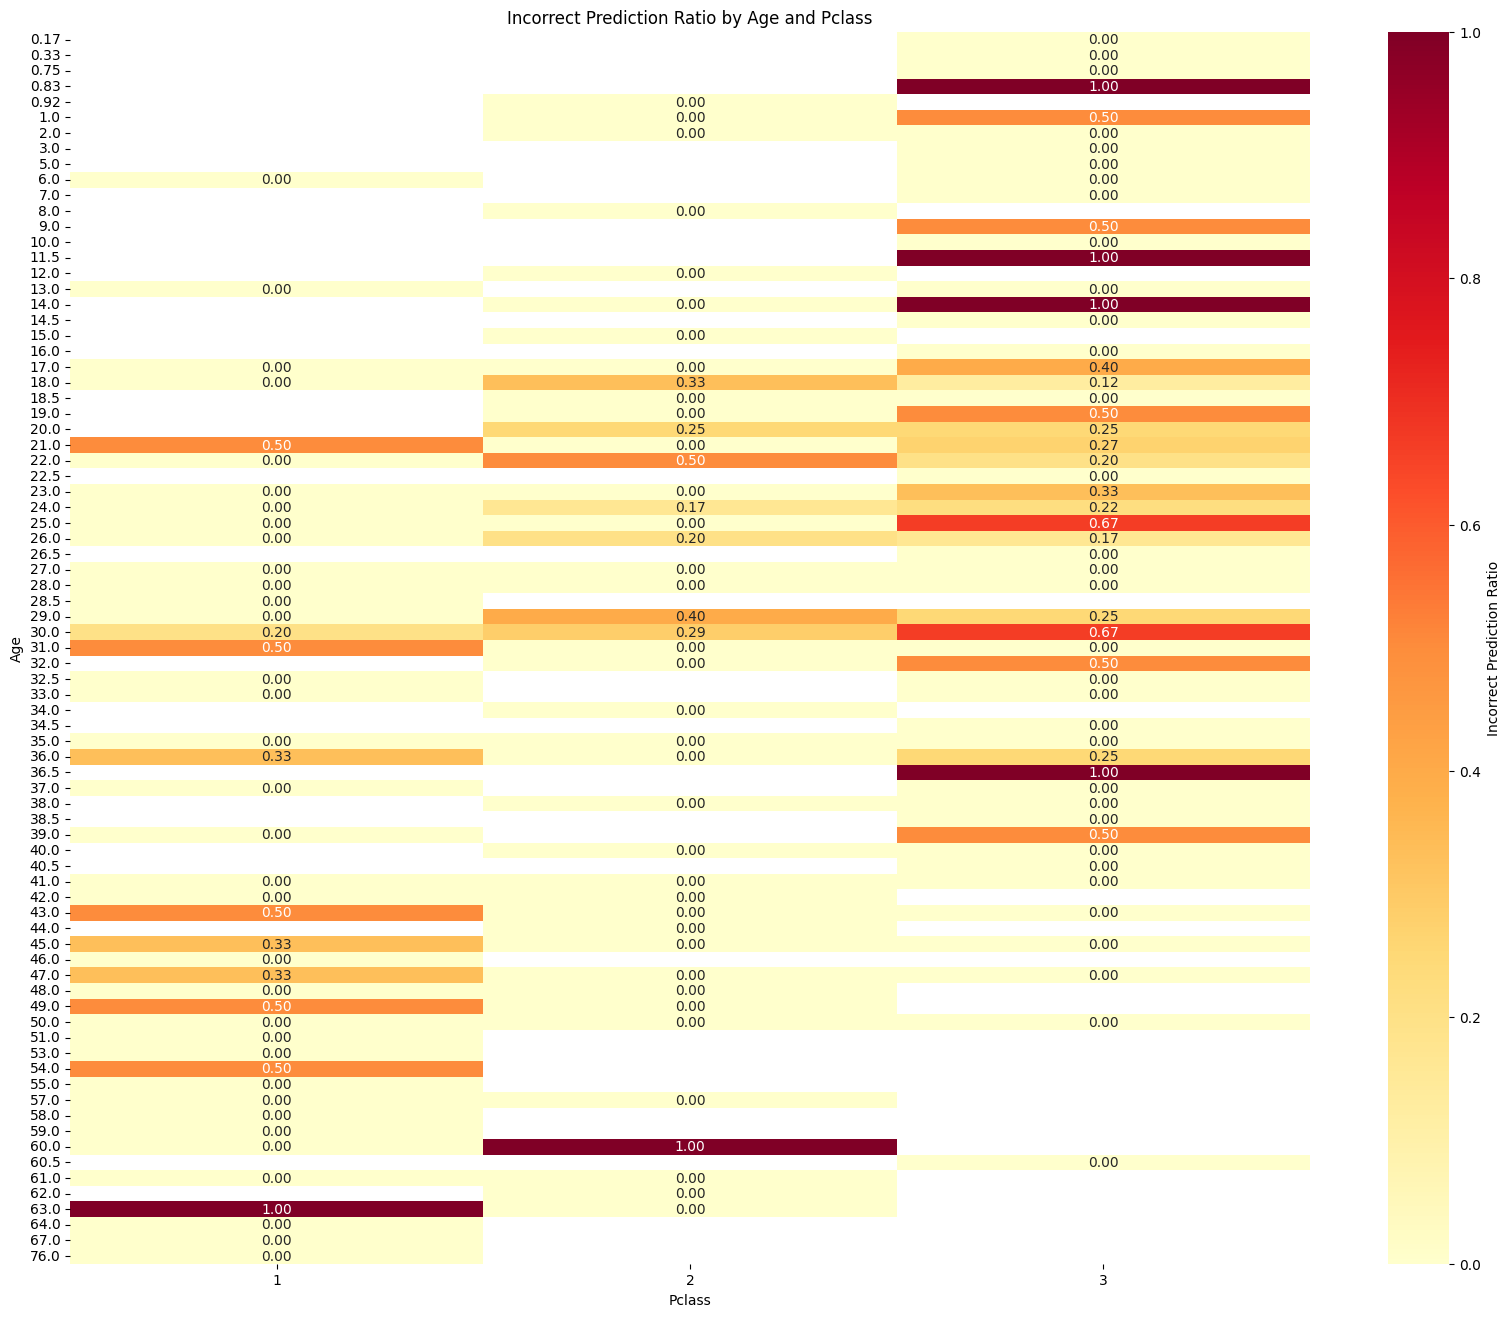

In [168]:
# Calculate the proportion of incorrect predictions
wrong_grouped['Incorrect_Ratio'] = wrong_grouped[False] / (wrong_grouped[False] + wrong_grouped[True])

# Pivot for heatmap
heatmap_data = wrong_grouped.reset_index().pivot(index='Age', columns='Pclass', values='Incorrect_Ratio')

# Plot heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': 'Incorrect Prediction Ratio'})
plt.title('Incorrect Prediction Ratio by Age and Pclass')
plt.xlabel('Pclass')
plt.ylabel('Age')
plt.savefig("1_incorrect_pred_ratio_age_class.png")
plt.show()

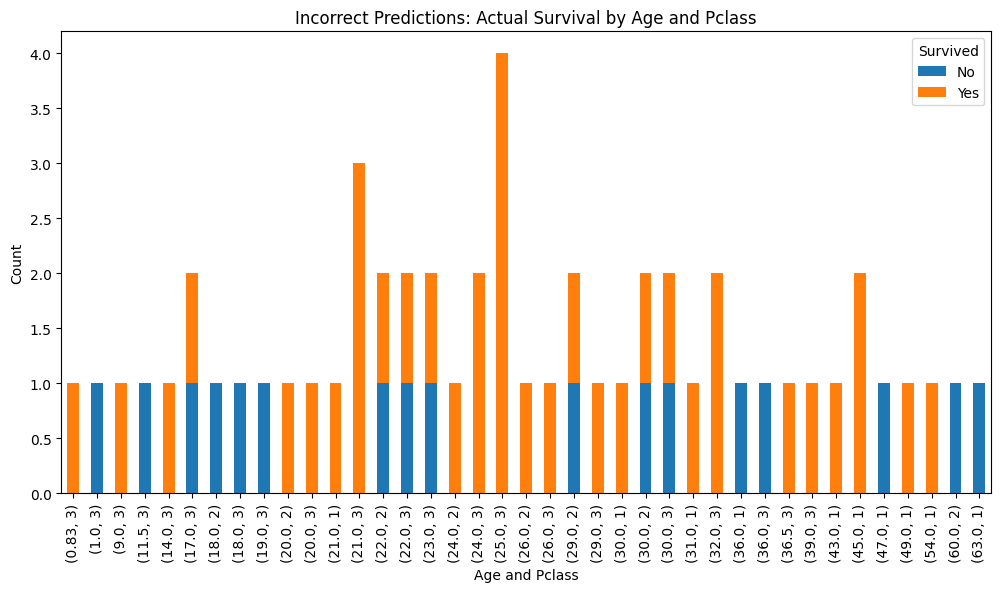

In [169]:
# Filter incorrect predictions
incorrect_predictions = titanic_df[~titanic_df['Prediction_Correct']]

# Group by Age, Pclass, and Survived
incorrect_grouped = incorrect_predictions.groupby(['Age', 'Pclass', 'Survived']).size().unstack(fill_value=0)

# Plot
incorrect_grouped.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Incorrect Predictions: Actual Survival by Age and Pclass')
plt.xlabel('Age and Pclass')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.savefig("1_false_negatives_positives_actual_values.png")
plt.show()

In [170]:
#cross_validate(voting_clf, cv, scores, 'voted')
#scores

In [171]:
yh = dt.predict(X_test_pre)
#print(yh) 
#print(y_true)
#print(yh)
yh = pd.Series(yh, name='Survived')
#yh = pd.Series(yh, X_test_final.index, name='Survived')
print(yh.value_counts())
y_pred_proba = dt.predict_proba(X_test_pre)[:, 1]
#f1_score_test = f1_score(y_true, yh)
accuracy_score_dt = accuracy_score(y_true, yh)
roc_score_test = roc_auc_score(y_true, y_pred_proba)
#print("F1 Score: ", f1_score_test)
#print("ROC Score: ", roc_score_test)
print("Accuracy Score: ", accuracy_score_dt)




test_result_dt =  pd.concat([
    #pd.DataFrame(X_test_Passenger),
    yh, 
   # y_true
], axis=1)
test_result_dt.index = X_test_Passenger
test_result_dt.index.name = 'PassengerId'

assert (test_result_dt.sort_index().index == list(range(892, 1310))).all(), "PassengerIds don't match"

#test_result_dt.to_csv(data_path/'submission_test_dt_AGTSFCPDCFBEAtSA_ns_acc_nb.csv')





#print(test_result_dt)
#print(test_result_dt)
cr = classification_report(y_true, yh)
cm = confusion_matrix(y_true, yh)

print(cm)
print(cr)

feature_importance = dt.named_steps['decisiontreeclassifier'].feature_importances_
importance_df = pd.DataFrame({'Feature': feat_names, 'Importance': feature_importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)


Survived
0.0    243
1.0    175
Name: count, dtype: int64
Accuracy Score:  0.7631578947368421
[[202  58]
 [ 41 117]]
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       260
           1       0.67      0.74      0.70       158

    accuracy                           0.76       418
   macro avg       0.75      0.76      0.75       418
weighted avg       0.77      0.76      0.77       418

                                         Feature  Importance
0        cat__Title_Survival_0.15667311411992263       0.522
8                                  cat__Pclass_3       0.136
1         cat__Title_Survival_0.4444444444444444       0.073
16                            cat__Deck_Hybrid_U       0.063
44                      cat__Group_Size_Class_21       0.050
30                     cat__Family_Size_Class_18       0.037
29                     cat__Family_Size_Class_15       0.032
47  targ__target_encode__Adjusted_StairProximity       0.022
45      

In [172]:
#titanic_df["Name"].value_counts()

In [173]:
#titanic_df

In [174]:
yh = rf.predict(X_test_pre)
#print(yh) 
yh = pd.Series(yh.astype(int), name='Survived')
print(yh.value_counts())

y_pred_proba = rf.predict_proba(X_test_pre)[:, 1]

# Adjust the threshold (e.g., 0.6 instead of the default 0.5)
threshold = 0.5
yh = pd.DataFrame((y_pred_proba >= threshold).astype(int), columns=['Survived'])



f1_score_test = f1_score(titanic_df["Survived"], yh)
accuracy_score_rf = accuracy_score(titanic_df["Survived"], yh)
roc_score_test = roc_auc_score(titanic_df["Survived"], y_pred_proba)
#print("F1 Score: ", f1_score_test)
#print("ROC Score: ", roc_score_test)
print("Accuracy Score: ", accuracy_score_rf)



test_result_rf =  pd.concat([
    #pd.DataFrame(X_test_Passenger),
    yh
], axis=1)
test_result_rf.index = X_test_Passenger
test_result_rf.index.name = 'PassengerId'

titanic_df.index = X_test_Passenger
titanic_df.index.name = 'PassengerId'

assert (test_result_rf.sort_index().index == list(range(892, 1310))).all(), "PassengerIds don't match"
assert (test_result_rf.index.name == 'PassengerId'), "Index Name wrong"
assert ('Survived' in test_result_rf.columns), "Column name is wrong"



#test_result_rf.to_csv(data_path/'submission_test_rf_1403_811.csv')


#print(test_result_rf)

cr = classification_report(y_true, yh)
cm = confusion_matrix(y_true, yh)

print(cm)
print(cr)


#feature_importance = rf.named_steps['randomforestclassifier'].feature_importances_
#importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
#importance_df.sort_values(by='Importance', ascending=False, inplace=True)
importances = pd.DataFrame(np.zeros((X_train_pre.shape[1], 5)), columns=['Fold_{}'.format(i) for i in range(1, 5 + 1)], index=feat_names)
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

print(importance_df)
#print(titanic_df)

wrong = titanic_df[test_result_rf['Survived'] != titanic_df['Survived']]
#print(titanic_df["Pclass"].value_counts())
#print(wrong["Pclass"].value_counts())

# best 49 false negative with 30 false positive

Survived
0    281
1    137
Name: count, dtype: int64
Accuracy Score:  0.8110047846889952
[[231  29]
 [ 50 108]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       260
           1       0.79      0.68      0.73       158

    accuracy                           0.81       418
   macro avg       0.81      0.79      0.79       418
weighted avg       0.81      0.81      0.81       418

                                         Feature  Importance
0        cat__Title_Survival_0.15667311411992263       0.522
8                                  cat__Pclass_3       0.136
1         cat__Title_Survival_0.4444444444444444       0.073
16                            cat__Deck_Hybrid_U       0.063
44                      cat__Group_Size_Class_21       0.050
30                     cat__Family_Size_Class_18       0.037
29                     cat__Family_Size_Class_15       0.032
47  targ__target_encode__Adjusted_StairProximity       0.022
45          

This is better: 
[[230  30]
 [ 49 109]] 

 than 
 [[231  29]
 [ 50 108]]

In [175]:
yh = xgb_local.predict(X_test_pre)
#print(yh) 
yh = pd.Series(yh, name='Survived')
print(yh.value_counts())

y_pred_proba = xgb_local.predict_proba(X_test_pre)[:, 1]
f1_score_test = f1_score(titanic_df["Survived"], yh)
accuracy_score_xgb = accuracy_score(titanic_df["Survived"], yh)
roc_score_test = roc_auc_score(titanic_df["Survived"], y_pred_proba)
#print("F1 Score: ", f1_score_test)
#print("ROC Score: ", roc_score_test)
print("Accuracy Score: ", accuracy_score_xgb)


#yh.to_csv(data_path/'submission_test_xgb_2802.csv')



test_result_xgb =  pd.concat([
    #pd.DataFrame(X_test_Passenger),
    yh
], axis=1)
test_result_xgb.index = X_test_Passenger
test_result_xgb.index.name = 'PassengerId'

assert (test_result_xgb.sort_index().index == list(range(892, 1310))).all(), "PassengerIds don't match"

#test_result_xgb.to_csv(data_path/'submission_test_xgb_0703_811.csv')



cr = classification_report(y_true, yh)
cm = confusion_matrix(y_true, yh)
tn, fp, fn, tp = confusion_matrix(y_true, yh).ravel()
print(fp)
print(fn)

print(cm)
print(cr)

#feature_importance = xgb_local.named_steps['xgbclassifier'].feature_importances_
#importance_df = pd.DataFrame({'Feature': feat_names, 'Importance': feature_importance})
#importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

importances = pd.DataFrame(np.zeros((X_train_pre.shape[1], 5)), columns=['Fold_{}'.format(i) for i in range(1, 5 + 1)], index=feat_names)
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)
#print(importance_df)


Survived
0    257
1    161
Name: count, dtype: int64
Accuracy Score:  0.7870813397129187
46
43
[[214  46]
 [ 43 115]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       260
           1       0.71      0.73      0.72       158

    accuracy                           0.79       418
   macro avg       0.77      0.78      0.77       418
weighted avg       0.79      0.79      0.79       418

                                         Feature  Importance
0        cat__Title_Survival_0.15667311411992263       0.522
8                                  cat__Pclass_3       0.136
1         cat__Title_Survival_0.4444444444444444       0.073
16                            cat__Deck_Hybrid_U       0.063
44                      cat__Group_Size_Class_21       0.050
30                     cat__Family_Size_Class_18       0.037
29                     cat__Family_Size_Class_15       0.032
47  targ__target_encode__Adjusted_StairProximity       0.022
45    

In [176]:
combined_df.columns

Index(['Adjusted_StairProximity', 'Adjusted_StairProximity_Missing', 'Age',
       'Age_Binned', 'Age_Group', 'Alone', 'Cabin', 'Cabin_Letters_all',
       'Cabin_numeric_all', 'Combined_Group_Fam', 'Deck_Category',
       'Deck_Hybrid', 'Deck_KNN', 'Deck_Known', 'Deck_Level', 'Deck_Level_num',
       'Deck_Survival_Rate', 'Embarked', 'Embarked_encoded', 'FG_Size',
       'FG_Survival_Rate', 'Family_Category', 'Family_Size',
       'Family_Size_Class', 'Fare', 'Fare_Binned', 'Fare_Per_Person',
       'First_Name', 'Group_Category', 'Group_Id', 'Group_Size_Class',
       'Is_Married', 'Last_Name', 'Name', 'Parch', 'Parsed_Cabins', 'Pclass',
       'ST_Survival', 'ST_Survival_Missing', 'Sex', 'SibSp', 'Survived',
       'Ticket', 'Ticket_Count', 'Ticket_prefix', 'Title', 'Title_Survival',
       'WC', 'WC_encoded'],
      dtype='object')

# Exploration Code - not used in the final model 
The below code was necessary in order to obtain the above results, however does not need to be executed in order to obtain a prediction.

### SMOTE on data set

In [177]:
#from imblearn.over_sampling import SMOTE

#Apply SMOTE to the training data
#smote = SMOTE(random_state=random_state)
#X_train, y_bla = smote.fit_resample(X_train, train_df['Pclass'])

#Check the class distribution after applying SMOTE
#y_train = X_train["Survived"]
#print("Class distribution after SMOTE:", pd.Series(y_train).value_counts())

In [178]:
#from imblearn.under_sampling import RandomUnderSampler

# Apply Random Undersampling
#rus = RandomUnderSampler(random_state=random_state)
#X_train, y_train = rus.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
#print("Class distribution after Random Undersampling:", pd.Series(y_train).value_counts())

In [179]:
# Pclass 1
'''combined_df['Title_Mr_Class1'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 1)).astype(int)
combined_df['Title_Miss_Mrs_Class1'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 1)).astype(int)
combined_df['Title_Master_Class1'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 1)).astype(int)
combined_df['Title_Rare_Class1'] = ((combined_df['Title'] == 'Rare') & (combined_df['Pclass'] == 1)).astype(int)


# Pclass 2
combined_df['Title_Mr_Class2'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 2)).astype(int)
combined_df['Title_Miss_Mrs_Class2'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 2)).astype(int)
combined_df['Title_Master_Class2'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 2)).astype(int)
combined_df['Title_Rare_Class2'] = ((combined_df['Title'] == 'Rare') & (combined_df['Pclass'] == 2)).astype(int)

# Pclass 3

combined_df['Title_Mr_Class3'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 3)).astype(int)
combined_df['Title_Miss_Mrs_Class3'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 3)).astype(int)
combined_df['Title_Master_Class3'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 3)).astype(int)
combined_df['Title_Rare_Class3'] = ((combined_df['Title'] == 'Rare') & (combined_df['Pclass'] == 3)).astype(int)
'''

"combined_df['Title_Mr_Class1'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 1)).astype(int)\ncombined_df['Title_Miss_Mrs_Class1'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 1)).astype(int)\ncombined_df['Title_Master_Class1'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 1)).astype(int)\ncombined_df['Title_Rare_Class1'] = ((combined_df['Title'] == 'Rare') & (combined_df['Pclass'] == 1)).astype(int)\n\n\n# Pclass 2\ncombined_df['Title_Mr_Class2'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 2)).astype(int)\ncombined_df['Title_Miss_Mrs_Class2'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 2)).astype(int)\ncombined_df['Title_Master_Class2'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 2)).astype(int)\ncombined_df['Title_Rare_Class2'] = ((combined_df['Title'] == 'Rare') & (combined_df['Pclass'] == 2)).astype(int)\n\n# Pclass 3\n\ncombined_df['Title_Mr_Class3'] = ((comb

In [180]:
# Pclass 1
'''combined_df['Title_Mr_Class1_Child'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 0)).astype(int)
combined_df['Title_Mr_Class1_Adult'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 1)).astype(int)

combined_df['Title_Miss_Mrs_Class1_Child'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 0)).astype(int)
combined_df['Title_Miss_Mrs_Class1_Adult'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 1)).astype(int)


combined_df['Title_Master_Class1_Child'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 0)).astype(int)
combined_df['Title_Master_Class1_Adult'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 1)).astype(int)

combined_df['Title_Rare_Class1_Child'] = ((combined_df['Title'] == 'Rare') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 0)).astype(int)
combined_df['Title_Rare_Class1_Adult'] = ((combined_df['Title'] == 'Rare') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 1)).astype(int)


# Pclass 2
combined_df['Title_Mr_Class2_Child'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 2) & (combined_df['Age_Group'] == 0)).astype(int)
combined_df['Title_Mr_Class2_Adult'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 2) & (combined_df['Age_Group'] == 1)).astype(int)

combined_df['Title_Miss_Mrs_Class2_Child'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 2) & (combined_df['Age_Group'] == 0)).astype(int)
combined_df['Title_Miss_Mrs_Class2_Adult'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 2) & (combined_df['Age_Group'] == 1)).astype(int)


combined_df['Title_Master_Class2_Child'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 2) & (combined_df['Age_Group'] == 0)).astype(int)
combined_df['Title_Master_Class2_Adult'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 2) & (combined_df['Age_Group'] == 1)).astype(int)

combined_df['Title_Rare_Class2_Child'] = ((combined_df['Title'] == 'Rare') & (combined_df['Pclass'] == 2) & (combined_df['Age_Group'] == 0)).astype(int)
combined_df['Title_Rare_Class2_Adult'] = ((combined_df['Title'] == 'Rare') & (combined_df['Pclass'] == 2) & (combined_df['Age_Group'] == 1)).astype(int)

# Pclass 3

combined_df['Title_Mr_Class3_Child'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 3) & (combined_df['Age_Group'] == 0)).astype(int)
combined_df['Title_Mr_Class3_Adult'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 3) & (combined_df['Age_Group'] == 1)).astype(int)

combined_df['Title_Miss_Mrs_Class3_Child'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 3) & (combined_df['Age_Group'] == 0)).astype(int)
combined_df['Title_Miss_Mrs_Class3_Adult'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 3) & (combined_df['Age_Group'] == 1)).astype(int)


combined_df['Title_Master_Class3_Child'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 3) & (combined_df['Age_Group'] == 0)).astype(int)
combined_df['Title_Master_Class3_Adult'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 3) & (combined_df['Age_Group'] == 1)).astype(int)

combined_df['Title_Rare_Class3_Child'] = ((combined_df['Title'] == 'Rare') & (combined_df['Pclass'] == 3) & (combined_df['Age_Group'] == 0)).astype(int)
combined_df['Title_Rare_Class3_Adult'] = ((combined_df['Title'] == 'Rare') & (combined_df['Pclass'] == 3) & (combined_df['Age_Group'] == 1)).astype(int)
'''

"combined_df['Title_Mr_Class1_Child'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 0)).astype(int)\ncombined_df['Title_Mr_Class1_Adult'] = ((combined_df['Title'] == 'Mr') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 1)).astype(int)\n\ncombined_df['Title_Miss_Mrs_Class1_Child'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 0)).astype(int)\ncombined_df['Title_Miss_Mrs_Class1_Adult'] = ((combined_df['Title'] == 'Miss/Mrs') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 1)).astype(int)\n\n\ncombined_df['Title_Master_Class1_Child'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 0)).astype(int)\ncombined_df['Title_Master_Class1_Adult'] = ((combined_df['Title'] == 'Master') & (combined_df['Pclass'] == 1) & (combined_df['Age_Group'] == 1)).astype(int)\n\ncombined_df['Title_Rare_Class1_Child'] = ((combined

In [181]:

#combined_df['Age_Sex'] = combined_df['Age_Binned']*combined_df['Sex']
#combined_df['Sex_times_Pclass'] = combined_df['Sex']*combined_df['Pclass']
#combined_df['Family_Size_Deck_Category'] = combined_df['Family_Size'] * combined_df['Deck_Category']  # Interaction between FamilySize and Pclass
#combined_df['Group_Size_Deck_Category'] = combined_df['Ticket_Count'] * combined_df['Deck_Category']  # Interaction between Group/Family Size and Pclass

#combined_df['ASP_Title'] = combined_df['Adjusted_StairProximity']*combined_df['Title'].map(title_mapping).astype(int)
#combined_df['DL_Sex'] = combined_df['Deck_Level_num']*combined_df['Sex']


In [182]:
l
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

xgb_model = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',  # Use GPU for histogram-based algorithm
    #gpu_id=0,
    #predicor='gpu_predictor',
    grow_policy='lossguide',
    n_estimators=1150,  # Start with fewer trees
    max_depth=7,
    min_child_weight=6,
    gamma=2,
    random_state=random_state,
    #use_label_encoder=False,
    eval_metric='logloss',
    #early_stopping_rounds=10  # Enable early stopping
)


rf_model_voting = RandomForestClassifier(
    criterion='gini',
    n_estimators=1150,
    max_depth=7,
    min_samples_split=6,
    min_samples_leaf=6,
    random_state=random_state,
    #class_weight='balanced',
    n_jobs=-1,
    verbose=0
)

xgb_model_voting = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    grow_policy='lossguide',
    n_estimators=1150,
    max_depth=7,
    min_child_weight=6,
    #class_weight='balanced',
    gamma=2,
    random_state=random_state,
    eval_metric='error'
)

# Add a third model (e.g., Logistic Regression)

log_reg = LogisticRegression(
    penalty='l2',           # Use L2 regularization
    C=0.01,                 # Strong regularization
    #solver='lbfgs',        # Good for small/medium datasets
    solver='newton-cg',
    #solver='liblinear',
    #class_weight='balanced',  # Handle class imbalance
    max_iter=1000,         # Increase iterations for convergence
    random_state=random_state,
    tol=1e-4               # Set tolerance for stopping criteria
)

# Create the Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model_voting),      # Random Forest
        ('xgb', xgb_model_voting),    # XGBoost
        ('log_reg', log_reg)   # Logistic Regression
    ],
    voting='hard'  # Use 'soft' for weighted probability voting
)

title_mapping = { 'Mr':1,  'Miss/Mrs':2, 'Master':3, 'Rare':4}

#combined_df['DL_Title'] = combined_df['Deck_Level_num']*combined_df['Title'].map(title_mapping).astype(int)

#combined_df['Age_Binned1'] = combined_df['Age_Binned']
#combined_df['Fare_Binned1'] = combined_df['Fare_Binned']
#combined_df['Adjusted_StairProximity1'] = combined_df['Adjusted_StairProximity']

categorical_features = [#'Sex', 
                        #'Combined_Group_Fam',
                        #'Embarked', 
                        #'DL_Title',
                        #'Fare_Binned1',
                        
                        'Is_Married',
                        'Pclass',
                        'Title',
                        'WC', 
                        'Is_Married', 
                            # 'Deck_Level',
                        'Deck_Hybrid',
                        'Deck_Known',
                        #'Deck_Category',
                         # 'Family_Size_Deck_Category', 'Group_Size_Deck_Category'                    
                        'Family_Size_Class', 
                        'Group_Size_Class', 
                        #'Group_Survival', 'Group_Survival_Missing',
                        #'ST_Survival',
                        #'ST_Survival_Missing',
                        'Title_Survival', 
                        'FG_Survival_Rate',
                        'Alone',
                        #'Adjusted_StairProximity_Missing',
                        #'Adjusted_StairProximity'
                        #'Ticket_prefix', 
                       ]

features_to_label = [ 'Combined_Group_Fam', 'Age_Binned']#, 'Age_Binned1'] # 'Fare_Binned']#'Deck_Category']#, 'Adjusted_StairProximity']# 'Deck_Level' ]# 'Group_Category', 'Family_Category', #'Age_Group', ]#

for feature in features_to_label: 
    #print(combined_df[feature].head(2))
    combined_df[feature] = LabelEncoder().fit_transform(combined_df[feature])
    #print(combined_df[feature].head(2))


#combined_df['Age_Sex'] = combined_df['Age_Binned']*combined_df['Sex']
#combined_df['Sex_times_Pclass'] = combined_df['Sex']*combined_df['Pclass']
#combined_df['Family_Size_Deck_Category'] = combined_df['Family_Size'] * combined_df['Deck_Category']  # Interaction between FamilySize and Pclass
#combined_df['Group_Size_Deck_Category'] = combined_df['Ticket_Count'] * combined_df['Deck_Category']  # Interaction between Group/Family Size and Pclass

#combined_df['ASP_Title'] = combined_df['Adjusted_StairProximity']*combined_df['Title'].map(title_mapping).astype(int)
#combined_df['DL_Sex'] = combined_df['Deck_Level_num']*combined_df['Sex']

target_features = [#'Sex', 
                    #'Sex_times_Pclass',
                    'Age_Binned', 
                   #'ST_Survival_Missing',
                   #'Deck_Known',
                   'Combined_Group_Fam', 
                   #'ASP_Title',
                   'Adjusted_StairProximity',
                    #'DL_Sex',
                    #'DL_Title',
                  ] # 'Combined_Group_Fam',#'FG_Survival_Rate']
# 'Age_Sex'
#pass_through = ['ST_Survival_Missing', 'Deck_Known', 'Combined_Group_Fam',]# 'Sex']#'Adjusted_StairProximity_Missing']
'''ordinal_features = [ 'Age_Binned',
                    'Deck_Level_num', 
                    #'Adjusted_StairProximity',
                    'Fare_Binned']'''

#'Pclass']
#numerical = ['ST_Survival']#, 'Adjusted_StairProximity']
#numerical_features = ['Group_Survival', 'Family_Survival', 'ST_Survival',
#                      'Family_Survival_Missing', 'Group_Survival_Missing', 'ST_Survival_Missing']

#numerical_features = ['Age_Class',]# 'Sex_Class'# ] # 'Deck_Level' ]
                      #'Family_Size', 'Ticket_Count'] 
# tested #
# 'FG_Size' ]#, 'IsMarried_times_Title'] #'Sex_times_Pclass', 
#'Combined_Group_Fam',


# All possible feature combinations
features = target_features + categorical_features # ordinal_features + 
feature_combinations = []
print(features)

# Generate all combinations of features (from 1 to n features)
for r in range(1, len(features) + 1):
    feature_combinations.extend(combinations(features, r))

print(len(feature_combinations))
# List to store results
results = []

counter = 0
error = 0
X_train, X_test = combined_df.loc[:891], combined_df.loc[892:]
start_index = 35000
feature_combinations_subset = feature_combinations[start_index:]
filename = '1_feature_combos_voted_acc_273_81_upwards.csv'
results_df = pd.DataFrame(results, columns=['Feature Combination', 'fn', 'fp', 'correct', 'Accuracy'])
results_df.to_csv(filename, index=False)



results_df = pd.read_csv(filename)

new_row = pd.DataFrame({
    'Feature Combination': ['test'],
    'fn' : [0], 
    'fp' : [0], 
    'correct': [0],
    'Accuracy': [0],
})
df = pd.concat([results_df, new_row], ignore_index=True)

print(df.shape[0])
df.to_csv(filename, index=False)

# Evaluate each combination using cross-validation
for combo in feature_combinations:
    if counter % 1000 == 0: 
        print("Status: ", counter)
    counter +=1
    try:
        combo = list(combo)
        # Separate categorical and numerical features in the current combination
        cat_combo = [feat for feat in combo if feat in categorical_features]
        #ord_combo = [feat for feat in combo if feat in ordinal_features]
        targ_combo = [feat for feat in combo if feat in target_features ]
    
        target_encoder = TargetEncoder(cols=targ_combo, target_col='Survived')
    
        preprocessor = ColumnTransformer(
            transformers=[
                #('num', StandardScaler(), numerical),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_combo),
                #('ord', OrdinalEncoder(), ord_combo),
                ('targ', target_encoder, targ_combo),
                #('pass', 'passthrough', pass_through)
            ])
    
    
        try: 
            X_train_pre = preprocessor.fit_transform(X_train)
            X_test_pre = preprocessor.transform(X_test)
        except:
            error += 1
            print("Could not preprocess data: ", error)
            print(combo)
            continue
        
        feat_names = preprocessor.get_feature_names_out()
       
        y = train_df['Survived']
        y_true = titanic_df['Survived']
    
        voting_clf.fit(X_train_pre, y)
        #rf_model.fit(X_train_pre, y)
        #cv_scores_without_scaler = cross_val_score(pipeline_without_scaler, X, y, cv=cv, scoring='accuracy')
        yh = voting_clf.predict(X_test_pre)
        #print(yh) 
        yh = pd.Series(yh.astype(int), name='Survived')
        accuracy_score_voted = accuracy_score(y_true, yh)
        #print("accuracy: ", accuracy_score_rf)
        tn, fp, fn, tp = confusion_matrix(y_true, yh).ravel()
        correct = tp + tn

        if accuracy_score_voted > 0.81: 
            print(f"combination {counter} of {len(feature_combinations)}")
            print(combo)
            #print(feat_names)
            print("accuracy: ", accuracy_score_voted)
            # Store the results
            results_df = pd.read_csv(filename)
            
            new_row = pd.DataFrame({
                'Feature Combination': [feat_names],
                'fn' : [fn], 
                'fp' : [fp], 
                'correct': [correct],
                'Accuracy': [accuracy_score_voted],
            })
            df = pd.concat([results_df, new_row], ignore_index=True)

            print(df.shape[0])
            df.to_csv(filename, index=False)
    except: 
        print(f"Error occurred for combination {combo} after preprocessing ") 
        
print("Results successfully saved.")


NameError: name 'l' is not defined

In [ ]:
feat_df = read_file('feature_combos_voted_acc_210_80_5_upwards.csv')
feature2 = read_file(filename)
#feat_df = pd.concat([feature, feature2], sort=True).reset_index()
feat_df['Accuracy'].value_counts()

In [ ]:
feature2['Accuracy'].value_counts()

In [ ]:
feature2.sort_values(by="Accuracy", ascending=False).head(15)

# Unused Code

In [ ]:
def get_mean_cabin_number(cabin):
    if pd.isna(cabin):
        return  0  # Default for missing cabins
    cabins = cabin.split()  # Split into individual cabins
    all_numbers = []
    number=0
    for c in cabins:
        deck = c[0]  # Extract deck
        number += float(c[1:]) if c[1:].isdigit() else 0  # Extract cabin number
        all_numbers.append(number)
        
    return number/len(all_numbers)

#combined_df['Cabin_mean'] = combined_df['Cabin'].apply(get_mean_cabin_number)
#combined_df[['Cabin', 'Cabin_mean']]

'''train_df, test_df = combined_df.loc[:891].copy(), combined_df.loc[892:].copy()

def cabin_number_imputation(df):
    # Make a copy to avoid modifying the original
    data = df.copy()
    
    # Prepare data for KNN imputation
    #print("Missing Cabin values before imputation:", data["Cabin"].value_counts())
    
    features_for_cabin = [
        'Pclass', 
        'Embarked', 
        'Fare_Binned',
        'Age_Group',
    ]

    # Encode categorical features
    label_encoders = {}
    for col in features_for_cabin:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[f'{col}_encoded'] = le.fit_transform(data[col].fillna('missing'))
            label_encoders[col] = le
            features_for_cabin[features_for_cabin.index(col)] = f'{col}_encoded'
    
    # Create separate dataframe for imputation
    impute_df = data[features_for_cabin].copy()
    #print("Missing values in impute_df:", impute_df.isna().sum())

    # Apply KNN imputation
    nn = NearestNeighbors(n_neighbors=5)
    nn.fit(impute_df)
    
    # Store KNN imputed results
    cabin_missing_idx = data[data['Cabin_mean'] == 0.0].index
    
    # For each missing cabin, assign the most common cabin among its K nearest neighbors
    for idx in cabin_missing_idx:
        if (data.loc[idx, 'Deck_Hybrid'] != 'U'):
            #print("Deck is imputed not U")
            # If Deck_Level is exists, use KNN to impute the Cabin
            neighbors = nn.kneighbors(impute_df.loc[[idx]], return_distance=False)[0]
            neighbor_cabins = data.iloc[neighbors]['Cabin_mean'].dropna()
            if len(neighbor_cabins) > 0:
                #print("Cabin value: ", neighbor_cabins.mode()[0])
                data.loc[idx, 'Cabin_Number_KNN'] = neighbor_cabins.mode()[0]
            else:
                # If no neighbor has known cabin, use global mode
                #print("Global mode: ", data['Cabin_mean'].dropna().mode()[0] )
                data.loc[idx, 'Cabin_Number_KNN'] = data['Cabin_mean'].dropna().mode()[0]       
            
    #print("Missing Cabin values after imputation:", data['Cabin_Number_KNN'].isna().sum())
    return data

#train_df = cabin_number_imputation(train_df)
#test_df = cabin_number_imputation(test_df)

combined_df = combine_dfs(train_df, test_df)'''

In [ ]:
combined_df['Married_Male'] = 0
combined_df.loc[(combined_df['Title'] == 'Master') & (combined_df['Is_Married'] == 1), 'Married_Male'] = 1
combined_df.loc[(combined_df['Title'] == 'Mr') & (combined_df['Is_Married']==1), 'Married_Male'] = 1
plot_binned_distribution_for('Married_Male', combined_df)
